# 1. Overview

# 2. Data Understanding

## 2.1 Data Description

## 2.2 Import necessary libraries

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
import logging
import joblib

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sktime.utils.plotting import plot_series
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.model_selection import ParameterGrid

# Suppress the SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Suprimir los mensajes de logging de cmdstanpy
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.3 Define Global Variables

In [2]:
# Define the company tickers and names
company_tickers = {
    'CZMWY': 'Carl Zeiss Meditec',
    'LRCX': 'Lam Research Corporation',
    'TOELY': 'Tokyo Electron Limited'
}
start_date = '2013-01-01'
output_data = 'data/weekly_data_suppliers.csv'

test_weeks = 16

## 2.4 Functions

In [3]:
def get_historical_data(ticker_symbol:str, start_date:str, end_date:str)->pd.DataFrame:
    """
    Fetches historical stock data for a given company between specified dates. 
    Returns a DataFrame containing the historical data.

    Input:
    - ticker_symbol: The stock ticker of the company (e.g., 'ASML').
    - start_date: The start date for the historical data (e.g., '2000-01-01').
    - end_date: The end date for the historical data (e.g., '2024-10-05').

    Output:
    - A pandas DataFrame containing the historical stock data for the specified period.
    """
    # Define the ticker symbol
    stock_data = yf.Ticker(ticker_symbol)

    # Download historical data between the start and end dates
    historical_data = stock_data.history(start=start_date, end=end_date)

    # Reset the index to convert 'Date' from an index to a regular column
    historical_data.reset_index(inplace=True)

    # Return the resulting DataFrame
    return historical_data

In [4]:
def plot_closing_prices(data:pd.DataFrame, close_column:str, company_name:str):
    """
    Plots the historical closing prices of a company's stock over time.

    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.

    Output:
    - A line plot of the company's historical closing prices.
    """
    
    # Convert the 'Date' and 'Close' columns to numpy arrays
    dates = np.array(data.index)
    close_prices = np.array(data[close_column])

    # Create the plot for the 'Close' (closing price) column using matplotlib
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(dates, close_prices, label='Closing Price', color='blue')

    # Add title and axis labels
    plt.title(f'Historical Closing Prices of {company_name} between {dates[0]} and {dates[-1]}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')

    # Rotate X-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the legend
    plt.legend()

    # Adjust layout to prevent overlap of elements
    plt.tight_layout()

    # Display the plot
    plt.show()


In [5]:
def plot_stock_with_multiple_boxplots(data: pd.DataFrame, close_column: str, company_name: str):
    """
    Plots the stock's closing price distribution for weekly, monthly, and quarterly with
    multiple boxplots for each period.
    
    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.
    
    Output:
    - Boxplots for each period (7 for weekly, 12 for monthly, and 4 for quarterly).
    """

    # Ensure 'Date' column is in datetime format
    data['Date'] = pd.to_datetime(data.index)

    # Extract additional time period information
    data['Weekday'] = data['Date'].dt.weekday  # Weekday (0=Monday, 6=Sunday)
    data['Month'] = data['Date'].dt.month      # Month (1=January, 12=December)
    data['Quarter'] = data['Date'].dt.quarter  # Quarter (1 to 4)

    # Plot Weekly Data (7 boxplots for each day of the week)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Weekday', grid=True)
    plt.title(f'{company_name} - Weekly Closing Prices (by Weekday)')
    plt.suptitle('')
    plt.xlabel('Weekday (0=Monday, 6=Sunday)')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Monthly Data (12 boxplots for each month)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Month', grid=True)
    plt.title(f'{company_name} - Monthly Closing Prices (by Month)')
    plt.suptitle('')
    plt.xlabel('Month')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Quarterly Data (4 boxplots for each quarter)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Quarter', grid=True)
    plt.title(f'{company_name} - Quarterly Closing Prices (by Quarter)')
    plt.suptitle('')
    plt.xlabel('Quarter')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    return data

In [6]:
def get_last_friday():
    """
    Input: No arguments; the function uses the current date as the starting point.
    Output: Returns `end_date` as a string formatted as `YYYY-MM-DD`, representing the last Friday's date.
    Logic: Calculate the number of days back to the last Friday.    
    
    """
    today = datetime.today()
    # Calculate the number of days back to the last Friday
    days_back = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_back)
    end_date = last_friday.strftime("%Y-%m-%d")
    return end_date


end_date = get_last_friday()

## 2.5 Code

### 2.5.1 Looking at the dataset

We are going to load the data using the function get_historical_data

In [7]:
# Create an empty DataFrame for the merged data
merged_data = pd.DataFrame()

# Load historical data for each company and merge
for ticker, company_name in company_tickers.items():
    print(f"Loading data for {company_name}...")

    # Call the function get_historical_data for each ticker
    historical_data = get_historical_data(ticker, start_date, end_date)

    # Convert 'Date' column to datetime format and keep only the date (without time)
    historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date

    # Rename 'Close' column to include the company name
    historical_data.rename(columns={'Close': f'Close_{company_name}'}, inplace=True)

    # If merged_data is empty, initialize it with the first company's data
    if merged_data.empty:
        merged_data = historical_data[['Date', f'Close_{company_name}']]
    else:
        # Merge with the existing DataFrame on 'Date'
        merged_data = merged_data.merge(historical_data[['Date', f'Close_{company_name}']], on='Date', how='outer')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)

# Display the merged data
merged_data.head()

Loading data for Carl Zeiss Meditec...
Loading data for Lam Research Corporation...
Loading data for Tokyo Electron Limited...


,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited
Date,,,
2013-01-02,25.741581,1.601115,7.846667
2013-01-03,25.741581,1.570111,7.766667
2013-01-04,25.961222,1.573831,7.700000
2013-01-07,25.961222,1.553161,7.613333
2013-01-08,25.961222,1.528770,7.366667


Now let's plot the stock data

****CARL ZEISS MEDITEC****



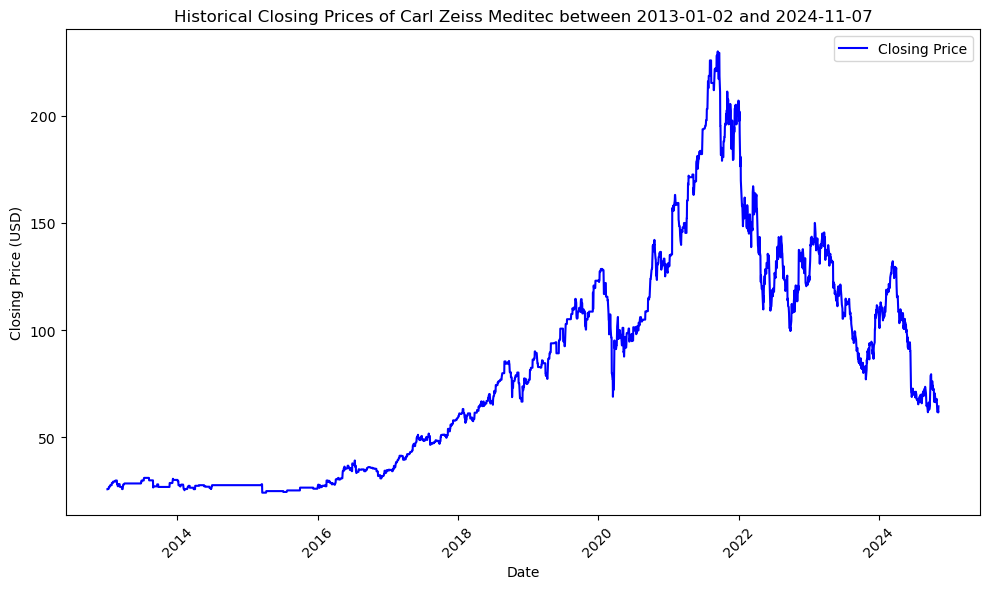


****LAM RESEARCH CORPORATION****



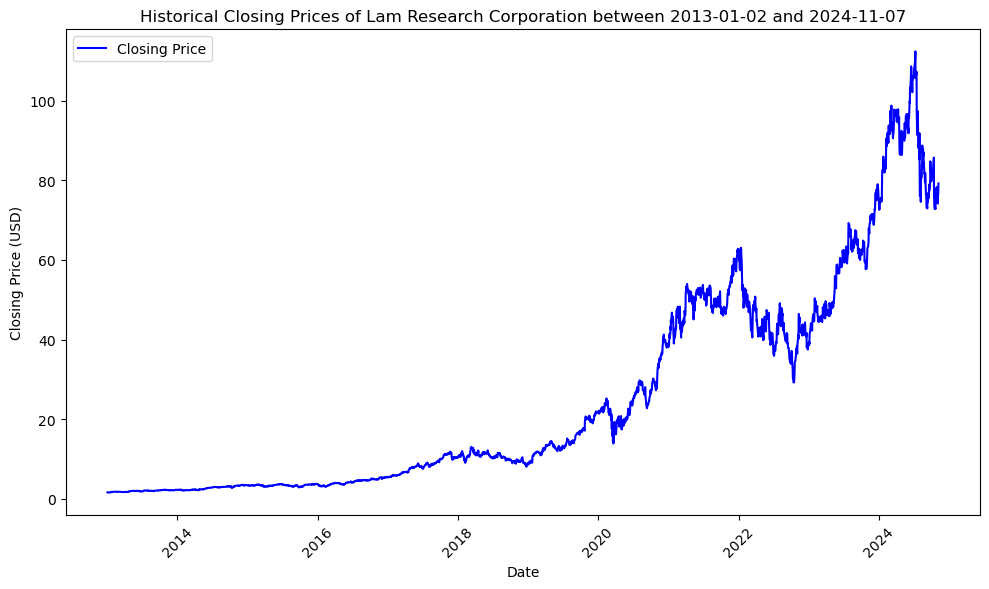


****TOKYO ELECTRON LIMITED****



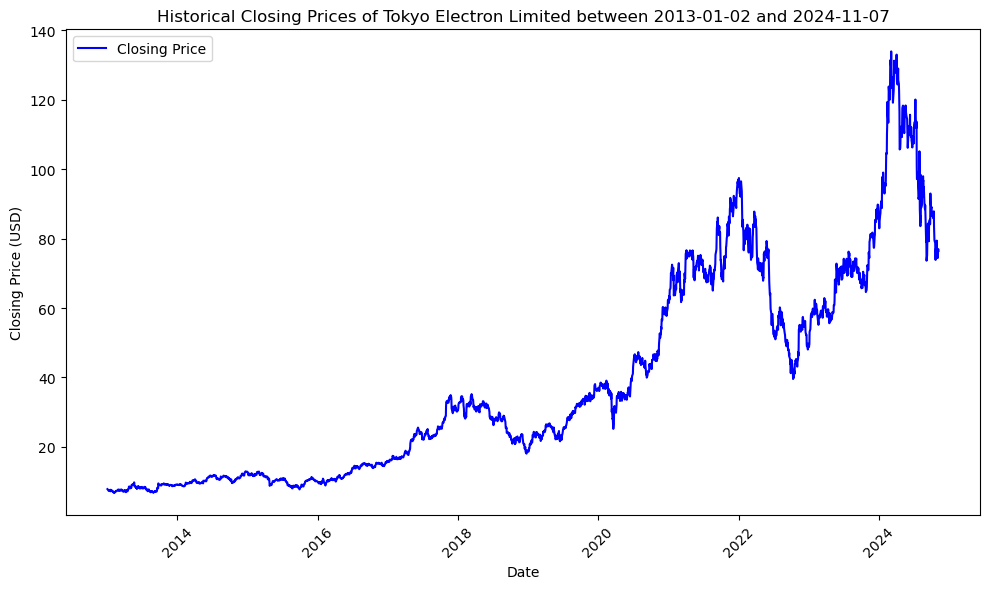

In [8]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_closing_prices(merged_data,f'Close_{company}',company)
    print()

### 2.5.2 Checking for duplicate values

In [9]:
merged_data.duplicated().sum()

0

There are no duplicated values. So we can continue

### 2.5.3 Checking for missing dates

In [10]:
(merged_data.isna().sum()/len(merged_data))*100

Close_Carl Zeiss Meditec          0.0
Close_Lam Research Corporation    0.0
Close_Tokyo Electron Limited      0.0
dtype: float64

As we can see there aren't any null values

### 2.5.4 Looking at seasonality

****CARL ZEISS MEDITEC****



<Figure size 1200x800 with 0 Axes>

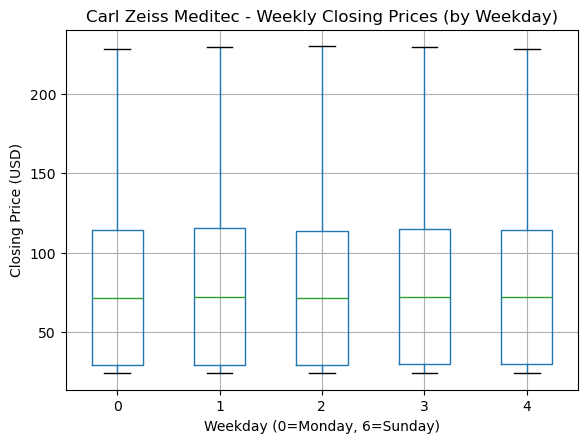

<Figure size 1200x800 with 0 Axes>

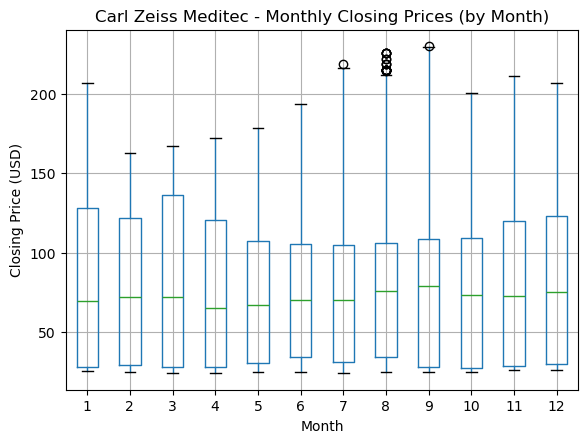

<Figure size 1200x800 with 0 Axes>

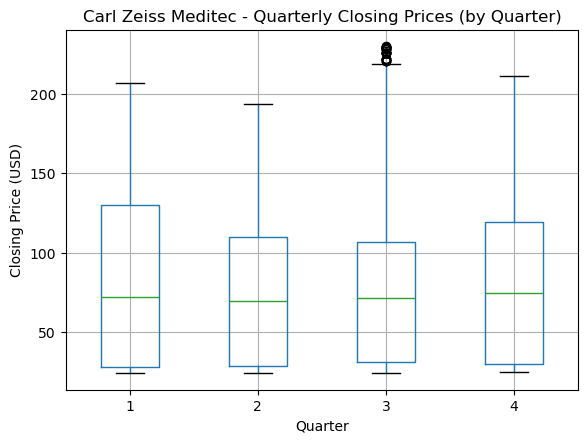


****LAM RESEARCH CORPORATION****



<Figure size 1200x800 with 0 Axes>

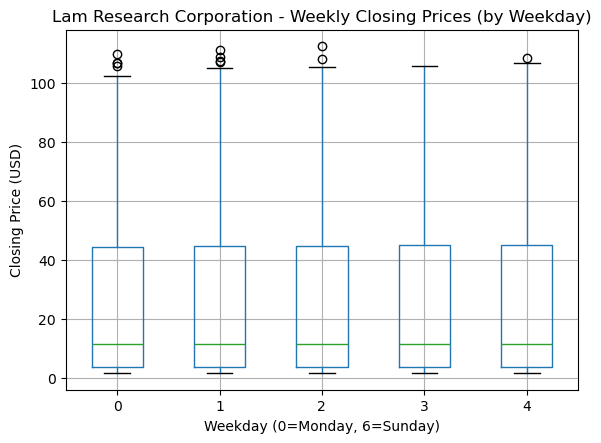

<Figure size 1200x800 with 0 Axes>

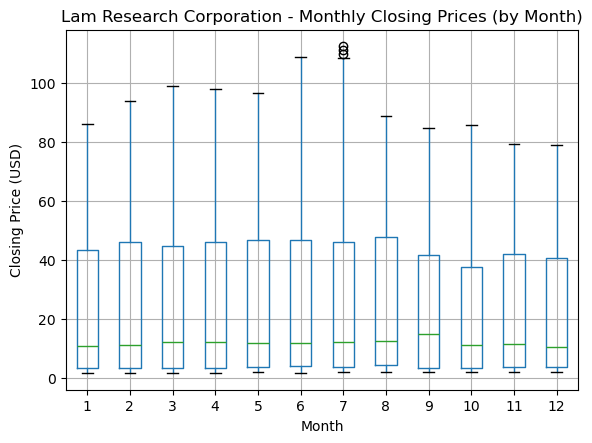

<Figure size 1200x800 with 0 Axes>

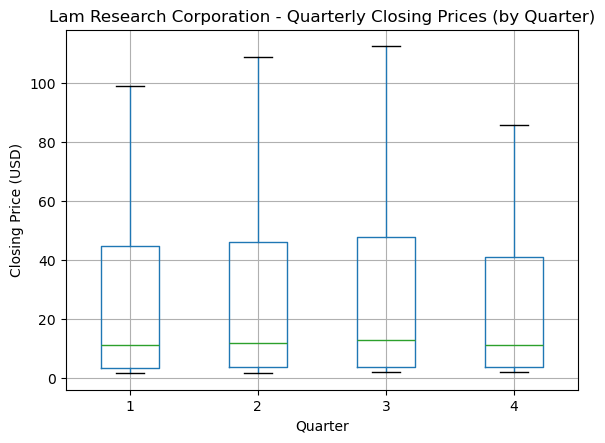


****TOKYO ELECTRON LIMITED****



<Figure size 1200x800 with 0 Axes>

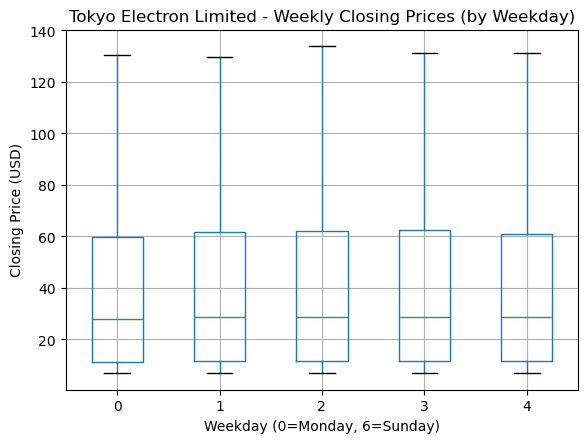

<Figure size 1200x800 with 0 Axes>

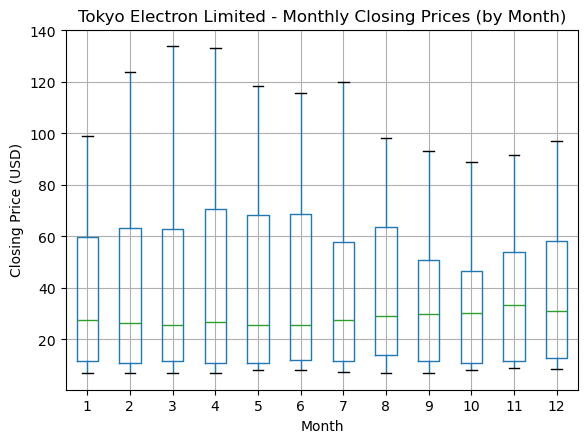

<Figure size 1200x800 with 0 Axes>

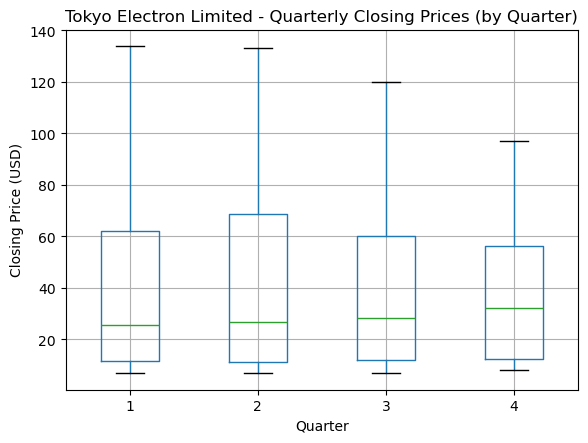

In [11]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_stock_with_multiple_boxplots(merged_data,f'Close_{company}',company)
    print()

With the results above, we cannot determine if there is any clear seasonality for any of the three suppliers. 

### 2.5.5 Choosing the time series of our dataset

Let's chose just the weekly data for the suppliers. To be consistent with the logic with which we viewed ASML's stock data

In [12]:
# Convert the index to a datetime index if it's not already
merged_data.index = pd.to_datetime(merged_data.index)

# Resample the data to weekly frequency and calculate the median
weekly_data_suppliers = merged_data.resample('W').median()

# Display the weekly data
weekly_data_suppliers.head()

,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,Date,Weekday,Month,Quarter
Date,,,,,,,
2013-01-06,25.741581,1.573831,7.766667,2013-01-03 00:00:00,3.0,1.0,1.0
2013-01-13,26.057861,1.553161,7.480000,2013-01-09 00:00:00,2.0,1.0,1.0
2013-01-20,27.226337,1.584166,7.460000,2013-01-16 00:00:00,2.0,1.0,1.0
2013-01-27,27.674398,1.657339,7.406667,2013-01-23 12:00:00,2.5,1.0,1.0
2013-02-03,28.728661,1.724724,7.140000,2013-01-30 00:00:00,2.0,1.0,1.0


### 2.5.6 Prophet model for each supplier

#### 2.5.6.1 Train-test split

In [13]:
# Drop unnecessary columns from the dataframe
weekly_data_suppliers = weekly_data_suppliers.drop(columns=['Date', 'Weekday', 'Month', 'Quarter'], axis=1)

In [14]:
# Create dictionaries to store train and test dataframes for each company
train_dataframes = {}
test_dataframes = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Filter only the columns corresponding to the current company
    company_data = weekly_data_suppliers[[f'Close_{company}']]
    
    # Rename the column to 'Close'
    company_data.columns = ['Close']
    
    # Create train and test dataframes
    train_dataframes[company] = company_data[:-test_weeks]
    test_dataframes[company] = company_data[-test_weeks:]
    
    # Set 'Date' as the index of the dataframe
    train_dataframes[company].index.name = 'Date'
    test_dataframes[company].index.name = 'Date'

# Display the train dataframe for 'Carl Zeiss Meditec' as an example
train_dataframes['Carl Zeiss Meditec'].head()

,Close
Date,
2013-01-06,25.741581
2013-01-13,26.057861
2013-01-20,27.226337
2013-01-27,27.674398
2013-02-03,28.728661


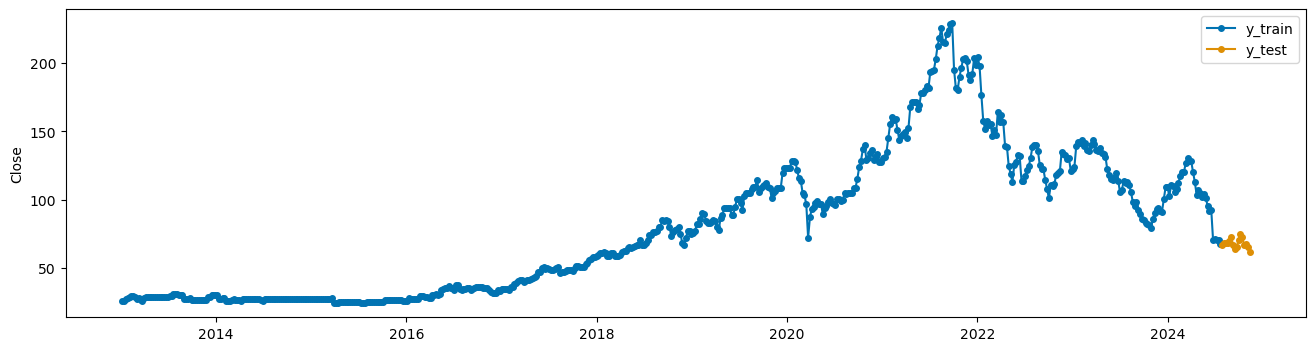

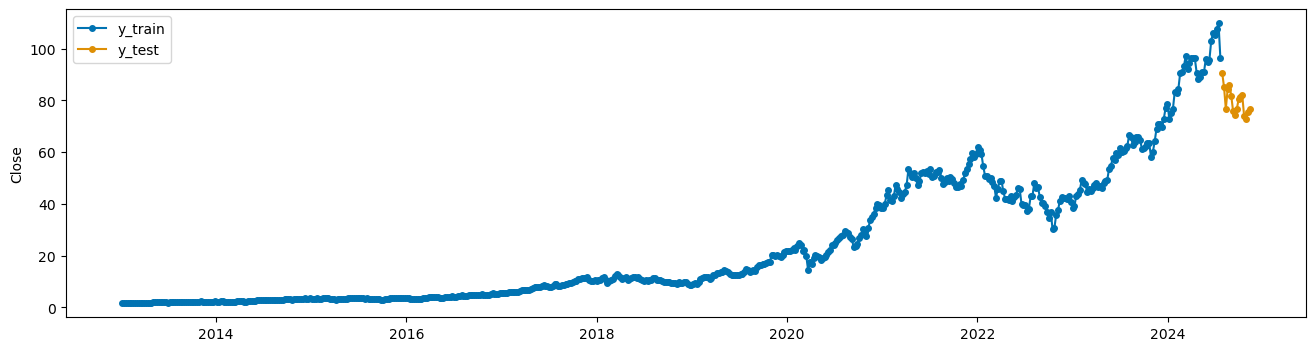

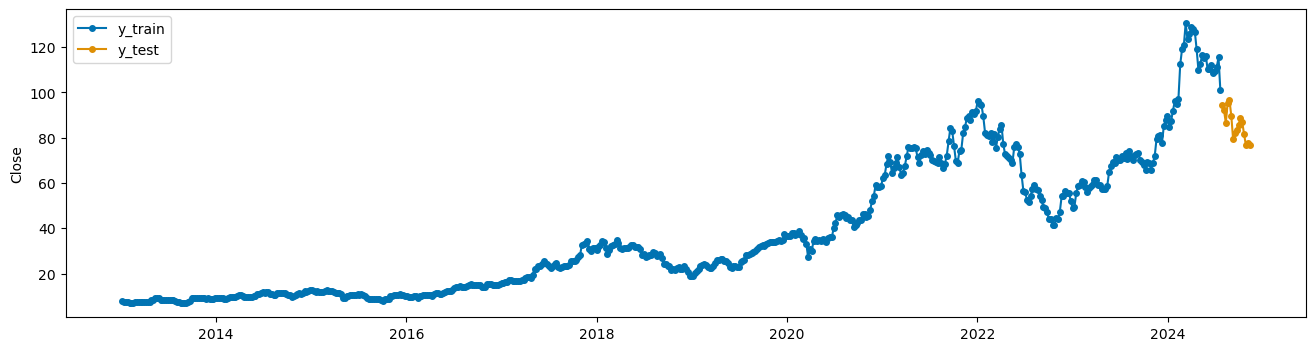

In [15]:
# Iterate over each company to plot the series
for company in company_tickers.values():
    # Extract the train and test data for the current company
    train_data = train_dataframes[company]
    test_data = test_dataframes[company]
    
    # Plot the series for the current company
    plot_series(train_data, test_data, labels=["y_train", "y_test"])

#### 2.5.6.2 Prophet models

23:19:04 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Carl Zeiss Meditec
MAPE: 15.20
RMSE: 11.60


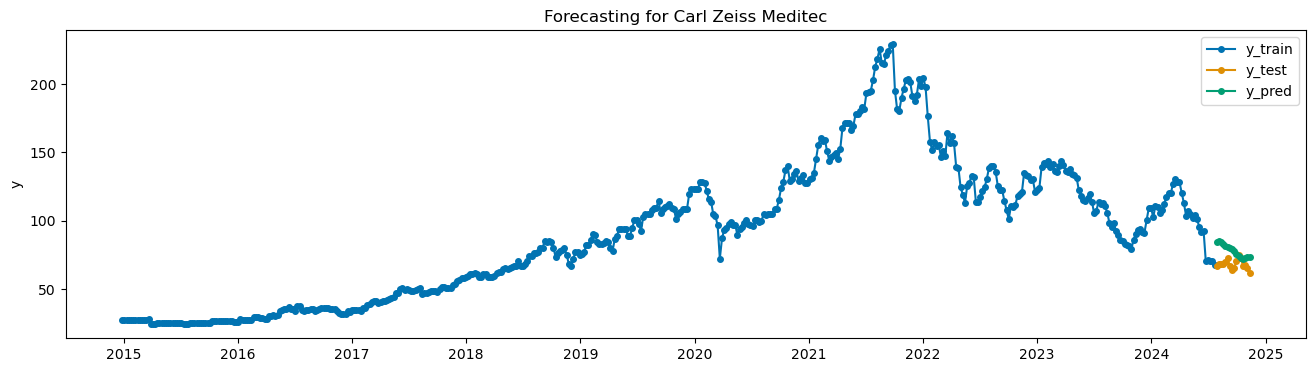

23:19:05 - cmdstanpy - INFO - Chain [1] start processing
23:19:05 - cmdstanpy - INFO - Chain [1] done processing
23:19:05 - cmdstanpy - INFO - Chain [1] start processing
23:19:05 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Lam Research Corporation
MAPE: 7.52
RMSE: 6.83


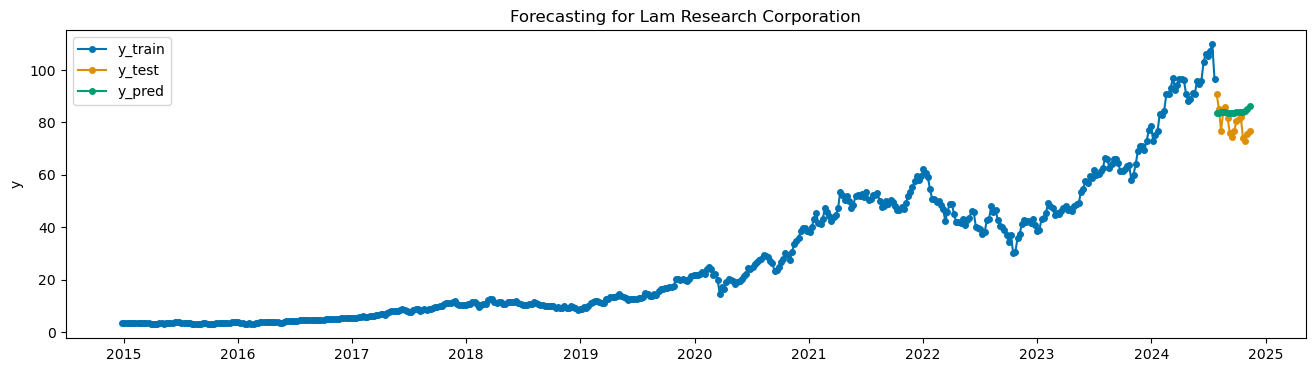

23:19:05 - cmdstanpy - INFO - Chain [1] start processing
23:19:05 - cmdstanpy - INFO - Chain [1] done processing
23:19:05 - cmdstanpy - INFO - Chain [1] start processing
23:19:06 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Tokyo Electron Limited
MAPE: 9.81
RMSE: 9.71


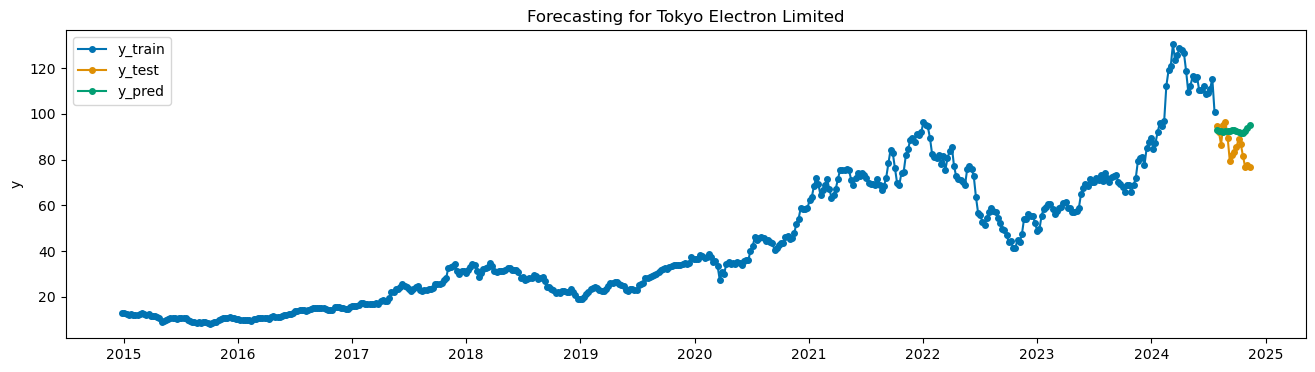

23:19:06 - cmdstanpy - INFO - Chain [1] start processing
23:19:06 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Dictionary to store each Prophet model by company
prophet_models = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Prepare the data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure DatetimeIndex
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    # Initialize and fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(train_data_prophet)

    # Define the forecast horizon (e.g., 12 periods into the future)
    future = prophet_model.make_future_dataframe(periods=test_weeks, freq='W')

    # Generate the predictions
    forecast = prophet_model.predict(future)

    # Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
    forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    # Ensure 'ds' is the index of train_data_prophet 
    train_data_prophet = train_data_prophet.set_index('ds')

    # Calculate MAPE and RMSE errors
    actuals = test_dataframes[company]['Close']  # Actual values from test data
    predictions = forecast['Close']              # Predicted values from forecast

    # Ensure the indices of actuals and predictions align
    common_index = actuals.index.intersection(predictions.index)
    actuals = actuals.loc[common_index]
    predictions = predictions.loc[common_index]

    mape = mean_absolute_percentage_error(actuals, predictions)*100
    rmse = root_mean_squared_error(actuals, predictions)

    # Display errors
    print(f'Forecasting for {company}')
    print(f'MAPE: {mape:.2f}')
    print(f'RMSE: {rmse:.2f}')
    
    # Plot the forecast results
    plot_series(
        train_data_prophet[-500:],  # Only pass the 'Close' column for training data
        test_dataframes[company],   # Only pass the 'Close' column for test data
        forecast,                   # Only pass the 'Close' column for forecast
        labels=["y_train", "y_test", "y_pred"]
    )
    
    plt.title(f'Forecasting for {company}')  # Add title for better clarity
    plt.show()  # Show the plot before moving to the next company
    
    # We need are now going to save the prophet_models only that this time, we will fit it with all the data (train and test data) 
    # Initialize the Prophet model
    prophet_model = Prophet()
    # We have modified the data to be able to train the prophet model
    test_data = pd.DataFrame(actuals).rename(columns={'Close':'y'}).reset_index(names="ds")
    train_data_prophet = train_data_prophet.reset_index(names="ds")
    all_data = pd.concat([train_data_prophet,test_data])
    prophet_model.fit(all_data)
    
    # Store the model in the dictionary with the company name as key
    prophet_models[company] = prophet_model

#### 2.5.6.3 Fine-tunning the prophet models

23:19:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1 of 480 for Carl Zeiss Meditec...


23:19:06 - cmdstanpy - INFO - Chain [1] done processing
23:19:06 - cmdstanpy - INFO - Chain [1] start processing
23:19:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2 of 480 for Carl Zeiss Meditec...


23:19:07 - cmdstanpy - INFO - Chain [1] start processing
23:19:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3 of 480 for Carl Zeiss Meditec...


23:19:07 - cmdstanpy - INFO - Chain [1] start processing
23:19:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 4 of 480 for Carl Zeiss Meditec...


23:19:07 - cmdstanpy - INFO - Chain [1] start processing
23:19:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 5 of 480 for Carl Zeiss Meditec...


23:19:07 - cmdstanpy - INFO - Chain [1] start processing
23:19:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 6 of 480 for Carl Zeiss Meditec...


23:19:08 - cmdstanpy - INFO - Chain [1] start processing
23:19:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 7 of 480 for Carl Zeiss Meditec...


23:19:08 - cmdstanpy - INFO - Chain [1] start processing
23:19:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 8 of 480 for Carl Zeiss Meditec...


23:19:08 - cmdstanpy - INFO - Chain [1] start processing
23:19:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 9 of 480 for Carl Zeiss Meditec...


23:19:09 - cmdstanpy - INFO - Chain [1] start processing
23:19:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 10 of 480 for Carl Zeiss Meditec...


23:19:09 - cmdstanpy - INFO - Chain [1] start processing
23:19:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 11 of 480 for Carl Zeiss Meditec...


23:19:09 - cmdstanpy - INFO - Chain [1] start processing
23:19:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 12 of 480 for Carl Zeiss Meditec...
Processing combination 13 of 480 for Carl Zeiss Meditec...


23:19:09 - cmdstanpy - INFO - Chain [1] start processing
23:19:09 - cmdstanpy - INFO - Chain [1] done processing
23:19:10 - cmdstanpy - INFO - Chain [1] start processing
23:19:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 14 of 480 for Carl Zeiss Meditec...


23:19:10 - cmdstanpy - INFO - Chain [1] start processing
23:19:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 15 of 480 for Carl Zeiss Meditec...


23:19:10 - cmdstanpy - INFO - Chain [1] start processing
23:19:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 16 of 480 for Carl Zeiss Meditec...


23:19:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 17 of 480 for Carl Zeiss Meditec...


23:19:10 - cmdstanpy - INFO - Chain [1] done processing
23:19:11 - cmdstanpy - INFO - Chain [1] start processing
23:19:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 18 of 480 for Carl Zeiss Meditec...


23:19:11 - cmdstanpy - INFO - Chain [1] start processing
23:19:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 19 of 480 for Carl Zeiss Meditec...


23:19:11 - cmdstanpy - INFO - Chain [1] start processing
23:19:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 20 of 480 for Carl Zeiss Meditec...


23:19:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 21 of 480 for Carl Zeiss Meditec...


23:19:12 - cmdstanpy - INFO - Chain [1] done processing
23:19:12 - cmdstanpy - INFO - Chain [1] start processing
23:19:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 22 of 480 for Carl Zeiss Meditec...


23:19:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 23 of 480 for Carl Zeiss Meditec...


23:19:12 - cmdstanpy - INFO - Chain [1] done processing
23:19:12 - cmdstanpy - INFO - Chain [1] start processing
23:19:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 24 of 480 for Carl Zeiss Meditec...


23:19:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 25 of 480 for Carl Zeiss Meditec...


23:19:13 - cmdstanpy - INFO - Chain [1] done processing
23:19:13 - cmdstanpy - INFO - Chain [1] start processing
23:19:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 26 of 480 for Carl Zeiss Meditec...


23:19:13 - cmdstanpy - INFO - Chain [1] start processing
23:19:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 27 of 480 for Carl Zeiss Meditec...


23:19:13 - cmdstanpy - INFO - Chain [1] start processing
23:19:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 28 of 480 for Carl Zeiss Meditec...


23:19:14 - cmdstanpy - INFO - Chain [1] start processing
23:19:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 29 of 480 for Carl Zeiss Meditec...


23:19:14 - cmdstanpy - INFO - Chain [1] start processing
23:19:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 30 of 480 for Carl Zeiss Meditec...


23:19:14 - cmdstanpy - INFO - Chain [1] start processing
23:19:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 31 of 480 for Carl Zeiss Meditec...


23:19:15 - cmdstanpy - INFO - Chain [1] start processing
23:19:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 32 of 480 for Carl Zeiss Meditec...


23:19:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 33 of 480 for Carl Zeiss Meditec...


23:19:15 - cmdstanpy - INFO - Chain [1] done processing
23:19:15 - cmdstanpy - INFO - Chain [1] start processing
23:19:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 34 of 480 for Carl Zeiss Meditec...


23:19:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 35 of 480 for Carl Zeiss Meditec...


23:19:16 - cmdstanpy - INFO - Chain [1] done processing
23:19:16 - cmdstanpy - INFO - Chain [1] start processing
23:19:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 36 of 480 for Carl Zeiss Meditec...


23:19:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 37 of 480 for Carl Zeiss Meditec...


23:19:16 - cmdstanpy - INFO - Chain [1] done processing
23:19:16 - cmdstanpy - INFO - Chain [1] start processing
23:19:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 38 of 480 for Carl Zeiss Meditec...


23:19:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 39 of 480 for Carl Zeiss Meditec...


23:19:17 - cmdstanpy - INFO - Chain [1] done processing
23:19:17 - cmdstanpy - INFO - Chain [1] start processing
23:19:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 40 of 480 for Carl Zeiss Meditec...


23:19:17 - cmdstanpy - INFO - Chain [1] start processing
23:19:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 41 of 480 for Carl Zeiss Meditec...


23:19:17 - cmdstanpy - INFO - Chain [1] start processing
23:19:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 42 of 480 for Carl Zeiss Meditec...


23:19:18 - cmdstanpy - INFO - Chain [1] start processing
23:19:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 43 of 480 for Carl Zeiss Meditec...


23:19:18 - cmdstanpy - INFO - Chain [1] start processing
23:19:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 44 of 480 for Carl Zeiss Meditec...


23:19:18 - cmdstanpy - INFO - Chain [1] start processing
23:19:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 45 of 480 for Carl Zeiss Meditec...


23:19:18 - cmdstanpy - INFO - Chain [1] start processing
23:19:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 46 of 480 for Carl Zeiss Meditec...
Processing combination 47 of 480 for Carl Zeiss Meditec...


23:19:18 - cmdstanpy - INFO - Chain [1] start processing
23:19:19 - cmdstanpy - INFO - Chain [1] done processing
23:19:19 - cmdstanpy - INFO - Chain [1] start processing
23:19:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 48 of 480 for Carl Zeiss Meditec...
Processing combination 49 of 480 for Carl Zeiss Meditec...


23:19:19 - cmdstanpy - INFO - Chain [1] start processing
23:19:19 - cmdstanpy - INFO - Chain [1] done processing
23:19:19 - cmdstanpy - INFO - Chain [1] start processing
23:19:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 50 of 480 for Carl Zeiss Meditec...


23:19:19 - cmdstanpy - INFO - Chain [1] start processing
23:19:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 51 of 480 for Carl Zeiss Meditec...


23:19:20 - cmdstanpy - INFO - Chain [1] start processing
23:19:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 52 of 480 for Carl Zeiss Meditec...


23:19:20 - cmdstanpy - INFO - Chain [1] start processing
23:19:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 53 of 480 for Carl Zeiss Meditec...


23:19:20 - cmdstanpy - INFO - Chain [1] start processing
23:19:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 54 of 480 for Carl Zeiss Meditec...


23:19:20 - cmdstanpy - INFO - Chain [1] start processing
23:19:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 55 of 480 for Carl Zeiss Meditec...


23:19:20 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 56 of 480 for Carl Zeiss Meditec...
Processing combination 57 of 480 for Carl Zeiss Meditec...


23:19:21 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing
23:19:21 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 58 of 480 for Carl Zeiss Meditec...
Processing combination 59 of 480 for Carl Zeiss Meditec...


23:19:21 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing
23:19:21 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 60 of 480 for Carl Zeiss Meditec...
Processing combination 61 of 480 for Carl Zeiss Meditec...


23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:22 - cmdstanpy - INFO - Chain [1] done processing
23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 62 of 480 for Carl Zeiss Meditec...


23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 63 of 480 for Carl Zeiss Meditec...


23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 64 of 480 for Carl Zeiss Meditec...
Processing combination 65 of 480 for Carl Zeiss Meditec...


23:19:23 - cmdstanpy - INFO - Chain [1] start processing
23:19:23 - cmdstanpy - INFO - Chain [1] done processing
23:19:23 - cmdstanpy - INFO - Chain [1] start processing
23:19:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 66 of 480 for Carl Zeiss Meditec...


23:19:23 - cmdstanpy - INFO - Chain [1] start processing
23:19:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 67 of 480 for Carl Zeiss Meditec...


23:19:23 - cmdstanpy - INFO - Chain [1] start processing
23:19:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 68 of 480 for Carl Zeiss Meditec...


23:19:24 - cmdstanpy - INFO - Chain [1] start processing
23:19:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 69 of 480 for Carl Zeiss Meditec...


23:19:24 - cmdstanpy - INFO - Chain [1] start processing
23:19:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 70 of 480 for Carl Zeiss Meditec...


23:19:24 - cmdstanpy - INFO - Chain [1] start processing
23:19:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 71 of 480 for Carl Zeiss Meditec...


23:19:24 - cmdstanpy - INFO - Chain [1] start processing
23:19:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 72 of 480 for Carl Zeiss Meditec...
Processing combination 73 of 480 for Carl Zeiss Meditec...


23:19:24 - cmdstanpy - INFO - Chain [1] start processing
23:19:25 - cmdstanpy - INFO - Chain [1] done processing
23:19:25 - cmdstanpy - INFO - Chain [1] start processing
23:19:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 74 of 480 for Carl Zeiss Meditec...


23:19:25 - cmdstanpy - INFO - Chain [1] start processing
23:19:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 75 of 480 for Carl Zeiss Meditec...


23:19:25 - cmdstanpy - INFO - Chain [1] start processing
23:19:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 76 of 480 for Carl Zeiss Meditec...
Processing combination 77 of 480 for Carl Zeiss Meditec...


23:19:25 - cmdstanpy - INFO - Chain [1] start processing
23:19:25 - cmdstanpy - INFO - Chain [1] done processing
23:19:26 - cmdstanpy - INFO - Chain [1] start processing
23:19:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 78 of 480 for Carl Zeiss Meditec...


23:19:26 - cmdstanpy - INFO - Chain [1] start processing
23:19:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 79 of 480 for Carl Zeiss Meditec...


23:19:26 - cmdstanpy - INFO - Chain [1] start processing
23:19:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 80 of 480 for Carl Zeiss Meditec...
Processing combination 81 of 480 for Carl Zeiss Meditec...


23:19:26 - cmdstanpy - INFO - Chain [1] start processing
23:19:27 - cmdstanpy - INFO - Chain [1] done processing
23:19:27 - cmdstanpy - INFO - Chain [1] start processing
23:19:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 82 of 480 for Carl Zeiss Meditec...


23:19:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 83 of 480 for Carl Zeiss Meditec...


23:19:27 - cmdstanpy - INFO - Chain [1] done processing
23:19:27 - cmdstanpy - INFO - Chain [1] start processing
23:19:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 84 of 480 for Carl Zeiss Meditec...


23:19:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 85 of 480 for Carl Zeiss Meditec...


23:19:28 - cmdstanpy - INFO - Chain [1] done processing
23:19:28 - cmdstanpy - INFO - Chain [1] start processing
23:19:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 86 of 480 for Carl Zeiss Meditec...


23:19:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 87 of 480 for Carl Zeiss Meditec...


23:19:28 - cmdstanpy - INFO - Chain [1] done processing
23:19:28 - cmdstanpy - INFO - Chain [1] start processing
23:19:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 88 of 480 for Carl Zeiss Meditec...


23:19:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 89 of 480 for Carl Zeiss Meditec...


23:19:29 - cmdstanpy - INFO - Chain [1] done processing
23:19:29 - cmdstanpy - INFO - Chain [1] start processing
23:19:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 90 of 480 for Carl Zeiss Meditec...


23:19:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 91 of 480 for Carl Zeiss Meditec...


23:19:29 - cmdstanpy - INFO - Chain [1] done processing
23:19:30 - cmdstanpy - INFO - Chain [1] start processing
23:19:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 92 of 480 for Carl Zeiss Meditec...


23:19:30 - cmdstanpy - INFO - Chain [1] start processing
23:19:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 93 of 480 for Carl Zeiss Meditec...


23:19:30 - cmdstanpy - INFO - Chain [1] start processing
23:19:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 94 of 480 for Carl Zeiss Meditec...


23:19:30 - cmdstanpy - INFO - Chain [1] start processing
23:19:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 95 of 480 for Carl Zeiss Meditec...


23:19:31 - cmdstanpy - INFO - Chain [1] start processing
23:19:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 96 of 480 for Carl Zeiss Meditec...


23:19:31 - cmdstanpy - INFO - Chain [1] start processing
23:19:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 97 of 480 for Carl Zeiss Meditec...


23:19:31 - cmdstanpy - INFO - Chain [1] start processing
23:19:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 98 of 480 for Carl Zeiss Meditec...


23:19:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 99 of 480 for Carl Zeiss Meditec...


23:19:32 - cmdstanpy - INFO - Chain [1] done processing
23:19:32 - cmdstanpy - INFO - Chain [1] start processing
23:19:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 100 of 480 for Carl Zeiss Meditec...


23:19:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 101 of 480 for Carl Zeiss Meditec...


23:19:32 - cmdstanpy - INFO - Chain [1] done processing
23:19:32 - cmdstanpy - INFO - Chain [1] start processing
23:19:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 102 of 480 for Carl Zeiss Meditec...


23:19:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 103 of 480 for Carl Zeiss Meditec...


23:19:33 - cmdstanpy - INFO - Chain [1] done processing
23:19:33 - cmdstanpy - INFO - Chain [1] start processing
23:19:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 104 of 480 for Carl Zeiss Meditec...


23:19:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 105 of 480 for Carl Zeiss Meditec...


23:19:33 - cmdstanpy - INFO - Chain [1] done processing
23:19:34 - cmdstanpy - INFO - Chain [1] start processing
23:19:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 106 of 480 for Carl Zeiss Meditec...


23:19:34 - cmdstanpy - INFO - Chain [1] start processing
23:19:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 107 of 480 for Carl Zeiss Meditec...


23:19:34 - cmdstanpy - INFO - Chain [1] start processing
23:19:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 108 of 480 for Carl Zeiss Meditec...


23:19:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 109 of 480 for Carl Zeiss Meditec...


23:19:35 - cmdstanpy - INFO - Chain [1] done processing
23:19:35 - cmdstanpy - INFO - Chain [1] start processing
23:19:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 110 of 480 for Carl Zeiss Meditec...


23:19:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 111 of 480 for Carl Zeiss Meditec...


23:19:35 - cmdstanpy - INFO - Chain [1] done processing
23:19:35 - cmdstanpy - INFO - Chain [1] start processing
23:19:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 112 of 480 for Carl Zeiss Meditec...


23:19:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 113 of 480 for Carl Zeiss Meditec...


23:19:36 - cmdstanpy - INFO - Chain [1] done processing
23:19:36 - cmdstanpy - INFO - Chain [1] start processing
23:19:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 114 of 480 for Carl Zeiss Meditec...


23:19:36 - cmdstanpy - INFO - Chain [1] start processing
23:19:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 115 of 480 for Carl Zeiss Meditec...


23:19:36 - cmdstanpy - INFO - Chain [1] start processing
23:19:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 116 of 480 for Carl Zeiss Meditec...


23:19:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 117 of 480 for Carl Zeiss Meditec...


23:19:37 - cmdstanpy - INFO - Chain [1] done processing
23:19:37 - cmdstanpy - INFO - Chain [1] start processing
23:19:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 118 of 480 for Carl Zeiss Meditec...


23:19:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 119 of 480 for Carl Zeiss Meditec...


23:19:37 - cmdstanpy - INFO - Chain [1] done processing
23:19:38 - cmdstanpy - INFO - Chain [1] start processing
23:19:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 120 of 480 for Carl Zeiss Meditec...


23:19:38 - cmdstanpy - INFO - Chain [1] start processing
23:19:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 121 of 480 for Carl Zeiss Meditec...


23:19:38 - cmdstanpy - INFO - Chain [1] start processing
23:19:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 122 of 480 for Carl Zeiss Meditec...


23:19:38 - cmdstanpy - INFO - Chain [1] start processing
23:19:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 123 of 480 for Carl Zeiss Meditec...


23:19:39 - cmdstanpy - INFO - Chain [1] start processing
23:19:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 124 of 480 for Carl Zeiss Meditec...


23:19:39 - cmdstanpy - INFO - Chain [1] start processing
23:19:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 125 of 480 for Carl Zeiss Meditec...


23:19:39 - cmdstanpy - INFO - Chain [1] start processing
23:19:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 126 of 480 for Carl Zeiss Meditec...


23:19:39 - cmdstanpy - INFO - Chain [1] start processing
23:19:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 127 of 480 for Carl Zeiss Meditec...


23:19:40 - cmdstanpy - INFO - Chain [1] start processing
23:19:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 128 of 480 for Carl Zeiss Meditec...


23:19:40 - cmdstanpy - INFO - Chain [1] start processing
23:19:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 129 of 480 for Carl Zeiss Meditec...


23:19:40 - cmdstanpy - INFO - Chain [1] start processing
23:19:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 130 of 480 for Carl Zeiss Meditec...


23:19:40 - cmdstanpy - INFO - Chain [1] start processing
23:19:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 131 of 480 for Carl Zeiss Meditec...


23:19:41 - cmdstanpy - INFO - Chain [1] start processing
23:19:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 132 of 480 for Carl Zeiss Meditec...


23:19:41 - cmdstanpy - INFO - Chain [1] start processing
23:19:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 133 of 480 for Carl Zeiss Meditec...


23:19:41 - cmdstanpy - INFO - Chain [1] start processing
23:19:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 134 of 480 for Carl Zeiss Meditec...


23:19:41 - cmdstanpy - INFO - Chain [1] start processing
23:19:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 135 of 480 for Carl Zeiss Meditec...


23:19:42 - cmdstanpy - INFO - Chain [1] start processing
23:19:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 136 of 480 for Carl Zeiss Meditec...


23:19:42 - cmdstanpy - INFO - Chain [1] start processing
23:19:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 137 of 480 for Carl Zeiss Meditec...


23:19:42 - cmdstanpy - INFO - Chain [1] start processing
23:19:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 138 of 480 for Carl Zeiss Meditec...


23:19:42 - cmdstanpy - INFO - Chain [1] start processing
23:19:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 139 of 480 for Carl Zeiss Meditec...


23:19:43 - cmdstanpy - INFO - Chain [1] start processing
23:19:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 140 of 480 for Carl Zeiss Meditec...


23:19:43 - cmdstanpy - INFO - Chain [1] start processing
23:19:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 141 of 480 for Carl Zeiss Meditec...


23:19:43 - cmdstanpy - INFO - Chain [1] start processing
23:19:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 142 of 480 for Carl Zeiss Meditec...


23:19:43 - cmdstanpy - INFO - Chain [1] start processing
23:19:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 143 of 480 for Carl Zeiss Meditec...


23:19:44 - cmdstanpy - INFO - Chain [1] start processing
23:19:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 144 of 480 for Carl Zeiss Meditec...


23:19:44 - cmdstanpy - INFO - Chain [1] start processing
23:19:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 145 of 480 for Carl Zeiss Meditec...


23:19:44 - cmdstanpy - INFO - Chain [1] start processing
23:19:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 146 of 480 for Carl Zeiss Meditec...


23:19:45 - cmdstanpy - INFO - Chain [1] start processing
23:19:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 147 of 480 for Carl Zeiss Meditec...


23:19:45 - cmdstanpy - INFO - Chain [1] start processing
23:19:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 148 of 480 for Carl Zeiss Meditec...


23:19:45 - cmdstanpy - INFO - Chain [1] start processing
23:19:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 149 of 480 for Carl Zeiss Meditec...


23:19:45 - cmdstanpy - INFO - Chain [1] start processing
23:19:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 150 of 480 for Carl Zeiss Meditec...


23:19:46 - cmdstanpy - INFO - Chain [1] start processing
23:19:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 151 of 480 for Carl Zeiss Meditec...


23:19:46 - cmdstanpy - INFO - Chain [1] start processing
23:19:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 152 of 480 for Carl Zeiss Meditec...


23:19:46 - cmdstanpy - INFO - Chain [1] start processing
23:19:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 153 of 480 for Carl Zeiss Meditec...


23:19:46 - cmdstanpy - INFO - Chain [1] start processing
23:19:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 154 of 480 for Carl Zeiss Meditec...


23:19:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 155 of 480 for Carl Zeiss Meditec...


23:19:47 - cmdstanpy - INFO - Chain [1] done processing
23:19:47 - cmdstanpy - INFO - Chain [1] start processing
23:19:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 156 of 480 for Carl Zeiss Meditec...
Processing combination 157 of 480 for Carl Zeiss Meditec...


23:19:47 - cmdstanpy - INFO - Chain [1] start processing
23:19:47 - cmdstanpy - INFO - Chain [1] done processing
23:19:47 - cmdstanpy - INFO - Chain [1] start processing
23:19:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 158 of 480 for Carl Zeiss Meditec...


23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 159 of 480 for Carl Zeiss Meditec...


23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 160 of 480 for Carl Zeiss Meditec...


23:19:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 161 of 480 for Carl Zeiss Meditec...


23:19:48 - cmdstanpy - INFO - Chain [1] done processing
23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 162 of 480 for Carl Zeiss Meditec...


23:19:49 - cmdstanpy - INFO - Chain [1] start processing
23:19:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 163 of 480 for Carl Zeiss Meditec...


23:19:49 - cmdstanpy - INFO - Chain [1] start processing
23:19:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 164 of 480 for Carl Zeiss Meditec...


23:19:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 165 of 480 for Carl Zeiss Meditec...


23:19:49 - cmdstanpy - INFO - Chain [1] done processing
23:19:50 - cmdstanpy - INFO - Chain [1] start processing
23:19:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 166 of 480 for Carl Zeiss Meditec...


23:19:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 167 of 480 for Carl Zeiss Meditec...


23:19:50 - cmdstanpy - INFO - Chain [1] done processing
23:19:50 - cmdstanpy - INFO - Chain [1] start processing
23:19:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 168 of 480 for Carl Zeiss Meditec...


23:19:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 169 of 480 for Carl Zeiss Meditec...


23:19:51 - cmdstanpy - INFO - Chain [1] done processing
23:19:51 - cmdstanpy - INFO - Chain [1] start processing
23:19:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 170 of 480 for Carl Zeiss Meditec...


23:19:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 171 of 480 for Carl Zeiss Meditec...


23:19:51 - cmdstanpy - INFO - Chain [1] done processing
23:19:51 - cmdstanpy - INFO - Chain [1] start processing
23:19:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 172 of 480 for Carl Zeiss Meditec...


23:19:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 173 of 480 for Carl Zeiss Meditec...


23:19:52 - cmdstanpy - INFO - Chain [1] done processing
23:19:52 - cmdstanpy - INFO - Chain [1] start processing
23:19:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 174 of 480 for Carl Zeiss Meditec...


23:19:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 175 of 480 for Carl Zeiss Meditec...


23:19:52 - cmdstanpy - INFO - Chain [1] done processing
23:19:52 - cmdstanpy - INFO - Chain [1] start processing
23:19:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 176 of 480 for Carl Zeiss Meditec...


23:19:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 177 of 480 for Carl Zeiss Meditec...


23:19:53 - cmdstanpy - INFO - Chain [1] done processing
23:19:53 - cmdstanpy - INFO - Chain [1] start processing
23:19:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 178 of 480 for Carl Zeiss Meditec...


23:19:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 179 of 480 for Carl Zeiss Meditec...


23:19:53 - cmdstanpy - INFO - Chain [1] done processing
23:19:54 - cmdstanpy - INFO - Chain [1] start processing
23:19:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 180 of 480 for Carl Zeiss Meditec...


23:19:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 181 of 480 for Carl Zeiss Meditec...


23:19:54 - cmdstanpy - INFO - Chain [1] done processing
23:19:54 - cmdstanpy - INFO - Chain [1] start processing
23:19:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 182 of 480 for Carl Zeiss Meditec...


23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 183 of 480 for Carl Zeiss Meditec...


23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 184 of 480 for Carl Zeiss Meditec...


23:19:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 185 of 480 for Carl Zeiss Meditec...


23:19:55 - cmdstanpy - INFO - Chain [1] done processing
23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 186 of 480 for Carl Zeiss Meditec...


23:19:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 187 of 480 for Carl Zeiss Meditec...


23:19:56 - cmdstanpy - INFO - Chain [1] done processing
23:19:56 - cmdstanpy - INFO - Chain [1] start processing
23:19:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 188 of 480 for Carl Zeiss Meditec...


23:19:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 189 of 480 for Carl Zeiss Meditec...


23:19:56 - cmdstanpy - INFO - Chain [1] done processing
23:19:57 - cmdstanpy - INFO - Chain [1] start processing
23:19:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 190 of 480 for Carl Zeiss Meditec...


23:19:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 191 of 480 for Carl Zeiss Meditec...


23:19:57 - cmdstanpy - INFO - Chain [1] done processing
23:19:57 - cmdstanpy - INFO - Chain [1] start processing
23:19:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 192 of 480 for Carl Zeiss Meditec...


23:19:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 193 of 480 for Carl Zeiss Meditec...


23:19:58 - cmdstanpy - INFO - Chain [1] done processing
23:19:58 - cmdstanpy - INFO - Chain [1] start processing
23:19:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 194 of 480 for Carl Zeiss Meditec...


23:19:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 195 of 480 for Carl Zeiss Meditec...


23:19:58 - cmdstanpy - INFO - Chain [1] done processing
23:19:58 - cmdstanpy - INFO - Chain [1] start processing
23:19:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 196 of 480 for Carl Zeiss Meditec...


23:19:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 197 of 480 for Carl Zeiss Meditec...


23:19:59 - cmdstanpy - INFO - Chain [1] done processing
23:19:59 - cmdstanpy - INFO - Chain [1] start processing
23:19:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 198 of 480 for Carl Zeiss Meditec...


23:19:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 199 of 480 for Carl Zeiss Meditec...


23:20:00 - cmdstanpy - INFO - Chain [1] done processing
23:20:00 - cmdstanpy - INFO - Chain [1] start processing
23:20:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 200 of 480 for Carl Zeiss Meditec...


23:20:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 201 of 480 for Carl Zeiss Meditec...


23:20:00 - cmdstanpy - INFO - Chain [1] done processing
23:20:00 - cmdstanpy - INFO - Chain [1] start processing
23:20:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 202 of 480 for Carl Zeiss Meditec...


23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 203 of 480 for Carl Zeiss Meditec...


23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 204 of 480 for Carl Zeiss Meditec...


23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 205 of 480 for Carl Zeiss Meditec...


23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 206 of 480 for Carl Zeiss Meditec...


23:20:02 - cmdstanpy - INFO - Chain [1] start processing
23:20:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 207 of 480 for Carl Zeiss Meditec...


23:20:02 - cmdstanpy - INFO - Chain [1] start processing
23:20:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 208 of 480 for Carl Zeiss Meditec...


23:20:02 - cmdstanpy - INFO - Chain [1] start processing
23:20:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 209 of 480 for Carl Zeiss Meditec...


23:20:02 - cmdstanpy - INFO - Chain [1] start processing
23:20:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 210 of 480 for Carl Zeiss Meditec...


23:20:03 - cmdstanpy - INFO - Chain [1] start processing
23:20:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 211 of 480 for Carl Zeiss Meditec...


23:20:03 - cmdstanpy - INFO - Chain [1] start processing
23:20:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 212 of 480 for Carl Zeiss Meditec...


23:20:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 213 of 480 for Carl Zeiss Meditec...


23:20:03 - cmdstanpy - INFO - Chain [1] done processing
23:20:03 - cmdstanpy - INFO - Chain [1] start processing
23:20:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 214 of 480 for Carl Zeiss Meditec...


23:20:04 - cmdstanpy - INFO - Chain [1] start processing
23:20:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 215 of 480 for Carl Zeiss Meditec...


23:20:04 - cmdstanpy - INFO - Chain [1] start processing
23:20:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 216 of 480 for Carl Zeiss Meditec...


23:20:04 - cmdstanpy - INFO - Chain [1] start processing
23:20:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 217 of 480 for Carl Zeiss Meditec...


23:20:04 - cmdstanpy - INFO - Chain [1] start processing
23:20:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 218 of 480 for Carl Zeiss Meditec...


23:20:05 - cmdstanpy - INFO - Chain [1] start processing
23:20:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 219 of 480 for Carl Zeiss Meditec...


23:20:05 - cmdstanpy - INFO - Chain [1] start processing
23:20:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 220 of 480 for Carl Zeiss Meditec...


23:20:05 - cmdstanpy - INFO - Chain [1] start processing
23:20:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 221 of 480 for Carl Zeiss Meditec...


23:20:05 - cmdstanpy - INFO - Chain [1] start processing
23:20:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 222 of 480 for Carl Zeiss Meditec...


23:20:06 - cmdstanpy - INFO - Chain [1] start processing
23:20:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 223 of 480 for Carl Zeiss Meditec...


23:20:06 - cmdstanpy - INFO - Chain [1] start processing
23:20:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 224 of 480 for Carl Zeiss Meditec...


23:20:06 - cmdstanpy - INFO - Chain [1] start processing
23:20:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 225 of 480 for Carl Zeiss Meditec...


23:20:06 - cmdstanpy - INFO - Chain [1] start processing
23:20:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 226 of 480 for Carl Zeiss Meditec...


23:20:07 - cmdstanpy - INFO - Chain [1] start processing
23:20:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 227 of 480 for Carl Zeiss Meditec...


23:20:07 - cmdstanpy - INFO - Chain [1] start processing
23:20:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 228 of 480 for Carl Zeiss Meditec...


23:20:07 - cmdstanpy - INFO - Chain [1] start processing
23:20:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 229 of 480 for Carl Zeiss Meditec...


23:20:07 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 230 of 480 for Carl Zeiss Meditec...


23:20:08 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 231 of 480 for Carl Zeiss Meditec...


23:20:08 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 232 of 480 for Carl Zeiss Meditec...


23:20:08 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 233 of 480 for Carl Zeiss Meditec...


23:20:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 234 of 480 for Carl Zeiss Meditec...


23:20:09 - cmdstanpy - INFO - Chain [1] done processing
23:20:09 - cmdstanpy - INFO - Chain [1] start processing
23:20:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 235 of 480 for Carl Zeiss Meditec...


23:20:09 - cmdstanpy - INFO - Chain [1] start processing
23:20:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 236 of 480 for Carl Zeiss Meditec...


23:20:09 - cmdstanpy - INFO - Chain [1] start processing
23:20:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 237 of 480 for Carl Zeiss Meditec...


23:20:10 - cmdstanpy - INFO - Chain [1] start processing
23:20:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 238 of 480 for Carl Zeiss Meditec...


23:20:10 - cmdstanpy - INFO - Chain [1] start processing
23:20:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 239 of 480 for Carl Zeiss Meditec...


23:20:10 - cmdstanpy - INFO - Chain [1] start processing
23:20:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 240 of 480 for Carl Zeiss Meditec...


23:20:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 241 of 480 for Carl Zeiss Meditec...


23:20:11 - cmdstanpy - INFO - Chain [1] done processing
23:20:11 - cmdstanpy - INFO - Chain [1] start processing
23:20:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 242 of 480 for Carl Zeiss Meditec...


23:20:11 - cmdstanpy - INFO - Chain [1] start processing
23:20:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 243 of 480 for Carl Zeiss Meditec...


23:20:11 - cmdstanpy - INFO - Chain [1] start processing
23:20:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 244 of 480 for Carl Zeiss Meditec...


23:20:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 245 of 480 for Carl Zeiss Meditec...


23:20:12 - cmdstanpy - INFO - Chain [1] done processing
23:20:12 - cmdstanpy - INFO - Chain [1] start processing
23:20:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 246 of 480 for Carl Zeiss Meditec...


23:20:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 247 of 480 for Carl Zeiss Meditec...


23:20:12 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 248 of 480 for Carl Zeiss Meditec...


23:20:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 249 of 480 for Carl Zeiss Meditec...


23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 250 of 480 for Carl Zeiss Meditec...


23:20:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 251 of 480 for Carl Zeiss Meditec...


23:20:14 - cmdstanpy - INFO - Chain [1] done processing
23:20:14 - cmdstanpy - INFO - Chain [1] start processing
23:20:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 252 of 480 for Carl Zeiss Meditec...


23:20:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 253 of 480 for Carl Zeiss Meditec...


23:20:14 - cmdstanpy - INFO - Chain [1] done processing
23:20:14 - cmdstanpy - INFO - Chain [1] start processing
23:20:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 254 of 480 for Carl Zeiss Meditec...


23:20:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 255 of 480 for Carl Zeiss Meditec...


23:20:15 - cmdstanpy - INFO - Chain [1] done processing
23:20:15 - cmdstanpy - INFO - Chain [1] start processing
23:20:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 256 of 480 for Carl Zeiss Meditec...


23:20:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 257 of 480 for Carl Zeiss Meditec...


23:20:15 - cmdstanpy - INFO - Chain [1] done processing
23:20:16 - cmdstanpy - INFO - Chain [1] start processing
23:20:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 258 of 480 for Carl Zeiss Meditec...


23:20:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 259 of 480 for Carl Zeiss Meditec...


23:20:16 - cmdstanpy - INFO - Chain [1] done processing
23:20:16 - cmdstanpy - INFO - Chain [1] start processing
23:20:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 260 of 480 for Carl Zeiss Meditec...


23:20:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 261 of 480 for Carl Zeiss Meditec...


23:20:17 - cmdstanpy - INFO - Chain [1] done processing
23:20:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 262 of 480 for Carl Zeiss Meditec...


23:20:17 - cmdstanpy - INFO - Chain [1] done processing
23:20:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 263 of 480 for Carl Zeiss Meditec...


23:20:17 - cmdstanpy - INFO - Chain [1] done processing
23:20:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 264 of 480 for Carl Zeiss Meditec...


23:20:18 - cmdstanpy - INFO - Chain [1] done processing
23:20:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 265 of 480 for Carl Zeiss Meditec...


23:20:18 - cmdstanpy - INFO - Chain [1] done processing
23:20:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 266 of 480 for Carl Zeiss Meditec...


23:20:19 - cmdstanpy - INFO - Chain [1] done processing
23:20:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 267 of 480 for Carl Zeiss Meditec...


23:20:19 - cmdstanpy - INFO - Chain [1] done processing
23:20:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 268 of 480 for Carl Zeiss Meditec...


23:20:19 - cmdstanpy - INFO - Chain [1] done processing
23:20:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 269 of 480 for Carl Zeiss Meditec...


23:20:20 - cmdstanpy - INFO - Chain [1] done processing
23:20:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 270 of 480 for Carl Zeiss Meditec...


23:20:20 - cmdstanpy - INFO - Chain [1] done processing
23:20:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 271 of 480 for Carl Zeiss Meditec...


23:20:20 - cmdstanpy - INFO - Chain [1] done processing
23:20:21 - cmdstanpy - INFO - Chain [1] start processing
23:20:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 272 of 480 for Carl Zeiss Meditec...


23:20:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 273 of 480 for Carl Zeiss Meditec...


23:20:21 - cmdstanpy - INFO - Chain [1] done processing
23:20:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 274 of 480 for Carl Zeiss Meditec...


23:20:22 - cmdstanpy - INFO - Chain [1] done processing
23:20:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 275 of 480 for Carl Zeiss Meditec...


23:20:22 - cmdstanpy - INFO - Chain [1] done processing
23:20:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 276 of 480 for Carl Zeiss Meditec...


23:20:22 - cmdstanpy - INFO - Chain [1] done processing
23:20:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 277 of 480 for Carl Zeiss Meditec...


23:20:23 - cmdstanpy - INFO - Chain [1] done processing
23:20:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 278 of 480 for Carl Zeiss Meditec...


23:20:23 - cmdstanpy - INFO - Chain [1] done processing
23:20:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 279 of 480 for Carl Zeiss Meditec...


23:20:24 - cmdstanpy - INFO - Chain [1] done processing
23:20:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 280 of 480 for Carl Zeiss Meditec...


23:20:24 - cmdstanpy - INFO - Chain [1] done processing
23:20:24 - cmdstanpy - INFO - Chain [1] start processing
23:20:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 281 of 480 for Carl Zeiss Meditec...


23:20:24 - cmdstanpy - INFO - Chain [1] start processing
23:20:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 282 of 480 for Carl Zeiss Meditec...


23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 283 of 480 for Carl Zeiss Meditec...


23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 284 of 480 for Carl Zeiss Meditec...


23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 285 of 480 for Carl Zeiss Meditec...


23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 286 of 480 for Carl Zeiss Meditec...


23:20:26 - cmdstanpy - INFO - Chain [1] start processing
23:20:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 287 of 480 for Carl Zeiss Meditec...


23:20:26 - cmdstanpy - INFO - Chain [1] start processing
23:20:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 288 of 480 for Carl Zeiss Meditec...


23:20:26 - cmdstanpy - INFO - Chain [1] start processing
23:20:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 289 of 480 for Carl Zeiss Meditec...


23:20:26 - cmdstanpy - INFO - Chain [1] start processing
23:20:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 290 of 480 for Carl Zeiss Meditec...


23:20:27 - cmdstanpy - INFO - Chain [1] start processing
23:20:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 291 of 480 for Carl Zeiss Meditec...


23:20:27 - cmdstanpy - INFO - Chain [1] start processing
23:20:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 292 of 480 for Carl Zeiss Meditec...


23:20:27 - cmdstanpy - INFO - Chain [1] start processing
23:20:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 293 of 480 for Carl Zeiss Meditec...


23:20:27 - cmdstanpy - INFO - Chain [1] start processing
23:20:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 294 of 480 for Carl Zeiss Meditec...


23:20:28 - cmdstanpy - INFO - Chain [1] start processing
23:20:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 295 of 480 for Carl Zeiss Meditec...


23:20:28 - cmdstanpy - INFO - Chain [1] start processing
23:20:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 296 of 480 for Carl Zeiss Meditec...


23:20:28 - cmdstanpy - INFO - Chain [1] start processing
23:20:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 297 of 480 for Carl Zeiss Meditec...


23:20:28 - cmdstanpy - INFO - Chain [1] start processing
23:20:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 298 of 480 for Carl Zeiss Meditec...


23:20:29 - cmdstanpy - INFO - Chain [1] start processing
23:20:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 299 of 480 for Carl Zeiss Meditec...


23:20:29 - cmdstanpy - INFO - Chain [1] start processing
23:20:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 300 of 480 for Carl Zeiss Meditec...


23:20:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 301 of 480 for Carl Zeiss Meditec...


23:20:29 - cmdstanpy - INFO - Chain [1] done processing
23:20:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 302 of 480 for Carl Zeiss Meditec...


23:20:30 - cmdstanpy - INFO - Chain [1] done processing
23:20:30 - cmdstanpy - INFO - Chain [1] start processing
23:20:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 303 of 480 for Carl Zeiss Meditec...


23:20:30 - cmdstanpy - INFO - Chain [1] start processing
23:20:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 304 of 480 for Carl Zeiss Meditec...


23:20:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 305 of 480 for Carl Zeiss Meditec...


23:20:31 - cmdstanpy - INFO - Chain [1] done processing
23:20:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 306 of 480 for Carl Zeiss Meditec...


23:20:31 - cmdstanpy - INFO - Chain [1] done processing
23:20:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 307 of 480 for Carl Zeiss Meditec...


23:20:31 - cmdstanpy - INFO - Chain [1] done processing
23:20:31 - cmdstanpy - INFO - Chain [1] start processing
23:20:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 308 of 480 for Carl Zeiss Meditec...


23:20:32 - cmdstanpy - INFO - Chain [1] start processing
23:20:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 309 of 480 for Carl Zeiss Meditec...


23:20:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 310 of 480 for Carl Zeiss Meditec...


23:20:32 - cmdstanpy - INFO - Chain [1] done processing
23:20:32 - cmdstanpy - INFO - Chain [1] start processing
23:20:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 311 of 480 for Carl Zeiss Meditec...


23:20:33 - cmdstanpy - INFO - Chain [1] start processing
23:20:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 312 of 480 for Carl Zeiss Meditec...


23:20:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 313 of 480 for Carl Zeiss Meditec...


23:20:33 - cmdstanpy - INFO - Chain [1] done processing
23:20:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 314 of 480 for Carl Zeiss Meditec...


23:20:33 - cmdstanpy - INFO - Chain [1] done processing
23:20:33 - cmdstanpy - INFO - Chain [1] start processing
23:20:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 315 of 480 for Carl Zeiss Meditec...


23:20:34 - cmdstanpy - INFO - Chain [1] start processing
23:20:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 316 of 480 for Carl Zeiss Meditec...


23:20:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 317 of 480 for Carl Zeiss Meditec...


23:20:34 - cmdstanpy - INFO - Chain [1] done processing
23:20:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 318 of 480 for Carl Zeiss Meditec...


23:20:34 - cmdstanpy - INFO - Chain [1] done processing
23:20:35 - cmdstanpy - INFO - Chain [1] start processing
23:20:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 319 of 480 for Carl Zeiss Meditec...


23:20:35 - cmdstanpy - INFO - Chain [1] start processing
23:20:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 320 of 480 for Carl Zeiss Meditec...
Processing combination 321 of 480 for Carl Zeiss Meditec...


23:20:35 - cmdstanpy - INFO - Chain [1] start processing
23:20:35 - cmdstanpy - INFO - Chain [1] done processing
23:20:35 - cmdstanpy - INFO - Chain [1] start processing
23:20:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 322 of 480 for Carl Zeiss Meditec...


23:20:36 - cmdstanpy - INFO - Chain [1] start processing
23:20:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 323 of 480 for Carl Zeiss Meditec...


23:20:36 - cmdstanpy - INFO - Chain [1] start processing
23:20:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 324 of 480 for Carl Zeiss Meditec...


23:20:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 325 of 480 for Carl Zeiss Meditec...


23:20:36 - cmdstanpy - INFO - Chain [1] done processing
23:20:37 - cmdstanpy - INFO - Chain [1] start processing
23:20:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 326 of 480 for Carl Zeiss Meditec...


23:20:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 327 of 480 for Carl Zeiss Meditec...


23:20:37 - cmdstanpy - INFO - Chain [1] done processing
23:20:37 - cmdstanpy - INFO - Chain [1] start processing
23:20:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 328 of 480 for Carl Zeiss Meditec...


23:20:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 329 of 480 for Carl Zeiss Meditec...


23:20:38 - cmdstanpy - INFO - Chain [1] done processing
23:20:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 330 of 480 for Carl Zeiss Meditec...


23:20:38 - cmdstanpy - INFO - Chain [1] done processing
23:20:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 331 of 480 for Carl Zeiss Meditec...


23:20:38 - cmdstanpy - INFO - Chain [1] done processing
23:20:38 - cmdstanpy - INFO - Chain [1] start processing
23:20:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 332 of 480 for Carl Zeiss Meditec...


23:20:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 333 of 480 for Carl Zeiss Meditec...


23:20:39 - cmdstanpy - INFO - Chain [1] done processing
23:20:39 - cmdstanpy - INFO - Chain [1] start processing
23:20:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 334 of 480 for Carl Zeiss Meditec...


23:20:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 335 of 480 for Carl Zeiss Meditec...


23:20:40 - cmdstanpy - INFO - Chain [1] done processing
23:20:40 - cmdstanpy - INFO - Chain [1] start processing
23:20:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 336 of 480 for Carl Zeiss Meditec...


23:20:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 337 of 480 for Carl Zeiss Meditec...


23:20:40 - cmdstanpy - INFO - Chain [1] done processing
23:20:40 - cmdstanpy - INFO - Chain [1] start processing
23:20:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 338 of 480 for Carl Zeiss Meditec...


23:20:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 339 of 480 for Carl Zeiss Meditec...


23:20:41 - cmdstanpy - INFO - Chain [1] done processing
23:20:41 - cmdstanpy - INFO - Chain [1] start processing
23:20:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 340 of 480 for Carl Zeiss Meditec...


23:20:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 341 of 480 for Carl Zeiss Meditec...


23:20:41 - cmdstanpy - INFO - Chain [1] done processing
23:20:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 342 of 480 for Carl Zeiss Meditec...


23:20:42 - cmdstanpy - INFO - Chain [1] done processing
23:20:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 343 of 480 for Carl Zeiss Meditec...


23:20:42 - cmdstanpy - INFO - Chain [1] done processing
23:20:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 344 of 480 for Carl Zeiss Meditec...


23:20:42 - cmdstanpy - INFO - Chain [1] done processing
23:20:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 345 of 480 for Carl Zeiss Meditec...


23:20:43 - cmdstanpy - INFO - Chain [1] done processing
23:20:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 346 of 480 for Carl Zeiss Meditec...


23:20:43 - cmdstanpy - INFO - Chain [1] done processing
23:20:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 347 of 480 for Carl Zeiss Meditec...


23:20:44 - cmdstanpy - INFO - Chain [1] done processing
23:20:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 348 of 480 for Carl Zeiss Meditec...


23:20:44 - cmdstanpy - INFO - Chain [1] done processing
23:20:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 349 of 480 for Carl Zeiss Meditec...


23:20:44 - cmdstanpy - INFO - Chain [1] done processing
23:20:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 350 of 480 for Carl Zeiss Meditec...


23:20:45 - cmdstanpy - INFO - Chain [1] done processing
23:20:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 351 of 480 for Carl Zeiss Meditec...


23:20:45 - cmdstanpy - INFO - Chain [1] done processing
23:20:45 - cmdstanpy - INFO - Chain [1] start processing
23:20:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 352 of 480 for Carl Zeiss Meditec...


23:20:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 353 of 480 for Carl Zeiss Meditec...


23:20:46 - cmdstanpy - INFO - Chain [1] done processing
23:20:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 354 of 480 for Carl Zeiss Meditec...


23:20:46 - cmdstanpy - INFO - Chain [1] done processing
23:20:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 355 of 480 for Carl Zeiss Meditec...


23:20:47 - cmdstanpy - INFO - Chain [1] done processing
23:20:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 356 of 480 for Carl Zeiss Meditec...


23:20:47 - cmdstanpy - INFO - Chain [1] done processing
23:20:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 357 of 480 for Carl Zeiss Meditec...


23:20:48 - cmdstanpy - INFO - Chain [1] done processing
23:20:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 358 of 480 for Carl Zeiss Meditec...


23:20:48 - cmdstanpy - INFO - Chain [1] done processing
23:20:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 359 of 480 for Carl Zeiss Meditec...


23:20:48 - cmdstanpy - INFO - Chain [1] done processing
23:20:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 360 of 480 for Carl Zeiss Meditec...


23:20:49 - cmdstanpy - INFO - Chain [1] done processing
23:20:49 - cmdstanpy - INFO - Chain [1] start processing
23:20:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 361 of 480 for Carl Zeiss Meditec...


23:20:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 362 of 480 for Carl Zeiss Meditec...


23:20:49 - cmdstanpy - INFO - Chain [1] done processing
23:20:50 - cmdstanpy - INFO - Chain [1] start processing
23:20:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 363 of 480 for Carl Zeiss Meditec...


23:20:50 - cmdstanpy - INFO - Chain [1] start processing
23:20:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 364 of 480 for Carl Zeiss Meditec...


23:20:50 - cmdstanpy - INFO - Chain [1] start processing
23:20:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 365 of 480 for Carl Zeiss Meditec...


23:20:50 - cmdstanpy - INFO - Chain [1] start processing
23:20:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 366 of 480 for Carl Zeiss Meditec...


23:20:51 - cmdstanpy - INFO - Chain [1] start processing
23:20:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 367 of 480 for Carl Zeiss Meditec...


23:20:51 - cmdstanpy - INFO - Chain [1] start processing
23:20:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 368 of 480 for Carl Zeiss Meditec...


23:20:51 - cmdstanpy - INFO - Chain [1] start processing
23:20:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 369 of 480 for Carl Zeiss Meditec...


23:20:51 - cmdstanpy - INFO - Chain [1] start processing
23:20:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 370 of 480 for Carl Zeiss Meditec...


23:20:52 - cmdstanpy - INFO - Chain [1] start processing
23:20:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 371 of 480 for Carl Zeiss Meditec...


23:20:52 - cmdstanpy - INFO - Chain [1] start processing
23:20:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 372 of 480 for Carl Zeiss Meditec...


23:20:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 373 of 480 for Carl Zeiss Meditec...


23:20:52 - cmdstanpy - INFO - Chain [1] done processing
23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 374 of 480 for Carl Zeiss Meditec...


23:20:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 375 of 480 for Carl Zeiss Meditec...


23:20:53 - cmdstanpy - INFO - Chain [1] done processing
23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 376 of 480 for Carl Zeiss Meditec...


23:20:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 377 of 480 for Carl Zeiss Meditec...


23:20:54 - cmdstanpy - INFO - Chain [1] done processing
23:20:54 - cmdstanpy - INFO - Chain [1] start processing
23:20:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 378 of 480 for Carl Zeiss Meditec...


23:20:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 379 of 480 for Carl Zeiss Meditec...


23:20:54 - cmdstanpy - INFO - Chain [1] done processing
23:20:54 - cmdstanpy - INFO - Chain [1] start processing
23:20:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 380 of 480 for Carl Zeiss Meditec...


23:20:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 381 of 480 for Carl Zeiss Meditec...


23:20:55 - cmdstanpy - INFO - Chain [1] done processing
23:20:55 - cmdstanpy - INFO - Chain [1] start processing
23:20:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 382 of 480 for Carl Zeiss Meditec...


23:20:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 383 of 480 for Carl Zeiss Meditec...


23:20:55 - cmdstanpy - INFO - Chain [1] done processing
23:20:55 - cmdstanpy - INFO - Chain [1] start processing
23:20:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 384 of 480 for Carl Zeiss Meditec...


23:20:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 385 of 480 for Carl Zeiss Meditec...


23:20:56 - cmdstanpy - INFO - Chain [1] done processing
23:20:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 386 of 480 for Carl Zeiss Meditec...


23:20:56 - cmdstanpy - INFO - Chain [1] done processing
23:20:56 - cmdstanpy - INFO - Chain [1] start processing
23:20:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 387 of 480 for Carl Zeiss Meditec...


23:20:57 - cmdstanpy - INFO - Chain [1] start processing
23:20:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 388 of 480 for Carl Zeiss Meditec...


23:20:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 389 of 480 for Carl Zeiss Meditec...


23:20:57 - cmdstanpy - INFO - Chain [1] done processing
23:20:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 390 of 480 for Carl Zeiss Meditec...


23:20:57 - cmdstanpy - INFO - Chain [1] done processing
23:20:58 - cmdstanpy - INFO - Chain [1] start processing
23:20:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 391 of 480 for Carl Zeiss Meditec...


23:20:58 - cmdstanpy - INFO - Chain [1] start processing
23:20:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 392 of 480 for Carl Zeiss Meditec...


23:20:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 393 of 480 for Carl Zeiss Meditec...


23:20:58 - cmdstanpy - INFO - Chain [1] done processing
23:20:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 394 of 480 for Carl Zeiss Meditec...


23:20:59 - cmdstanpy - INFO - Chain [1] done processing
23:20:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 395 of 480 for Carl Zeiss Meditec...


23:20:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 396 of 480 for Carl Zeiss Meditec...


23:20:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 397 of 480 for Carl Zeiss Meditec...


23:21:00 - cmdstanpy - INFO - Chain [1] done processing
23:21:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 398 of 480 for Carl Zeiss Meditec...


23:21:00 - cmdstanpy - INFO - Chain [1] done processing
23:21:00 - cmdstanpy - INFO - Chain [1] start processing
23:21:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 399 of 480 for Carl Zeiss Meditec...


23:21:00 - cmdstanpy - INFO - Chain [1] start processing
23:21:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 400 of 480 for Carl Zeiss Meditec...


23:21:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 401 of 480 for Carl Zeiss Meditec...


23:21:01 - cmdstanpy - INFO - Chain [1] done processing
23:21:01 - cmdstanpy - INFO - Chain [1] start processing
23:21:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 402 of 480 for Carl Zeiss Meditec...


23:21:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 403 of 480 for Carl Zeiss Meditec...


23:21:01 - cmdstanpy - INFO - Chain [1] done processing
23:21:02 - cmdstanpy - INFO - Chain [1] start processing
23:21:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 404 of 480 for Carl Zeiss Meditec...


23:21:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 405 of 480 for Carl Zeiss Meditec...


23:21:02 - cmdstanpy - INFO - Chain [1] done processing
23:21:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 406 of 480 for Carl Zeiss Meditec...


23:21:02 - cmdstanpy - INFO - Chain [1] done processing
23:21:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 407 of 480 for Carl Zeiss Meditec...


23:21:03 - cmdstanpy - INFO - Chain [1] done processing
23:21:03 - cmdstanpy - INFO - Chain [1] start processing
23:21:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 408 of 480 for Carl Zeiss Meditec...


23:21:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 409 of 480 for Carl Zeiss Meditec...


23:21:03 - cmdstanpy - INFO - Chain [1] done processing
23:21:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 410 of 480 for Carl Zeiss Meditec...


23:21:04 - cmdstanpy - INFO - Chain [1] done processing
23:21:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 411 of 480 for Carl Zeiss Meditec...


23:21:04 - cmdstanpy - INFO - Chain [1] done processing
23:21:04 - cmdstanpy - INFO - Chain [1] start processing
23:21:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 412 of 480 for Carl Zeiss Meditec...


23:21:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 413 of 480 for Carl Zeiss Meditec...


23:21:05 - cmdstanpy - INFO - Chain [1] done processing
23:21:05 - cmdstanpy - INFO - Chain [1] start processing
23:21:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 414 of 480 for Carl Zeiss Meditec...


23:21:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 415 of 480 for Carl Zeiss Meditec...


23:21:05 - cmdstanpy - INFO - Chain [1] done processing
23:21:06 - cmdstanpy - INFO - Chain [1] start processing
23:21:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 416 of 480 for Carl Zeiss Meditec...


23:21:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 417 of 480 for Carl Zeiss Meditec...


23:21:06 - cmdstanpy - INFO - Chain [1] done processing
23:21:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 418 of 480 for Carl Zeiss Meditec...


23:21:06 - cmdstanpy - INFO - Chain [1] done processing
23:21:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 419 of 480 for Carl Zeiss Meditec...


23:21:07 - cmdstanpy - INFO - Chain [1] done processing
23:21:07 - cmdstanpy - INFO - Chain [1] start processing
23:21:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 420 of 480 for Carl Zeiss Meditec...


23:21:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 421 of 480 for Carl Zeiss Meditec...


23:21:07 - cmdstanpy - INFO - Chain [1] done processing
23:21:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 422 of 480 for Carl Zeiss Meditec...


23:21:08 - cmdstanpy - INFO - Chain [1] done processing
23:21:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 423 of 480 for Carl Zeiss Meditec...


23:21:08 - cmdstanpy - INFO - Chain [1] done processing
23:21:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 424 of 480 for Carl Zeiss Meditec...


23:21:08 - cmdstanpy - INFO - Chain [1] done processing
23:21:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 425 of 480 for Carl Zeiss Meditec...


23:21:09 - cmdstanpy - INFO - Chain [1] done processing
23:21:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 426 of 480 for Carl Zeiss Meditec...


23:21:09 - cmdstanpy - INFO - Chain [1] done processing
23:21:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 427 of 480 for Carl Zeiss Meditec...


23:21:10 - cmdstanpy - INFO - Chain [1] done processing
23:21:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 428 of 480 for Carl Zeiss Meditec...


23:21:10 - cmdstanpy - INFO - Chain [1] done processing
23:21:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 429 of 480 for Carl Zeiss Meditec...


23:21:10 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 430 of 480 for Carl Zeiss Meditec...


23:21:11 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 431 of 480 for Carl Zeiss Meditec...


23:21:11 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 432 of 480 for Carl Zeiss Meditec...


23:21:12 - cmdstanpy - INFO - Chain [1] done processing
23:21:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 433 of 480 for Carl Zeiss Meditec...


23:21:12 - cmdstanpy - INFO - Chain [1] done processing
23:21:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 434 of 480 for Carl Zeiss Meditec...


23:21:13 - cmdstanpy - INFO - Chain [1] done processing
23:21:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 435 of 480 for Carl Zeiss Meditec...


23:21:13 - cmdstanpy - INFO - Chain [1] done processing
23:21:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 436 of 480 for Carl Zeiss Meditec...


23:21:13 - cmdstanpy - INFO - Chain [1] done processing
23:21:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 437 of 480 for Carl Zeiss Meditec...


23:21:14 - cmdstanpy - INFO - Chain [1] done processing
23:21:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 438 of 480 for Carl Zeiss Meditec...


23:21:14 - cmdstanpy - INFO - Chain [1] done processing
23:21:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 439 of 480 for Carl Zeiss Meditec...


23:21:15 - cmdstanpy - INFO - Chain [1] done processing
23:21:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 440 of 480 for Carl Zeiss Meditec...


23:21:15 - cmdstanpy - INFO - Chain [1] done processing
23:21:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 441 of 480 for Carl Zeiss Meditec...


23:21:15 - cmdstanpy - INFO - Chain [1] done processing
23:21:15 - cmdstanpy - INFO - Chain [1] start processing
23:21:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 442 of 480 for Carl Zeiss Meditec...


23:21:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 443 of 480 for Carl Zeiss Meditec...


23:21:16 - cmdstanpy - INFO - Chain [1] done processing
23:21:16 - cmdstanpy - INFO - Chain [1] start processing
23:21:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 444 of 480 for Carl Zeiss Meditec...
Processing combination 445 of 480 for Carl Zeiss Meditec...


23:21:16 - cmdstanpy - INFO - Chain [1] start processing
23:21:16 - cmdstanpy - INFO - Chain [1] done processing
23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 446 of 480 for Carl Zeiss Meditec...


23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 447 of 480 for Carl Zeiss Meditec...


23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 448 of 480 for Carl Zeiss Meditec...
Processing combination 449 of 480 for Carl Zeiss Meditec...


23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing
23:21:18 - cmdstanpy - INFO - Chain [1] start processing
23:21:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 450 of 480 for Carl Zeiss Meditec...


23:21:18 - cmdstanpy - INFO - Chain [1] start processing
23:21:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 451 of 480 for Carl Zeiss Meditec...


23:21:18 - cmdstanpy - INFO - Chain [1] start processing
23:21:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 452 of 480 for Carl Zeiss Meditec...


23:21:18 - cmdstanpy - INFO - Chain [1] start processing
23:21:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 453 of 480 for Carl Zeiss Meditec...


23:21:19 - cmdstanpy - INFO - Chain [1] start processing
23:21:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 454 of 480 for Carl Zeiss Meditec...


23:21:19 - cmdstanpy - INFO - Chain [1] start processing
23:21:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 455 of 480 for Carl Zeiss Meditec...


23:21:19 - cmdstanpy - INFO - Chain [1] start processing
23:21:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 456 of 480 for Carl Zeiss Meditec...


23:21:19 - cmdstanpy - INFO - Chain [1] start processing
23:21:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 457 of 480 for Carl Zeiss Meditec...


23:21:20 - cmdstanpy - INFO - Chain [1] start processing
23:21:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 458 of 480 for Carl Zeiss Meditec...


23:21:20 - cmdstanpy - INFO - Chain [1] start processing
23:21:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 459 of 480 for Carl Zeiss Meditec...


23:21:20 - cmdstanpy - INFO - Chain [1] start processing
23:21:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 460 of 480 for Carl Zeiss Meditec...


23:21:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 461 of 480 for Carl Zeiss Meditec...


23:21:21 - cmdstanpy - INFO - Chain [1] done processing
23:21:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 462 of 480 for Carl Zeiss Meditec...


23:21:21 - cmdstanpy - INFO - Chain [1] done processing
23:21:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 463 of 480 for Carl Zeiss Meditec...


23:21:21 - cmdstanpy - INFO - Chain [1] done processing
23:21:21 - cmdstanpy - INFO - Chain [1] start processing
23:21:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 464 of 480 for Carl Zeiss Meditec...
Processing combination 465 of 480 for Carl Zeiss Meditec...


23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:22 - cmdstanpy - INFO - Chain [1] done processing
23:21:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 466 of 480 for Carl Zeiss Meditec...


23:21:22 - cmdstanpy - INFO - Chain [1] done processing
23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 467 of 480 for Carl Zeiss Meditec...


23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 468 of 480 for Carl Zeiss Meditec...
Processing combination 469 of 480 for Carl Zeiss Meditec...


23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] done processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 470 of 480 for Carl Zeiss Meditec...


23:21:23 - cmdstanpy - INFO - Chain [1] done processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 471 of 480 for Carl Zeiss Meditec...


23:21:24 - cmdstanpy - INFO - Chain [1] start processing
23:21:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 472 of 480 for Carl Zeiss Meditec...
Processing combination 473 of 480 for Carl Zeiss Meditec...


23:21:24 - cmdstanpy - INFO - Chain [1] start processing
23:21:24 - cmdstanpy - INFO - Chain [1] done processing
23:21:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 474 of 480 for Carl Zeiss Meditec...


23:21:25 - cmdstanpy - INFO - Chain [1] done processing
23:21:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 475 of 480 for Carl Zeiss Meditec...


23:21:25 - cmdstanpy - INFO - Chain [1] done processing
23:21:25 - cmdstanpy - INFO - Chain [1] start processing
23:21:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 476 of 480 for Carl Zeiss Meditec...


23:21:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 477 of 480 for Carl Zeiss Meditec...


23:21:25 - cmdstanpy - INFO - Chain [1] done processing
23:21:26 - cmdstanpy - INFO - Chain [1] start processing
23:21:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 478 of 480 for Carl Zeiss Meditec...


23:21:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 479 of 480 for Carl Zeiss Meditec...


23:21:26 - cmdstanpy - INFO - Chain [1] done processing
23:21:26 - cmdstanpy - INFO - Chain [1] start processing
23:21:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 480 of 480 for Carl Zeiss Meditec...
Best parameters for Carl Zeiss Meditec: {'changepoint_prior_scale': 0.08, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.06, 'weekly_seasonality': False, 'yearly_seasonality': False} with MAPE: 11.40


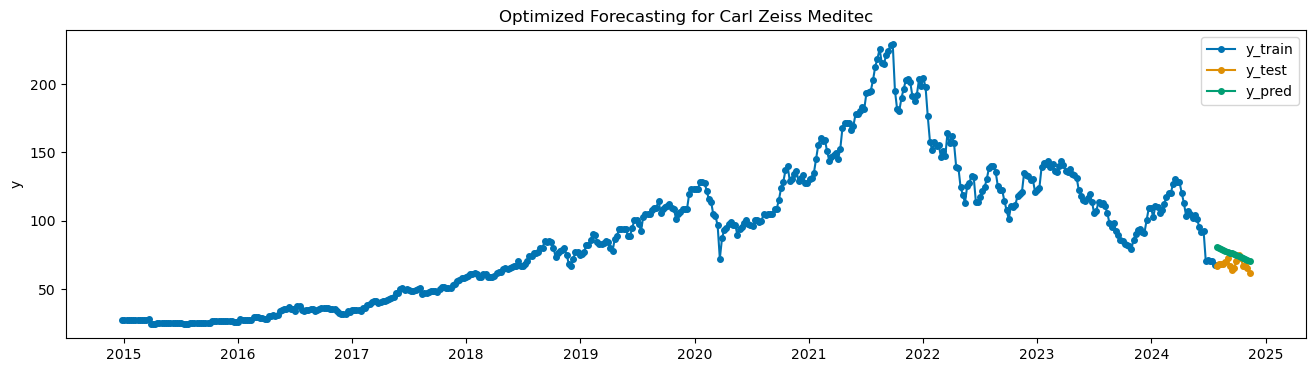

23:21:27 - cmdstanpy - INFO - Chain [1] start processing
23:21:27 - cmdstanpy - INFO - Chain [1] done processing
23:21:27 - cmdstanpy - INFO - Chain [1] start processing
23:21:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1 of 480 for Lam Research Corporation...


23:21:27 - cmdstanpy - INFO - Chain [1] start processing
23:21:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2 of 480 for Lam Research Corporation...


23:21:27 - cmdstanpy - INFO - Chain [1] start processing
23:21:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3 of 480 for Lam Research Corporation...


23:21:28 - cmdstanpy - INFO - Chain [1] start processing
23:21:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 4 of 480 for Lam Research Corporation...


23:21:28 - cmdstanpy - INFO - Chain [1] start processing
23:21:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 5 of 480 for Lam Research Corporation...


23:21:28 - cmdstanpy - INFO - Chain [1] start processing
23:21:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 6 of 480 for Lam Research Corporation...


23:21:28 - cmdstanpy - INFO - Chain [1] start processing
23:21:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 7 of 480 for Lam Research Corporation...


23:21:29 - cmdstanpy - INFO - Chain [1] start processing
23:21:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 8 of 480 for Lam Research Corporation...


23:21:29 - cmdstanpy - INFO - Chain [1] start processing
23:21:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 9 of 480 for Lam Research Corporation...


23:21:29 - cmdstanpy - INFO - Chain [1] start processing
23:21:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 10 of 480 for Lam Research Corporation...


23:21:29 - cmdstanpy - INFO - Chain [1] start processing
23:21:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 11 of 480 for Lam Research Corporation...


23:21:30 - cmdstanpy - INFO - Chain [1] start processing
23:21:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 12 of 480 for Lam Research Corporation...
Processing combination 13 of 480 for Lam Research Corporation...


23:21:30 - cmdstanpy - INFO - Chain [1] start processing
23:21:30 - cmdstanpy - INFO - Chain [1] done processing
23:21:30 - cmdstanpy - INFO - Chain [1] start processing
23:21:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 14 of 480 for Lam Research Corporation...


23:21:31 - cmdstanpy - INFO - Chain [1] start processing
23:21:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 15 of 480 for Lam Research Corporation...


23:21:31 - cmdstanpy - INFO - Chain [1] start processing
23:21:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 16 of 480 for Lam Research Corporation...


23:21:31 - cmdstanpy - INFO - Chain [1] start processing
23:21:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 17 of 480 for Lam Research Corporation...


23:21:31 - cmdstanpy - INFO - Chain [1] start processing
23:21:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 18 of 480 for Lam Research Corporation...


23:21:32 - cmdstanpy - INFO - Chain [1] start processing
23:21:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 19 of 480 for Lam Research Corporation...


23:21:32 - cmdstanpy - INFO - Chain [1] start processing
23:21:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 20 of 480 for Lam Research Corporation...


23:21:32 - cmdstanpy - INFO - Chain [1] start processing
23:21:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 21 of 480 for Lam Research Corporation...


23:21:32 - cmdstanpy - INFO - Chain [1] start processing
23:21:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 22 of 480 for Lam Research Corporation...


23:21:33 - cmdstanpy - INFO - Chain [1] start processing
23:21:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 23 of 480 for Lam Research Corporation...


23:21:33 - cmdstanpy - INFO - Chain [1] start processing
23:21:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 24 of 480 for Lam Research Corporation...


23:21:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 25 of 480 for Lam Research Corporation...


23:21:33 - cmdstanpy - INFO - Chain [1] done processing
23:21:33 - cmdstanpy - INFO - Chain [1] start processing
23:21:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 26 of 480 for Lam Research Corporation...


23:21:34 - cmdstanpy - INFO - Chain [1] start processing
23:21:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 27 of 480 for Lam Research Corporation...


23:21:34 - cmdstanpy - INFO - Chain [1] start processing
23:21:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 28 of 480 for Lam Research Corporation...


23:21:34 - cmdstanpy - INFO - Chain [1] start processing
23:21:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 29 of 480 for Lam Research Corporation...


23:21:34 - cmdstanpy - INFO - Chain [1] start processing
23:21:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 30 of 480 for Lam Research Corporation...


23:21:35 - cmdstanpy - INFO - Chain [1] start processing
23:21:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 31 of 480 for Lam Research Corporation...


23:21:35 - cmdstanpy - INFO - Chain [1] start processing
23:21:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 32 of 480 for Lam Research Corporation...


23:21:35 - cmdstanpy - INFO - Chain [1] start processing
23:21:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 33 of 480 for Lam Research Corporation...


23:21:35 - cmdstanpy - INFO - Chain [1] start processing
23:21:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 34 of 480 for Lam Research Corporation...


23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 35 of 480 for Lam Research Corporation...


23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 36 of 480 for Lam Research Corporation...


23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 37 of 480 for Lam Research Corporation...


23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 38 of 480 for Lam Research Corporation...


23:21:37 - cmdstanpy - INFO - Chain [1] start processing
23:21:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 39 of 480 for Lam Research Corporation...


23:21:37 - cmdstanpy - INFO - Chain [1] start processing
23:21:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 40 of 480 for Lam Research Corporation...


23:21:37 - cmdstanpy - INFO - Chain [1] start processing
23:21:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 41 of 480 for Lam Research Corporation...


23:21:37 - cmdstanpy - INFO - Chain [1] start processing
23:21:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 42 of 480 for Lam Research Corporation...


23:21:38 - cmdstanpy - INFO - Chain [1] start processing
23:21:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 43 of 480 for Lam Research Corporation...


23:21:38 - cmdstanpy - INFO - Chain [1] start processing
23:21:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 44 of 480 for Lam Research Corporation...


23:21:38 - cmdstanpy - INFO - Chain [1] start processing
23:21:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 45 of 480 for Lam Research Corporation...


23:21:38 - cmdstanpy - INFO - Chain [1] start processing
23:21:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 46 of 480 for Lam Research Corporation...


23:21:39 - cmdstanpy - INFO - Chain [1] start processing
23:21:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 47 of 480 for Lam Research Corporation...


23:21:39 - cmdstanpy - INFO - Chain [1] start processing
23:21:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 48 of 480 for Lam Research Corporation...
Processing combination 49 of 480 for Lam Research Corporation...


23:21:39 - cmdstanpy - INFO - Chain [1] start processing
23:21:39 - cmdstanpy - INFO - Chain [1] done processing
23:21:39 - cmdstanpy - INFO - Chain [1] start processing
23:21:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 50 of 480 for Lam Research Corporation...


23:21:40 - cmdstanpy - INFO - Chain [1] start processing
23:21:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 51 of 480 for Lam Research Corporation...


23:21:40 - cmdstanpy - INFO - Chain [1] start processing
23:21:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 52 of 480 for Lam Research Corporation...


23:21:40 - cmdstanpy - INFO - Chain [1] start processing
23:21:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 53 of 480 for Lam Research Corporation...


23:21:40 - cmdstanpy - INFO - Chain [1] start processing
23:21:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 54 of 480 for Lam Research Corporation...


23:21:41 - cmdstanpy - INFO - Chain [1] start processing
23:21:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 55 of 480 for Lam Research Corporation...


23:21:41 - cmdstanpy - INFO - Chain [1] start processing
23:21:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 56 of 480 for Lam Research Corporation...
Processing combination 57 of 480 for Lam Research Corporation...


23:21:41 - cmdstanpy - INFO - Chain [1] start processing
23:21:41 - cmdstanpy - INFO - Chain [1] done processing
23:21:41 - cmdstanpy - INFO - Chain [1] start processing
23:21:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 58 of 480 for Lam Research Corporation...


23:21:41 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 59 of 480 for Lam Research Corporation...


23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 60 of 480 for Lam Research Corporation...


23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 61 of 480 for Lam Research Corporation...


23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 62 of 480 for Lam Research Corporation...


23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 63 of 480 for Lam Research Corporation...


23:21:43 - cmdstanpy - INFO - Chain [1] start processing
23:21:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 64 of 480 for Lam Research Corporation...
Processing combination 65 of 480 for Lam Research Corporation...


23:21:43 - cmdstanpy - INFO - Chain [1] start processing
23:21:43 - cmdstanpy - INFO - Chain [1] done processing
23:21:43 - cmdstanpy - INFO - Chain [1] start processing
23:21:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 66 of 480 for Lam Research Corporation...


23:21:43 - cmdstanpy - INFO - Chain [1] start processing
23:21:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 67 of 480 for Lam Research Corporation...


23:21:44 - cmdstanpy - INFO - Chain [1] start processing
23:21:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 68 of 480 for Lam Research Corporation...
Processing combination 69 of 480 for Lam Research Corporation...


23:21:44 - cmdstanpy - INFO - Chain [1] start processing
23:21:44 - cmdstanpy - INFO - Chain [1] done processing
23:21:44 - cmdstanpy - INFO - Chain [1] start processing
23:21:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 70 of 480 for Lam Research Corporation...


23:21:44 - cmdstanpy - INFO - Chain [1] start processing
23:21:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 71 of 480 for Lam Research Corporation...


23:21:45 - cmdstanpy - INFO - Chain [1] start processing
23:21:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 72 of 480 for Lam Research Corporation...


23:21:45 - cmdstanpy - INFO - Chain [1] start processing
23:21:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 73 of 480 for Lam Research Corporation...


23:21:45 - cmdstanpy - INFO - Chain [1] start processing
23:21:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 74 of 480 for Lam Research Corporation...


23:21:45 - cmdstanpy - INFO - Chain [1] start processing
23:21:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 75 of 480 for Lam Research Corporation...


23:21:46 - cmdstanpy - INFO - Chain [1] start processing
23:21:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 76 of 480 for Lam Research Corporation...
Processing combination 77 of 480 for Lam Research Corporation...


23:21:46 - cmdstanpy - INFO - Chain [1] start processing
23:21:46 - cmdstanpy - INFO - Chain [1] done processing
23:21:46 - cmdstanpy - INFO - Chain [1] start processing
23:21:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 78 of 480 for Lam Research Corporation...


23:21:46 - cmdstanpy - INFO - Chain [1] start processing
23:21:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 79 of 480 for Lam Research Corporation...


23:21:46 - cmdstanpy - INFO - Chain [1] start processing
23:21:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 80 of 480 for Lam Research Corporation...
Processing combination 81 of 480 for Lam Research Corporation...


23:21:47 - cmdstanpy - INFO - Chain [1] start processing
23:21:47 - cmdstanpy - INFO - Chain [1] done processing
23:21:47 - cmdstanpy - INFO - Chain [1] start processing
23:21:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 82 of 480 for Lam Research Corporation...


23:21:47 - cmdstanpy - INFO - Chain [1] start processing
23:21:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 83 of 480 for Lam Research Corporation...


23:21:47 - cmdstanpy - INFO - Chain [1] start processing
23:21:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 84 of 480 for Lam Research Corporation...


23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 85 of 480 for Lam Research Corporation...


23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 86 of 480 for Lam Research Corporation...


23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 87 of 480 for Lam Research Corporation...


23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 88 of 480 for Lam Research Corporation...
Processing combination 89 of 480 for Lam Research Corporation...


23:21:49 - cmdstanpy - INFO - Chain [1] start processing
23:21:49 - cmdstanpy - INFO - Chain [1] done processing
23:21:49 - cmdstanpy - INFO - Chain [1] start processing
23:21:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 90 of 480 for Lam Research Corporation...


23:21:49 - cmdstanpy - INFO - Chain [1] start processing
23:21:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 91 of 480 for Lam Research Corporation...


23:21:50 - cmdstanpy - INFO - Chain [1] start processing
23:21:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 92 of 480 for Lam Research Corporation...


23:21:50 - cmdstanpy - INFO - Chain [1] start processing
23:21:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 93 of 480 for Lam Research Corporation...


23:21:50 - cmdstanpy - INFO - Chain [1] start processing
23:21:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 94 of 480 for Lam Research Corporation...


23:21:50 - cmdstanpy - INFO - Chain [1] start processing
23:21:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 95 of 480 for Lam Research Corporation...


23:21:51 - cmdstanpy - INFO - Chain [1] start processing
23:21:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 96 of 480 for Lam Research Corporation...


23:21:51 - cmdstanpy - INFO - Chain [1] start processing
23:21:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 97 of 480 for Lam Research Corporation...


23:21:51 - cmdstanpy - INFO - Chain [1] start processing
23:21:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 98 of 480 for Lam Research Corporation...


23:21:51 - cmdstanpy - INFO - Chain [1] start processing
23:21:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 99 of 480 for Lam Research Corporation...


23:21:52 - cmdstanpy - INFO - Chain [1] start processing
23:21:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 100 of 480 for Lam Research Corporation...


23:21:52 - cmdstanpy - INFO - Chain [1] start processing
23:21:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 101 of 480 for Lam Research Corporation...


23:21:52 - cmdstanpy - INFO - Chain [1] start processing
23:21:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 102 of 480 for Lam Research Corporation...


23:21:52 - cmdstanpy - INFO - Chain [1] start processing
23:21:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 103 of 480 for Lam Research Corporation...


23:21:53 - cmdstanpy - INFO - Chain [1] start processing
23:21:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 104 of 480 for Lam Research Corporation...


23:21:53 - cmdstanpy - INFO - Chain [1] start processing
23:21:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 105 of 480 for Lam Research Corporation...


23:21:53 - cmdstanpy - INFO - Chain [1] start processing
23:21:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 106 of 480 for Lam Research Corporation...


23:21:53 - cmdstanpy - INFO - Chain [1] start processing
23:21:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 107 of 480 for Lam Research Corporation...


23:21:54 - cmdstanpy - INFO - Chain [1] start processing
23:21:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 108 of 480 for Lam Research Corporation...


23:21:54 - cmdstanpy - INFO - Chain [1] start processing
23:21:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 109 of 480 for Lam Research Corporation...


23:21:54 - cmdstanpy - INFO - Chain [1] start processing
23:21:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 110 of 480 for Lam Research Corporation...


23:21:54 - cmdstanpy - INFO - Chain [1] start processing
23:21:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 111 of 480 for Lam Research Corporation...


23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 112 of 480 for Lam Research Corporation...


23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 113 of 480 for Lam Research Corporation...


23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 114 of 480 for Lam Research Corporation...


23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 115 of 480 for Lam Research Corporation...


23:21:56 - cmdstanpy - INFO - Chain [1] start processing
23:21:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 116 of 480 for Lam Research Corporation...


23:21:56 - cmdstanpy - INFO - Chain [1] start processing
23:21:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 117 of 480 for Lam Research Corporation...


23:21:56 - cmdstanpy - INFO - Chain [1] start processing
23:21:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 118 of 480 for Lam Research Corporation...


23:21:56 - cmdstanpy - INFO - Chain [1] start processing
23:21:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 119 of 480 for Lam Research Corporation...


23:21:57 - cmdstanpy - INFO - Chain [1] start processing
23:21:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 120 of 480 for Lam Research Corporation...
Processing combination 121 of 480 for Lam Research Corporation...


23:21:57 - cmdstanpy - INFO - Chain [1] start processing
23:21:57 - cmdstanpy - INFO - Chain [1] done processing
23:21:57 - cmdstanpy - INFO - Chain [1] start processing
23:21:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 122 of 480 for Lam Research Corporation...
Processing combination 123 of 480 for Lam Research Corporation...


23:21:57 - cmdstanpy - INFO - Chain [1] start processing
23:21:57 - cmdstanpy - INFO - Chain [1] done processing
23:21:58 - cmdstanpy - INFO - Chain [1] start processing
23:21:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 124 of 480 for Lam Research Corporation...


23:21:58 - cmdstanpy - INFO - Chain [1] start processing
23:21:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 125 of 480 for Lam Research Corporation...


23:21:58 - cmdstanpy - INFO - Chain [1] start processing
23:21:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 126 of 480 for Lam Research Corporation...


23:21:58 - cmdstanpy - INFO - Chain [1] start processing
23:21:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 127 of 480 for Lam Research Corporation...


23:21:59 - cmdstanpy - INFO - Chain [1] start processing
23:21:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 128 of 480 for Lam Research Corporation...
Processing combination 129 of 480 for Lam Research Corporation...


23:21:59 - cmdstanpy - INFO - Chain [1] start processing
23:21:59 - cmdstanpy - INFO - Chain [1] done processing
23:21:59 - cmdstanpy - INFO - Chain [1] start processing
23:21:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 130 of 480 for Lam Research Corporation...


23:21:59 - cmdstanpy - INFO - Chain [1] start processing
23:21:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 131 of 480 for Lam Research Corporation...


23:22:00 - cmdstanpy - INFO - Chain [1] start processing
23:22:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 132 of 480 for Lam Research Corporation...
Processing combination 133 of 480 for Lam Research Corporation...


23:22:00 - cmdstanpy - INFO - Chain [1] start processing
23:22:00 - cmdstanpy - INFO - Chain [1] done processing
23:22:00 - cmdstanpy - INFO - Chain [1] start processing
23:22:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 134 of 480 for Lam Research Corporation...


23:22:00 - cmdstanpy - INFO - Chain [1] start processing
23:22:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 135 of 480 for Lam Research Corporation...


23:22:01 - cmdstanpy - INFO - Chain [1] start processing
23:22:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 136 of 480 for Lam Research Corporation...
Processing combination 137 of 480 for Lam Research Corporation...


23:22:01 - cmdstanpy - INFO - Chain [1] start processing
23:22:01 - cmdstanpy - INFO - Chain [1] done processing
23:22:01 - cmdstanpy - INFO - Chain [1] start processing
23:22:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 138 of 480 for Lam Research Corporation...


23:22:01 - cmdstanpy - INFO - Chain [1] start processing
23:22:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 139 of 480 for Lam Research Corporation...


23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 140 of 480 for Lam Research Corporation...
Processing combination 141 of 480 for Lam Research Corporation...


23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing
23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 142 of 480 for Lam Research Corporation...


23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 143 of 480 for Lam Research Corporation...


23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 144 of 480 for Lam Research Corporation...
Processing combination 145 of 480 for Lam Research Corporation...


23:22:03 - cmdstanpy - INFO - Chain [1] start processing
23:22:03 - cmdstanpy - INFO - Chain [1] done processing
23:22:03 - cmdstanpy - INFO - Chain [1] start processing
23:22:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 146 of 480 for Lam Research Corporation...


23:22:03 - cmdstanpy - INFO - Chain [1] start processing
23:22:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 147 of 480 for Lam Research Corporation...


23:22:03 - cmdstanpy - INFO - Chain [1] start processing
23:22:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 148 of 480 for Lam Research Corporation...
Processing combination 149 of 480 for Lam Research Corporation...


23:22:04 - cmdstanpy - INFO - Chain [1] start processing
23:22:04 - cmdstanpy - INFO - Chain [1] done processing
23:22:04 - cmdstanpy - INFO - Chain [1] start processing
23:22:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 150 of 480 for Lam Research Corporation...


23:22:04 - cmdstanpy - INFO - Chain [1] start processing
23:22:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 151 of 480 for Lam Research Corporation...


23:22:04 - cmdstanpy - INFO - Chain [1] start processing
23:22:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 152 of 480 for Lam Research Corporation...
Processing combination 153 of 480 for Lam Research Corporation...


23:22:05 - cmdstanpy - INFO - Chain [1] start processing
23:22:05 - cmdstanpy - INFO - Chain [1] done processing
23:22:05 - cmdstanpy - INFO - Chain [1] start processing
23:22:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 154 of 480 for Lam Research Corporation...


23:22:05 - cmdstanpy - INFO - Chain [1] start processing
23:22:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 155 of 480 for Lam Research Corporation...


23:22:05 - cmdstanpy - INFO - Chain [1] start processing
23:22:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 156 of 480 for Lam Research Corporation...
Processing combination 157 of 480 for Lam Research Corporation...


23:22:06 - cmdstanpy - INFO - Chain [1] start processing
23:22:06 - cmdstanpy - INFO - Chain [1] done processing
23:22:06 - cmdstanpy - INFO - Chain [1] start processing
23:22:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 158 of 480 for Lam Research Corporation...


23:22:06 - cmdstanpy - INFO - Chain [1] start processing
23:22:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 159 of 480 for Lam Research Corporation...


23:22:06 - cmdstanpy - INFO - Chain [1] start processing
23:22:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 160 of 480 for Lam Research Corporation...


23:22:07 - cmdstanpy - INFO - Chain [1] start processing
23:22:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 161 of 480 for Lam Research Corporation...


23:22:07 - cmdstanpy - INFO - Chain [1] start processing
23:22:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 162 of 480 for Lam Research Corporation...


23:22:07 - cmdstanpy - INFO - Chain [1] start processing
23:22:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 163 of 480 for Lam Research Corporation...


23:22:07 - cmdstanpy - INFO - Chain [1] start processing
23:22:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 164 of 480 for Lam Research Corporation...
Processing combination 165 of 480 for Lam Research Corporation...


23:22:08 - cmdstanpy - INFO - Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing
23:22:08 - cmdstanpy - INFO - Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 166 of 480 for Lam Research Corporation...


23:22:08 - cmdstanpy - INFO - Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 167 of 480 for Lam Research Corporation...


23:22:08 - cmdstanpy - INFO - Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 168 of 480 for Lam Research Corporation...


23:22:09 - cmdstanpy - INFO - Chain [1] start processing
23:22:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 169 of 480 for Lam Research Corporation...


23:22:09 - cmdstanpy - INFO - Chain [1] start processing
23:22:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 170 of 480 for Lam Research Corporation...


23:22:09 - cmdstanpy - INFO - Chain [1] start processing
23:22:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 171 of 480 for Lam Research Corporation...


23:22:09 - cmdstanpy - INFO - Chain [1] start processing
23:22:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 172 of 480 for Lam Research Corporation...


23:22:10 - cmdstanpy - INFO - Chain [1] start processing
23:22:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 173 of 480 for Lam Research Corporation...


23:22:10 - cmdstanpy - INFO - Chain [1] start processing
23:22:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 174 of 480 for Lam Research Corporation...


23:22:10 - cmdstanpy - INFO - Chain [1] start processing
23:22:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 175 of 480 for Lam Research Corporation...


23:22:10 - cmdstanpy - INFO - Chain [1] start processing
23:22:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 176 of 480 for Lam Research Corporation...


23:22:11 - cmdstanpy - INFO - Chain [1] start processing
23:22:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 177 of 480 for Lam Research Corporation...


23:22:11 - cmdstanpy - INFO - Chain [1] start processing
23:22:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 178 of 480 for Lam Research Corporation...


23:22:11 - cmdstanpy - INFO - Chain [1] start processing
23:22:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 179 of 480 for Lam Research Corporation...


23:22:11 - cmdstanpy - INFO - Chain [1] start processing
23:22:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 180 of 480 for Lam Research Corporation...


23:22:12 - cmdstanpy - INFO - Chain [1] start processing
23:22:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 181 of 480 for Lam Research Corporation...


23:22:12 - cmdstanpy - INFO - Chain [1] start processing
23:22:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 182 of 480 for Lam Research Corporation...


23:22:12 - cmdstanpy - INFO - Chain [1] start processing
23:22:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 183 of 480 for Lam Research Corporation...


23:22:12 - cmdstanpy - INFO - Chain [1] start processing
23:22:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 184 of 480 for Lam Research Corporation...


23:22:13 - cmdstanpy - INFO - Chain [1] start processing
23:22:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 185 of 480 for Lam Research Corporation...


23:22:13 - cmdstanpy - INFO - Chain [1] start processing
23:22:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 186 of 480 for Lam Research Corporation...


23:22:13 - cmdstanpy - INFO - Chain [1] start processing
23:22:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 187 of 480 for Lam Research Corporation...


23:22:13 - cmdstanpy - INFO - Chain [1] start processing
23:22:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 188 of 480 for Lam Research Corporation...


23:22:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 189 of 480 for Lam Research Corporation...


23:22:14 - cmdstanpy - INFO - Chain [1] done processing
23:22:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 190 of 480 for Lam Research Corporation...


23:22:14 - cmdstanpy - INFO - Chain [1] done processing
23:22:14 - cmdstanpy - INFO - Chain [1] start processing
23:22:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 191 of 480 for Lam Research Corporation...


23:22:15 - cmdstanpy - INFO - Chain [1] start processing
23:22:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 192 of 480 for Lam Research Corporation...


23:22:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 193 of 480 for Lam Research Corporation...


23:22:15 - cmdstanpy - INFO - Chain [1] done processing
23:22:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 194 of 480 for Lam Research Corporation...


23:22:15 - cmdstanpy - INFO - Chain [1] done processing
23:22:16 - cmdstanpy - INFO - Chain [1] start processing
23:22:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 195 of 480 for Lam Research Corporation...


23:22:16 - cmdstanpy - INFO - Chain [1] start processing
23:22:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 196 of 480 for Lam Research Corporation...


23:22:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 197 of 480 for Lam Research Corporation...


23:22:16 - cmdstanpy - INFO - Chain [1] done processing
23:22:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 198 of 480 for Lam Research Corporation...


23:22:17 - cmdstanpy - INFO - Chain [1] done processing
23:22:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 199 of 480 for Lam Research Corporation...


23:22:17 - cmdstanpy - INFO - Chain [1] done processing
23:22:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 200 of 480 for Lam Research Corporation...


23:22:17 - cmdstanpy - INFO - Chain [1] done processing
23:22:17 - cmdstanpy - INFO - Chain [1] start processing
23:22:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 201 of 480 for Lam Research Corporation...


23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 202 of 480 for Lam Research Corporation...
Processing combination 203 of 480 for Lam Research Corporation...


23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:18 - cmdstanpy - INFO - Chain [1] done processing
23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 204 of 480 for Lam Research Corporation...
Processing combination 205 of 480 for Lam Research Corporation...


23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:18 - cmdstanpy - INFO - Chain [1] done processing
23:22:19 - cmdstanpy - INFO - Chain [1] start processing
23:22:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 206 of 480 for Lam Research Corporation...
Processing combination 207 of 480 for Lam Research Corporation...


23:22:19 - cmdstanpy - INFO - Chain [1] start processing
23:22:19 - cmdstanpy - INFO - Chain [1] done processing
23:22:19 - cmdstanpy - INFO - Chain [1] start processing
23:22:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 208 of 480 for Lam Research Corporation...
Processing combination 209 of 480 for Lam Research Corporation...


23:22:19 - cmdstanpy - INFO - Chain [1] start processing
23:22:19 - cmdstanpy - INFO - Chain [1] done processing
23:22:20 - cmdstanpy - INFO - Chain [1] start processing
23:22:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 210 of 480 for Lam Research Corporation...


23:22:20 - cmdstanpy - INFO - Chain [1] start processing
23:22:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 211 of 480 for Lam Research Corporation...


23:22:20 - cmdstanpy - INFO - Chain [1] start processing
23:22:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 212 of 480 for Lam Research Corporation...
Processing combination 213 of 480 for Lam Research Corporation...


23:22:20 - cmdstanpy - INFO - Chain [1] start processing
23:22:20 - cmdstanpy - INFO - Chain [1] done processing
23:22:20 - cmdstanpy - INFO - Chain [1] start processing
23:22:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 214 of 480 for Lam Research Corporation...


23:22:21 - cmdstanpy - INFO - Chain [1] start processing
23:22:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 215 of 480 for Lam Research Corporation...


23:22:21 - cmdstanpy - INFO - Chain [1] start processing
23:22:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 216 of 480 for Lam Research Corporation...
Processing combination 217 of 480 for Lam Research Corporation...


23:22:21 - cmdstanpy - INFO - Chain [1] start processing
23:22:21 - cmdstanpy - INFO - Chain [1] done processing
23:22:21 - cmdstanpy - INFO - Chain [1] start processing
23:22:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 218 of 480 for Lam Research Corporation...


23:22:22 - cmdstanpy - INFO - Chain [1] start processing
23:22:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 219 of 480 for Lam Research Corporation...


23:22:22 - cmdstanpy - INFO - Chain [1] start processing
23:22:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 220 of 480 for Lam Research Corporation...
Processing combination 221 of 480 for Lam Research Corporation...


23:22:22 - cmdstanpy - INFO - Chain [1] start processing
23:22:22 - cmdstanpy - INFO - Chain [1] done processing
23:22:22 - cmdstanpy - INFO - Chain [1] start processing
23:22:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 222 of 480 for Lam Research Corporation...
Processing combination 223 of 480 for Lam Research Corporation...


23:22:23 - cmdstanpy - INFO - Chain [1] start processing
23:22:23 - cmdstanpy - INFO - Chain [1] done processing
23:22:23 - cmdstanpy - INFO - Chain [1] start processing
23:22:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 224 of 480 for Lam Research Corporation...
Processing combination 225 of 480 for Lam Research Corporation...


23:22:23 - cmdstanpy - INFO - Chain [1] start processing
23:22:23 - cmdstanpy - INFO - Chain [1] done processing
23:22:23 - cmdstanpy - INFO - Chain [1] start processing
23:22:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 226 of 480 for Lam Research Corporation...


23:22:24 - cmdstanpy - INFO - Chain [1] start processing
23:22:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 227 of 480 for Lam Research Corporation...


23:22:24 - cmdstanpy - INFO - Chain [1] start processing
23:22:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 228 of 480 for Lam Research Corporation...
Processing combination 229 of 480 for Lam Research Corporation...


23:22:24 - cmdstanpy - INFO - Chain [1] start processing
23:22:24 - cmdstanpy - INFO - Chain [1] done processing
23:22:24 - cmdstanpy - INFO - Chain [1] start processing
23:22:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 230 of 480 for Lam Research Corporation...


23:22:25 - cmdstanpy - INFO - Chain [1] start processing
23:22:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 231 of 480 for Lam Research Corporation...


23:22:25 - cmdstanpy - INFO - Chain [1] start processing
23:22:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 232 of 480 for Lam Research Corporation...
Processing combination 233 of 480 for Lam Research Corporation...


23:22:25 - cmdstanpy - INFO - Chain [1] start processing
23:22:25 - cmdstanpy - INFO - Chain [1] done processing
23:22:25 - cmdstanpy - INFO - Chain [1] start processing
23:22:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 234 of 480 for Lam Research Corporation...


23:22:26 - cmdstanpy - INFO - Chain [1] start processing
23:22:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 235 of 480 for Lam Research Corporation...


23:22:26 - cmdstanpy - INFO - Chain [1] start processing
23:22:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 236 of 480 for Lam Research Corporation...


23:22:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 237 of 480 for Lam Research Corporation...


23:22:26 - cmdstanpy - INFO - Chain [1] done processing
23:22:26 - cmdstanpy - INFO - Chain [1] start processing
23:22:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 238 of 480 for Lam Research Corporation...


23:22:27 - cmdstanpy - INFO - Chain [1] start processing
23:22:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 239 of 480 for Lam Research Corporation...


23:22:27 - cmdstanpy - INFO - Chain [1] start processing
23:22:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 240 of 480 for Lam Research Corporation...


23:22:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 241 of 480 for Lam Research Corporation...


23:22:27 - cmdstanpy - INFO - Chain [1] done processing
23:22:28 - cmdstanpy - INFO - Chain [1] start processing
23:22:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 242 of 480 for Lam Research Corporation...


23:22:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 243 of 480 for Lam Research Corporation...


23:22:28 - cmdstanpy - INFO - Chain [1] done processing
23:22:28 - cmdstanpy - INFO - Chain [1] start processing
23:22:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 244 of 480 for Lam Research Corporation...


23:22:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 245 of 480 for Lam Research Corporation...


23:22:29 - cmdstanpy - INFO - Chain [1] done processing
23:22:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 246 of 480 for Lam Research Corporation...


23:22:29 - cmdstanpy - INFO - Chain [1] done processing
23:22:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 247 of 480 for Lam Research Corporation...


23:22:29 - cmdstanpy - INFO - Chain [1] done processing
23:22:29 - cmdstanpy - INFO - Chain [1] start processing
23:22:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 248 of 480 for Lam Research Corporation...


23:22:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 249 of 480 for Lam Research Corporation...


23:22:30 - cmdstanpy - INFO - Chain [1] done processing
23:22:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 250 of 480 for Lam Research Corporation...


23:22:30 - cmdstanpy - INFO - Chain [1] done processing
23:22:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 251 of 480 for Lam Research Corporation...


23:22:31 - cmdstanpy - INFO - Chain [1] done processing
23:22:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 252 of 480 for Lam Research Corporation...


23:22:31 - cmdstanpy - INFO - Chain [1] done processing
23:22:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 253 of 480 for Lam Research Corporation...


23:22:31 - cmdstanpy - INFO - Chain [1] done processing
23:22:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 254 of 480 for Lam Research Corporation...


23:22:32 - cmdstanpy - INFO - Chain [1] done processing
23:22:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 255 of 480 for Lam Research Corporation...


23:22:32 - cmdstanpy - INFO - Chain [1] done processing
23:22:32 - cmdstanpy - INFO - Chain [1] start processing
23:22:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 256 of 480 for Lam Research Corporation...


23:22:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 257 of 480 for Lam Research Corporation...


23:22:32 - cmdstanpy - INFO - Chain [1] done processing
23:22:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 258 of 480 for Lam Research Corporation...


23:22:33 - cmdstanpy - INFO - Chain [1] done processing
23:22:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 259 of 480 for Lam Research Corporation...


23:22:33 - cmdstanpy - INFO - Chain [1] done processing
23:22:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 260 of 480 for Lam Research Corporation...


23:22:33 - cmdstanpy - INFO - Chain [1] done processing
23:22:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 261 of 480 for Lam Research Corporation...


23:22:34 - cmdstanpy - INFO - Chain [1] done processing
23:22:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 262 of 480 for Lam Research Corporation...


23:22:34 - cmdstanpy - INFO - Chain [1] done processing
23:22:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 263 of 480 for Lam Research Corporation...


23:22:35 - cmdstanpy - INFO - Chain [1] done processing
23:22:35 - cmdstanpy - INFO - Chain [1] start processing
23:22:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 264 of 480 for Lam Research Corporation...


23:22:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 265 of 480 for Lam Research Corporation...


23:22:35 - cmdstanpy - INFO - Chain [1] done processing
23:22:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 266 of 480 for Lam Research Corporation...


23:22:36 - cmdstanpy - INFO - Chain [1] done processing
23:22:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 267 of 480 for Lam Research Corporation...


23:22:36 - cmdstanpy - INFO - Chain [1] done processing
23:22:36 - cmdstanpy - INFO - Chain [1] start processing
23:22:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 268 of 480 for Lam Research Corporation...


23:22:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 269 of 480 for Lam Research Corporation...


23:22:37 - cmdstanpy - INFO - Chain [1] done processing
23:22:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 270 of 480 for Lam Research Corporation...


23:22:37 - cmdstanpy - INFO - Chain [1] done processing
23:22:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 271 of 480 for Lam Research Corporation...


23:22:38 - cmdstanpy - INFO - Chain [1] done processing
23:22:38 - cmdstanpy - INFO - Chain [1] start processing
23:22:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 272 of 480 for Lam Research Corporation...


23:22:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 273 of 480 for Lam Research Corporation...


23:22:39 - cmdstanpy - INFO - Chain [1] done processing
23:22:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 274 of 480 for Lam Research Corporation...


23:22:39 - cmdstanpy - INFO - Chain [1] done processing
23:22:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 275 of 480 for Lam Research Corporation...


23:22:39 - cmdstanpy - INFO - Chain [1] done processing
23:22:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 276 of 480 for Lam Research Corporation...


23:22:40 - cmdstanpy - INFO - Chain [1] done processing
23:22:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 277 of 480 for Lam Research Corporation...


23:22:40 - cmdstanpy - INFO - Chain [1] done processing
23:22:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 278 of 480 for Lam Research Corporation...


23:22:41 - cmdstanpy - INFO - Chain [1] done processing
23:22:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 279 of 480 for Lam Research Corporation...


23:22:41 - cmdstanpy - INFO - Chain [1] done processing
23:22:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 280 of 480 for Lam Research Corporation...


23:22:41 - cmdstanpy - INFO - Chain [1] done processing
23:22:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 281 of 480 for Lam Research Corporation...


23:22:42 - cmdstanpy - INFO - Chain [1] done processing
23:22:42 - cmdstanpy - INFO - Chain [1] start processing
23:22:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 282 of 480 for Lam Research Corporation...


23:22:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 283 of 480 for Lam Research Corporation...


23:22:42 - cmdstanpy - INFO - Chain [1] done processing
23:22:42 - cmdstanpy - INFO - Chain [1] start processing
23:22:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 284 of 480 for Lam Research Corporation...


23:22:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 285 of 480 for Lam Research Corporation...


23:22:43 - cmdstanpy - INFO - Chain [1] done processing
23:22:43 - cmdstanpy - INFO - Chain [1] start processing
23:22:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 286 of 480 for Lam Research Corporation...


23:22:44 - cmdstanpy - INFO - Chain [1] start processing
23:22:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 287 of 480 for Lam Research Corporation...


23:22:44 - cmdstanpy - INFO - Chain [1] start processing
23:22:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 288 of 480 for Lam Research Corporation...


23:22:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 289 of 480 for Lam Research Corporation...


23:22:44 - cmdstanpy - INFO - Chain [1] done processing
23:22:44 - cmdstanpy - INFO - Chain [1] start processing
23:22:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 290 of 480 for Lam Research Corporation...


23:22:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 291 of 480 for Lam Research Corporation...


23:22:45 - cmdstanpy - INFO - Chain [1] done processing
23:22:45 - cmdstanpy - INFO - Chain [1] start processing
23:22:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 292 of 480 for Lam Research Corporation...


23:22:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 293 of 480 for Lam Research Corporation...


23:22:46 - cmdstanpy - INFO - Chain [1] done processing
23:22:46 - cmdstanpy - INFO - Chain [1] start processing
23:22:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 294 of 480 for Lam Research Corporation...


23:22:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 295 of 480 for Lam Research Corporation...


23:22:46 - cmdstanpy - INFO - Chain [1] done processing
23:22:46 - cmdstanpy - INFO - Chain [1] start processing
23:22:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 296 of 480 for Lam Research Corporation...


23:22:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 297 of 480 for Lam Research Corporation...


23:22:47 - cmdstanpy - INFO - Chain [1] done processing
23:22:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 298 of 480 for Lam Research Corporation...


23:22:47 - cmdstanpy - INFO - Chain [1] done processing
23:22:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 299 of 480 for Lam Research Corporation...


23:22:48 - cmdstanpy - INFO - Chain [1] done processing
23:22:48 - cmdstanpy - INFO - Chain [1] start processing
23:22:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 300 of 480 for Lam Research Corporation...


23:22:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 301 of 480 for Lam Research Corporation...


23:22:48 - cmdstanpy - INFO - Chain [1] done processing
23:22:48 - cmdstanpy - INFO - Chain [1] start processing
23:22:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 302 of 480 for Lam Research Corporation...


23:22:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 303 of 480 for Lam Research Corporation...


23:22:49 - cmdstanpy - INFO - Chain [1] done processing
23:22:49 - cmdstanpy - INFO - Chain [1] start processing
23:22:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 304 of 480 for Lam Research Corporation...


23:22:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 305 of 480 for Lam Research Corporation...


23:22:49 - cmdstanpy - INFO - Chain [1] done processing
23:22:50 - cmdstanpy - INFO - Chain [1] start processing
23:22:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 306 of 480 for Lam Research Corporation...


23:22:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 307 of 480 for Lam Research Corporation...


23:22:50 - cmdstanpy - INFO - Chain [1] done processing
23:22:50 - cmdstanpy - INFO - Chain [1] start processing
23:22:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 308 of 480 for Lam Research Corporation...


23:22:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 309 of 480 for Lam Research Corporation...


23:22:51 - cmdstanpy - INFO - Chain [1] done processing
23:22:51 - cmdstanpy - INFO - Chain [1] start processing
23:22:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 310 of 480 for Lam Research Corporation...


23:22:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 311 of 480 for Lam Research Corporation...


23:22:52 - cmdstanpy - INFO - Chain [1] done processing
23:22:52 - cmdstanpy - INFO - Chain [1] start processing
23:22:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 312 of 480 for Lam Research Corporation...


23:22:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 313 of 480 for Lam Research Corporation...


23:22:52 - cmdstanpy - INFO - Chain [1] done processing
23:22:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 314 of 480 for Lam Research Corporation...


23:22:53 - cmdstanpy - INFO - Chain [1] done processing
23:22:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 315 of 480 for Lam Research Corporation...


23:22:53 - cmdstanpy - INFO - Chain [1] done processing
23:22:53 - cmdstanpy - INFO - Chain [1] start processing
23:22:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 316 of 480 for Lam Research Corporation...


23:22:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 317 of 480 for Lam Research Corporation...


23:22:54 - cmdstanpy - INFO - Chain [1] done processing
23:22:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 318 of 480 for Lam Research Corporation...


23:22:54 - cmdstanpy - INFO - Chain [1] done processing
23:22:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 319 of 480 for Lam Research Corporation...


23:22:54 - cmdstanpy - INFO - Chain [1] done processing
23:22:54 - cmdstanpy - INFO - Chain [1] start processing
23:22:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 320 of 480 for Lam Research Corporation...


23:22:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 321 of 480 for Lam Research Corporation...


23:22:55 - cmdstanpy - INFO - Chain [1] done processing
23:22:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 322 of 480 for Lam Research Corporation...


23:22:55 - cmdstanpy - INFO - Chain [1] done processing
23:22:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 323 of 480 for Lam Research Corporation...


23:22:56 - cmdstanpy - INFO - Chain [1] done processing
23:22:56 - cmdstanpy - INFO - Chain [1] start processing
23:22:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 324 of 480 for Lam Research Corporation...


23:22:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 325 of 480 for Lam Research Corporation...


23:22:56 - cmdstanpy - INFO - Chain [1] done processing
23:22:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 326 of 480 for Lam Research Corporation...


23:22:57 - cmdstanpy - INFO - Chain [1] done processing
23:22:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 327 of 480 for Lam Research Corporation...


23:22:57 - cmdstanpy - INFO - Chain [1] done processing
23:22:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 328 of 480 for Lam Research Corporation...


23:22:57 - cmdstanpy - INFO - Chain [1] done processing
23:22:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 329 of 480 for Lam Research Corporation...


23:22:58 - cmdstanpy - INFO - Chain [1] done processing
23:22:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 330 of 480 for Lam Research Corporation...


23:22:58 - cmdstanpy - INFO - Chain [1] done processing
23:22:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 331 of 480 for Lam Research Corporation...


23:22:59 - cmdstanpy - INFO - Chain [1] done processing
23:22:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 332 of 480 for Lam Research Corporation...


23:22:59 - cmdstanpy - INFO - Chain [1] done processing
23:22:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 333 of 480 for Lam Research Corporation...


23:22:59 - cmdstanpy - INFO - Chain [1] done processing
23:23:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 334 of 480 for Lam Research Corporation...


23:23:00 - cmdstanpy - INFO - Chain [1] done processing
23:23:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 335 of 480 for Lam Research Corporation...


23:23:00 - cmdstanpy - INFO - Chain [1] done processing
23:23:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 336 of 480 for Lam Research Corporation...


23:23:00 - cmdstanpy - INFO - Chain [1] done processing
23:23:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 337 of 480 for Lam Research Corporation...


23:23:01 - cmdstanpy - INFO - Chain [1] done processing
23:23:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 338 of 480 for Lam Research Corporation...


23:23:01 - cmdstanpy - INFO - Chain [1] done processing
23:23:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 339 of 480 for Lam Research Corporation...


23:23:02 - cmdstanpy - INFO - Chain [1] done processing
23:23:02 - cmdstanpy - INFO - Chain [1] start processing
23:23:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 340 of 480 for Lam Research Corporation...


23:23:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 341 of 480 for Lam Research Corporation...


23:23:02 - cmdstanpy - INFO - Chain [1] done processing
23:23:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 342 of 480 for Lam Research Corporation...


23:23:03 - cmdstanpy - INFO - Chain [1] done processing
23:23:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 343 of 480 for Lam Research Corporation...


23:23:03 - cmdstanpy - INFO - Chain [1] done processing
23:23:03 - cmdstanpy - INFO - Chain [1] start processing
23:23:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 344 of 480 for Lam Research Corporation...


23:23:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 345 of 480 for Lam Research Corporation...


23:23:04 - cmdstanpy - INFO - Chain [1] done processing
23:23:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 346 of 480 for Lam Research Corporation...


23:23:04 - cmdstanpy - INFO - Chain [1] done processing
23:23:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 347 of 480 for Lam Research Corporation...


23:23:05 - cmdstanpy - INFO - Chain [1] done processing
23:23:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 348 of 480 for Lam Research Corporation...


23:23:05 - cmdstanpy - INFO - Chain [1] done processing
23:23:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 349 of 480 for Lam Research Corporation...


23:23:05 - cmdstanpy - INFO - Chain [1] done processing
23:23:06 - cmdstanpy - INFO - Chain [1] start processing
23:23:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 350 of 480 for Lam Research Corporation...


23:23:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 351 of 480 for Lam Research Corporation...


23:23:06 - cmdstanpy - INFO - Chain [1] done processing
23:23:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 352 of 480 for Lam Research Corporation...


23:23:06 - cmdstanpy - INFO - Chain [1] done processing
23:23:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 353 of 480 for Lam Research Corporation...


23:23:07 - cmdstanpy - INFO - Chain [1] done processing
23:23:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 354 of 480 for Lam Research Corporation...


23:23:07 - cmdstanpy - INFO - Chain [1] done processing
23:23:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 355 of 480 for Lam Research Corporation...


23:23:07 - cmdstanpy - INFO - Chain [1] done processing
23:23:08 - cmdstanpy - INFO - Chain [1] start processing
23:23:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 356 of 480 for Lam Research Corporation...


23:23:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 357 of 480 for Lam Research Corporation...


23:23:08 - cmdstanpy - INFO - Chain [1] done processing
23:23:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 358 of 480 for Lam Research Corporation...


23:23:09 - cmdstanpy - INFO - Chain [1] done processing
23:23:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 359 of 480 for Lam Research Corporation...


23:23:09 - cmdstanpy - INFO - Chain [1] done processing
23:23:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 360 of 480 for Lam Research Corporation...


23:23:09 - cmdstanpy - INFO - Chain [1] done processing
23:23:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 361 of 480 for Lam Research Corporation...


23:23:10 - cmdstanpy - INFO - Chain [1] done processing
23:23:10 - cmdstanpy - INFO - Chain [1] start processing
23:23:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 362 of 480 for Lam Research Corporation...


23:23:10 - cmdstanpy - INFO - Chain [1] start processing
23:23:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 363 of 480 for Lam Research Corporation...


23:23:11 - cmdstanpy - INFO - Chain [1] start processing
23:23:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 364 of 480 for Lam Research Corporation...


23:23:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 365 of 480 for Lam Research Corporation...


23:23:11 - cmdstanpy - INFO - Chain [1] done processing
23:23:11 - cmdstanpy - INFO - Chain [1] start processing
23:23:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 366 of 480 for Lam Research Corporation...


23:23:12 - cmdstanpy - INFO - Chain [1] start processing
23:23:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 367 of 480 for Lam Research Corporation...


23:23:12 - cmdstanpy - INFO - Chain [1] start processing
23:23:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 368 of 480 for Lam Research Corporation...


23:23:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 369 of 480 for Lam Research Corporation...


23:23:12 - cmdstanpy - INFO - Chain [1] done processing
23:23:12 - cmdstanpy - INFO - Chain [1] start processing
23:23:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 370 of 480 for Lam Research Corporation...


23:23:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 371 of 480 for Lam Research Corporation...


23:23:13 - cmdstanpy - INFO - Chain [1] done processing
23:23:13 - cmdstanpy - INFO - Chain [1] start processing
23:23:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 372 of 480 for Lam Research Corporation...


23:23:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 373 of 480 for Lam Research Corporation...


23:23:14 - cmdstanpy - INFO - Chain [1] done processing
23:23:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 374 of 480 for Lam Research Corporation...


23:23:14 - cmdstanpy - INFO - Chain [1] done processing
23:23:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 375 of 480 for Lam Research Corporation...


23:23:14 - cmdstanpy - INFO - Chain [1] done processing
23:23:15 - cmdstanpy - INFO - Chain [1] start processing
23:23:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 376 of 480 for Lam Research Corporation...


23:23:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 377 of 480 for Lam Research Corporation...


23:23:15 - cmdstanpy - INFO - Chain [1] done processing
23:23:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 378 of 480 for Lam Research Corporation...


23:23:15 - cmdstanpy - INFO - Chain [1] done processing
23:23:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 379 of 480 for Lam Research Corporation...


23:23:16 - cmdstanpy - INFO - Chain [1] done processing
23:23:16 - cmdstanpy - INFO - Chain [1] start processing
23:23:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 380 of 480 for Lam Research Corporation...


23:23:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 381 of 480 for Lam Research Corporation...


23:23:16 - cmdstanpy - INFO - Chain [1] done processing
23:23:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 382 of 480 for Lam Research Corporation...


23:23:17 - cmdstanpy - INFO - Chain [1] done processing
23:23:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 383 of 480 for Lam Research Corporation...


23:23:17 - cmdstanpy - INFO - Chain [1] done processing
23:23:17 - cmdstanpy - INFO - Chain [1] start processing
23:23:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 384 of 480 for Lam Research Corporation...


23:23:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 385 of 480 for Lam Research Corporation...


23:23:18 - cmdstanpy - INFO - Chain [1] done processing
23:23:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 386 of 480 for Lam Research Corporation...


23:23:18 - cmdstanpy - INFO - Chain [1] done processing
23:23:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 387 of 480 for Lam Research Corporation...


23:23:18 - cmdstanpy - INFO - Chain [1] done processing
23:23:19 - cmdstanpy - INFO - Chain [1] start processing
23:23:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 388 of 480 for Lam Research Corporation...


23:23:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 389 of 480 for Lam Research Corporation...


23:23:19 - cmdstanpy - INFO - Chain [1] done processing
23:23:19 - cmdstanpy - INFO - Chain [1] start processing
23:23:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 390 of 480 for Lam Research Corporation...


23:23:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 391 of 480 for Lam Research Corporation...


23:23:20 - cmdstanpy - INFO - Chain [1] done processing
23:23:20 - cmdstanpy - INFO - Chain [1] start processing
23:23:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 392 of 480 for Lam Research Corporation...


23:23:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 393 of 480 for Lam Research Corporation...


23:23:20 - cmdstanpy - INFO - Chain [1] done processing
23:23:21 - cmdstanpy - INFO - Chain [1] start processing
23:23:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 394 of 480 for Lam Research Corporation...


23:23:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 395 of 480 for Lam Research Corporation...


23:23:21 - cmdstanpy - INFO - Chain [1] done processing
23:23:21 - cmdstanpy - INFO - Chain [1] start processing
23:23:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 396 of 480 for Lam Research Corporation...


23:23:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 397 of 480 for Lam Research Corporation...


23:23:22 - cmdstanpy - INFO - Chain [1] done processing
23:23:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 398 of 480 for Lam Research Corporation...


23:23:22 - cmdstanpy - INFO - Chain [1] done processing
23:23:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 399 of 480 for Lam Research Corporation...


23:23:22 - cmdstanpy - INFO - Chain [1] done processing
23:23:22 - cmdstanpy - INFO - Chain [1] start processing
23:23:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 400 of 480 for Lam Research Corporation...


23:23:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 401 of 480 for Lam Research Corporation...


23:23:23 - cmdstanpy - INFO - Chain [1] done processing
23:23:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 402 of 480 for Lam Research Corporation...


23:23:23 - cmdstanpy - INFO - Chain [1] done processing
23:23:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 403 of 480 for Lam Research Corporation...


23:23:24 - cmdstanpy - INFO - Chain [1] done processing
23:23:24 - cmdstanpy - INFO - Chain [1] start processing
23:23:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 404 of 480 for Lam Research Corporation...


23:23:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 405 of 480 for Lam Research Corporation...


23:23:24 - cmdstanpy - INFO - Chain [1] done processing
23:23:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 406 of 480 for Lam Research Corporation...


23:23:25 - cmdstanpy - INFO - Chain [1] done processing
23:23:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 407 of 480 for Lam Research Corporation...


23:23:25 - cmdstanpy - INFO - Chain [1] done processing
23:23:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 408 of 480 for Lam Research Corporation...


23:23:25 - cmdstanpy - INFO - Chain [1] done processing
23:23:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 409 of 480 for Lam Research Corporation...


23:23:26 - cmdstanpy - INFO - Chain [1] done processing
23:23:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 410 of 480 for Lam Research Corporation...


23:23:26 - cmdstanpy - INFO - Chain [1] done processing
23:23:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 411 of 480 for Lam Research Corporation...


23:23:27 - cmdstanpy - INFO - Chain [1] done processing
23:23:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 412 of 480 for Lam Research Corporation...


23:23:27 - cmdstanpy - INFO - Chain [1] done processing
23:23:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 413 of 480 for Lam Research Corporation...


23:23:27 - cmdstanpy - INFO - Chain [1] done processing
23:23:27 - cmdstanpy - INFO - Chain [1] start processing
23:23:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 414 of 480 for Lam Research Corporation...


23:23:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 415 of 480 for Lam Research Corporation...


23:23:28 - cmdstanpy - INFO - Chain [1] done processing
23:23:28 - cmdstanpy - INFO - Chain [1] start processing
23:23:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 416 of 480 for Lam Research Corporation...


23:23:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 417 of 480 for Lam Research Corporation...


23:23:29 - cmdstanpy - INFO - Chain [1] done processing
23:23:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 418 of 480 for Lam Research Corporation...


23:23:29 - cmdstanpy - INFO - Chain [1] done processing
23:23:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 419 of 480 for Lam Research Corporation...


23:23:29 - cmdstanpy - INFO - Chain [1] done processing
23:23:29 - cmdstanpy - INFO - Chain [1] start processing
23:23:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 420 of 480 for Lam Research Corporation...


23:23:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 421 of 480 for Lam Research Corporation...


23:23:30 - cmdstanpy - INFO - Chain [1] done processing
23:23:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 422 of 480 for Lam Research Corporation...


23:23:30 - cmdstanpy - INFO - Chain [1] done processing
23:23:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 423 of 480 for Lam Research Corporation...


23:23:31 - cmdstanpy - INFO - Chain [1] done processing
23:23:31 - cmdstanpy - INFO - Chain [1] start processing
23:23:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 424 of 480 for Lam Research Corporation...


23:23:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 425 of 480 for Lam Research Corporation...


23:23:31 - cmdstanpy - INFO - Chain [1] done processing
23:23:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 426 of 480 for Lam Research Corporation...


23:23:32 - cmdstanpy - INFO - Chain [1] done processing
23:23:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 427 of 480 for Lam Research Corporation...


23:23:32 - cmdstanpy - INFO - Chain [1] done processing
23:23:32 - cmdstanpy - INFO - Chain [1] start processing
23:23:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 428 of 480 for Lam Research Corporation...


23:23:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 429 of 480 for Lam Research Corporation...


23:23:33 - cmdstanpy - INFO - Chain [1] done processing
23:23:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 430 of 480 for Lam Research Corporation...


23:23:33 - cmdstanpy - INFO - Chain [1] done processing
23:23:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 431 of 480 for Lam Research Corporation...


23:23:33 - cmdstanpy - INFO - Chain [1] done processing
23:23:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 432 of 480 for Lam Research Corporation...


23:23:34 - cmdstanpy - INFO - Chain [1] done processing
23:23:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 433 of 480 for Lam Research Corporation...


23:23:34 - cmdstanpy - INFO - Chain [1] done processing
23:23:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 434 of 480 for Lam Research Corporation...


23:23:35 - cmdstanpy - INFO - Chain [1] done processing
23:23:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 435 of 480 for Lam Research Corporation...


23:23:35 - cmdstanpy - INFO - Chain [1] done processing
23:23:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 436 of 480 for Lam Research Corporation...


23:23:36 - cmdstanpy - INFO - Chain [1] done processing
23:23:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 437 of 480 for Lam Research Corporation...


23:23:36 - cmdstanpy - INFO - Chain [1] done processing
23:23:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 438 of 480 for Lam Research Corporation...


23:23:37 - cmdstanpy - INFO - Chain [1] done processing
23:23:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 439 of 480 for Lam Research Corporation...


23:23:38 - cmdstanpy - INFO - Chain [1] done processing
23:23:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 440 of 480 for Lam Research Corporation...


23:23:38 - cmdstanpy - INFO - Chain [1] done processing
23:23:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 441 of 480 for Lam Research Corporation...


23:23:39 - cmdstanpy - INFO - Chain [1] done processing
23:23:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 442 of 480 for Lam Research Corporation...


23:23:39 - cmdstanpy - INFO - Chain [1] done processing
23:23:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 443 of 480 for Lam Research Corporation...


23:23:39 - cmdstanpy - INFO - Chain [1] done processing
23:23:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 444 of 480 for Lam Research Corporation...


23:23:40 - cmdstanpy - INFO - Chain [1] done processing
23:23:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 445 of 480 for Lam Research Corporation...


23:23:40 - cmdstanpy - INFO - Chain [1] done processing
23:23:40 - cmdstanpy - INFO - Chain [1] start processing
23:23:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 446 of 480 for Lam Research Corporation...


23:23:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 447 of 480 for Lam Research Corporation...


23:23:41 - cmdstanpy - INFO - Chain [1] done processing
23:23:41 - cmdstanpy - INFO - Chain [1] start processing
23:23:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 448 of 480 for Lam Research Corporation...


23:23:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 449 of 480 for Lam Research Corporation...


23:23:41 - cmdstanpy - INFO - Chain [1] done processing
23:23:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 450 of 480 for Lam Research Corporation...


23:23:42 - cmdstanpy - INFO - Chain [1] done processing
23:23:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 451 of 480 for Lam Research Corporation...


23:23:42 - cmdstanpy - INFO - Chain [1] done processing
23:23:43 - cmdstanpy - INFO - Chain [1] start processing
23:23:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 452 of 480 for Lam Research Corporation...


23:23:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 453 of 480 for Lam Research Corporation...


23:23:43 - cmdstanpy - INFO - Chain [1] done processing
23:23:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 454 of 480 for Lam Research Corporation...


23:23:43 - cmdstanpy - INFO - Chain [1] done processing
23:23:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 455 of 480 for Lam Research Corporation...


23:23:44 - cmdstanpy - INFO - Chain [1] done processing
23:23:44 - cmdstanpy - INFO - Chain [1] start processing
23:23:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 456 of 480 for Lam Research Corporation...


23:23:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 457 of 480 for Lam Research Corporation...


23:23:44 - cmdstanpy - INFO - Chain [1] done processing
23:23:44 - cmdstanpy - INFO - Chain [1] start processing
23:23:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 458 of 480 for Lam Research Corporation...


23:23:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 459 of 480 for Lam Research Corporation...


23:23:45 - cmdstanpy - INFO - Chain [1] done processing
23:23:45 - cmdstanpy - INFO - Chain [1] start processing
23:23:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 460 of 480 for Lam Research Corporation...


23:23:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 461 of 480 for Lam Research Corporation...


23:23:46 - cmdstanpy - INFO - Chain [1] done processing
23:23:46 - cmdstanpy - INFO - Chain [1] start processing
23:23:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 462 of 480 for Lam Research Corporation...


23:23:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 463 of 480 for Lam Research Corporation...


23:23:46 - cmdstanpy - INFO - Chain [1] done processing
23:23:46 - cmdstanpy - INFO - Chain [1] start processing
23:23:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 464 of 480 for Lam Research Corporation...


23:23:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 465 of 480 for Lam Research Corporation...


23:23:47 - cmdstanpy - INFO - Chain [1] done processing
23:23:47 - cmdstanpy - INFO - Chain [1] start processing
23:23:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 466 of 480 for Lam Research Corporation...


23:23:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 467 of 480 for Lam Research Corporation...


23:23:48 - cmdstanpy - INFO - Chain [1] done processing
23:23:48 - cmdstanpy - INFO - Chain [1] start processing
23:23:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 468 of 480 for Lam Research Corporation...


23:23:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 469 of 480 for Lam Research Corporation...


23:23:48 - cmdstanpy - INFO - Chain [1] done processing
23:23:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 470 of 480 for Lam Research Corporation...


23:23:49 - cmdstanpy - INFO - Chain [1] done processing
23:23:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 471 of 480 for Lam Research Corporation...


23:23:49 - cmdstanpy - INFO - Chain [1] done processing
23:23:49 - cmdstanpy - INFO - Chain [1] start processing
23:23:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 472 of 480 for Lam Research Corporation...


23:23:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 473 of 480 for Lam Research Corporation...


23:23:50 - cmdstanpy - INFO - Chain [1] done processing
23:23:50 - cmdstanpy - INFO - Chain [1] start processing
23:23:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 474 of 480 for Lam Research Corporation...


23:23:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 475 of 480 for Lam Research Corporation...


23:23:50 - cmdstanpy - INFO - Chain [1] done processing
23:23:51 - cmdstanpy - INFO - Chain [1] start processing
23:23:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 476 of 480 for Lam Research Corporation...


23:23:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 477 of 480 for Lam Research Corporation...


23:23:51 - cmdstanpy - INFO - Chain [1] done processing
23:23:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 478 of 480 for Lam Research Corporation...


23:23:51 - cmdstanpy - INFO - Chain [1] done processing
23:23:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 479 of 480 for Lam Research Corporation...


23:23:52 - cmdstanpy - INFO - Chain [1] done processing
23:23:52 - cmdstanpy - INFO - Chain [1] start processing
23:23:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 480 of 480 for Lam Research Corporation...
Best parameters for Lam Research Corporation: {'changepoint_prior_scale': 0.03, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.08, 'weekly_seasonality': False, 'yearly_seasonality': True} with MAPE: 4.01


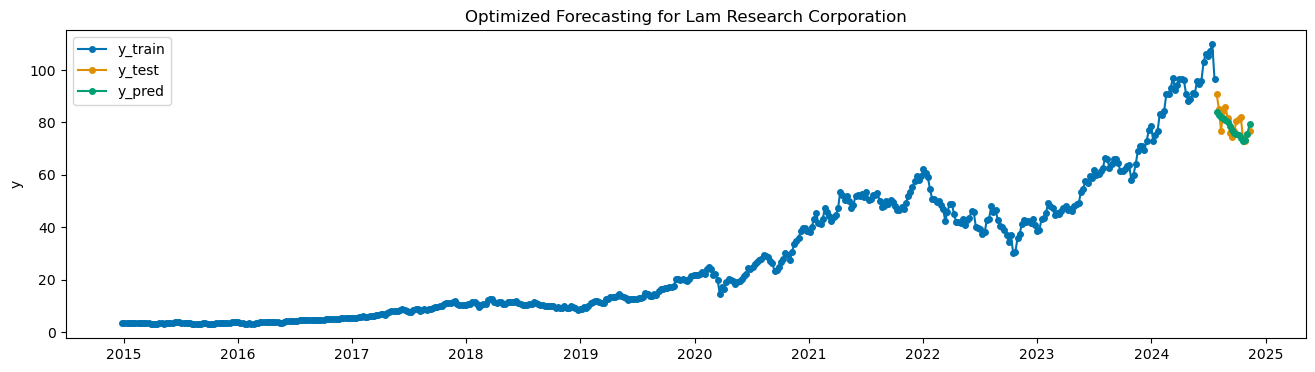

23:23:53 - cmdstanpy - INFO - Chain [1] start processing
23:23:53 - cmdstanpy - INFO - Chain [1] done processing
23:23:53 - cmdstanpy - INFO - Chain [1] start processing
23:23:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1 of 480 for Tokyo Electron Limited...


23:23:53 - cmdstanpy - INFO - Chain [1] start processing
23:23:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2 of 480 for Tokyo Electron Limited...
Processing combination 3 of 480 for Tokyo Electron Limited...


23:23:54 - cmdstanpy - INFO - Chain [1] start processing
23:23:54 - cmdstanpy - INFO - Chain [1] done processing
23:23:54 - cmdstanpy - INFO - Chain [1] start processing
23:23:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 4 of 480 for Tokyo Electron Limited...


23:23:54 - cmdstanpy - INFO - Chain [1] start processing
23:23:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 5 of 480 for Tokyo Electron Limited...


23:23:54 - cmdstanpy - INFO - Chain [1] start processing
23:23:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 6 of 480 for Tokyo Electron Limited...


23:23:55 - cmdstanpy - INFO - Chain [1] start processing
23:23:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 7 of 480 for Tokyo Electron Limited...


23:23:55 - cmdstanpy - INFO - Chain [1] start processing
23:23:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 8 of 480 for Tokyo Electron Limited...


23:23:55 - cmdstanpy - INFO - Chain [1] start processing
23:23:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 9 of 480 for Tokyo Electron Limited...


23:23:55 - cmdstanpy - INFO - Chain [1] start processing
23:23:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 10 of 480 for Tokyo Electron Limited...


23:23:56 - cmdstanpy - INFO - Chain [1] start processing
23:23:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 11 of 480 for Tokyo Electron Limited...


23:23:56 - cmdstanpy - INFO - Chain [1] start processing
23:23:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 12 of 480 for Tokyo Electron Limited...


23:23:56 - cmdstanpy - INFO - Chain [1] start processing
23:23:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 13 of 480 for Tokyo Electron Limited...


23:23:56 - cmdstanpy - INFO - Chain [1] start processing
23:23:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 14 of 480 for Tokyo Electron Limited...


23:23:57 - cmdstanpy - INFO - Chain [1] start processing
23:23:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 15 of 480 for Tokyo Electron Limited...


23:23:57 - cmdstanpy - INFO - Chain [1] start processing
23:23:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 16 of 480 for Tokyo Electron Limited...


23:23:57 - cmdstanpy - INFO - Chain [1] start processing
23:23:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 17 of 480 for Tokyo Electron Limited...


23:23:58 - cmdstanpy - INFO - Chain [1] start processing
23:23:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 18 of 480 for Tokyo Electron Limited...


23:23:58 - cmdstanpy - INFO - Chain [1] start processing
23:23:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 19 of 480 for Tokyo Electron Limited...


23:23:58 - cmdstanpy - INFO - Chain [1] start processing
23:23:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 20 of 480 for Tokyo Electron Limited...


23:23:58 - cmdstanpy - INFO - Chain [1] start processing
23:23:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 21 of 480 for Tokyo Electron Limited...


23:23:59 - cmdstanpy - INFO - Chain [1] start processing
23:23:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 22 of 480 for Tokyo Electron Limited...


23:23:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 23 of 480 for Tokyo Electron Limited...


23:23:59 - cmdstanpy - INFO - Chain [1] done processing
23:23:59 - cmdstanpy - INFO - Chain [1] start processing
23:23:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 24 of 480 for Tokyo Electron Limited...


23:24:00 - cmdstanpy - INFO - Chain [1] start processing
23:24:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 25 of 480 for Tokyo Electron Limited...


23:24:00 - cmdstanpy - INFO - Chain [1] start processing
23:24:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 26 of 480 for Tokyo Electron Limited...


23:24:00 - cmdstanpy - INFO - Chain [1] start processing
23:24:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 27 of 480 for Tokyo Electron Limited...


23:24:00 - cmdstanpy - INFO - Chain [1] start processing
23:24:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 28 of 480 for Tokyo Electron Limited...


23:24:01 - cmdstanpy - INFO - Chain [1] start processing
23:24:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 29 of 480 for Tokyo Electron Limited...


23:24:01 - cmdstanpy - INFO - Chain [1] start processing
23:24:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 30 of 480 for Tokyo Electron Limited...


23:24:01 - cmdstanpy - INFO - Chain [1] start processing
23:24:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 31 of 480 for Tokyo Electron Limited...


23:24:01 - cmdstanpy - INFO - Chain [1] start processing
23:24:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 32 of 480 for Tokyo Electron Limited...


23:24:02 - cmdstanpy - INFO - Chain [1] start processing
23:24:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 33 of 480 for Tokyo Electron Limited...


23:24:02 - cmdstanpy - INFO - Chain [1] start processing
23:24:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 34 of 480 for Tokyo Electron Limited...


23:24:02 - cmdstanpy - INFO - Chain [1] start processing
23:24:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 35 of 480 for Tokyo Electron Limited...


23:24:03 - cmdstanpy - INFO - Chain [1] start processing
23:24:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 36 of 480 for Tokyo Electron Limited...


23:24:03 - cmdstanpy - INFO - Chain [1] start processing
23:24:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 37 of 480 for Tokyo Electron Limited...


23:24:03 - cmdstanpy - INFO - Chain [1] start processing
23:24:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 38 of 480 for Tokyo Electron Limited...


23:24:03 - cmdstanpy - INFO - Chain [1] start processing
23:24:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 39 of 480 for Tokyo Electron Limited...


23:24:04 - cmdstanpy - INFO - Chain [1] start processing
23:24:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 40 of 480 for Tokyo Electron Limited...


23:24:04 - cmdstanpy - INFO - Chain [1] start processing
23:24:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 41 of 480 for Tokyo Electron Limited...


23:24:04 - cmdstanpy - INFO - Chain [1] start processing
23:24:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 42 of 480 for Tokyo Electron Limited...


23:24:04 - cmdstanpy - INFO - Chain [1] start processing
23:24:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 43 of 480 for Tokyo Electron Limited...


23:24:05 - cmdstanpy - INFO - Chain [1] start processing
23:24:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 44 of 480 for Tokyo Electron Limited...


23:24:05 - cmdstanpy - INFO - Chain [1] start processing
23:24:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 45 of 480 for Tokyo Electron Limited...


23:24:05 - cmdstanpy - INFO - Chain [1] start processing
23:24:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 46 of 480 for Tokyo Electron Limited...


23:24:05 - cmdstanpy - INFO - Chain [1] start processing
23:24:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 47 of 480 for Tokyo Electron Limited...


23:24:06 - cmdstanpy - INFO - Chain [1] start processing
23:24:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 48 of 480 for Tokyo Electron Limited...


23:24:06 - cmdstanpy - INFO - Chain [1] start processing
23:24:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 49 of 480 for Tokyo Electron Limited...


23:24:06 - cmdstanpy - INFO - Chain [1] start processing
23:24:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 50 of 480 for Tokyo Electron Limited...


23:24:06 - cmdstanpy - INFO - Chain [1] start processing
23:24:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 51 of 480 for Tokyo Electron Limited...


23:24:07 - cmdstanpy - INFO - Chain [1] start processing
23:24:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 52 of 480 for Tokyo Electron Limited...
Processing combination 53 of 480 for Tokyo Electron Limited...


23:24:07 - cmdstanpy - INFO - Chain [1] start processing
23:24:07 - cmdstanpy - INFO - Chain [1] done processing
23:24:07 - cmdstanpy - INFO - Chain [1] start processing
23:24:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 54 of 480 for Tokyo Electron Limited...


23:24:07 - cmdstanpy - INFO - Chain [1] start processing
23:24:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 55 of 480 for Tokyo Electron Limited...


23:24:08 - cmdstanpy - INFO - Chain [1] start processing
23:24:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 56 of 480 for Tokyo Electron Limited...


23:24:08 - cmdstanpy - INFO - Chain [1] start processing
23:24:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 57 of 480 for Tokyo Electron Limited...


23:24:08 - cmdstanpy - INFO - Chain [1] start processing
23:24:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 58 of 480 for Tokyo Electron Limited...


23:24:08 - cmdstanpy - INFO - Chain [1] start processing
23:24:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 59 of 480 for Tokyo Electron Limited...


23:24:09 - cmdstanpy - INFO - Chain [1] start processing
23:24:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 60 of 480 for Tokyo Electron Limited...


23:24:09 - cmdstanpy - INFO - Chain [1] start processing
23:24:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 61 of 480 for Tokyo Electron Limited...


23:24:09 - cmdstanpy - INFO - Chain [1] start processing
23:24:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 62 of 480 for Tokyo Electron Limited...


23:24:10 - cmdstanpy - INFO - Chain [1] start processing
23:24:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 63 of 480 for Tokyo Electron Limited...


23:24:10 - cmdstanpy - INFO - Chain [1] start processing
23:24:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 64 of 480 for Tokyo Electron Limited...


23:24:10 - cmdstanpy - INFO - Chain [1] start processing
23:24:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 65 of 480 for Tokyo Electron Limited...


23:24:10 - cmdstanpy - INFO - Chain [1] start processing
23:24:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 66 of 480 for Tokyo Electron Limited...


23:24:10 - cmdstanpy - INFO - Chain [1] start processing
23:24:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 67 of 480 for Tokyo Electron Limited...


23:24:11 - cmdstanpy - INFO - Chain [1] start processing
23:24:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 68 of 480 for Tokyo Electron Limited...


23:24:11 - cmdstanpy - INFO - Chain [1] start processing
23:24:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 69 of 480 for Tokyo Electron Limited...


23:24:11 - cmdstanpy - INFO - Chain [1] start processing
23:24:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 70 of 480 for Tokyo Electron Limited...


23:24:11 - cmdstanpy - INFO - Chain [1] start processing
23:24:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 71 of 480 for Tokyo Electron Limited...


23:24:12 - cmdstanpy - INFO - Chain [1] start processing
23:24:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 72 of 480 for Tokyo Electron Limited...


23:24:12 - cmdstanpy - INFO - Chain [1] start processing
23:24:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 73 of 480 for Tokyo Electron Limited...


23:24:12 - cmdstanpy - INFO - Chain [1] start processing
23:24:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 74 of 480 for Tokyo Electron Limited...


23:24:13 - cmdstanpy - INFO - Chain [1] start processing
23:24:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 75 of 480 for Tokyo Electron Limited...


23:24:13 - cmdstanpy - INFO - Chain [1] start processing
23:24:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 76 of 480 for Tokyo Electron Limited...


23:24:13 - cmdstanpy - INFO - Chain [1] start processing
23:24:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 77 of 480 for Tokyo Electron Limited...


23:24:13 - cmdstanpy - INFO - Chain [1] start processing
23:24:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 78 of 480 for Tokyo Electron Limited...


23:24:13 - cmdstanpy - INFO - Chain [1] start processing
23:24:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 79 of 480 for Tokyo Electron Limited...


23:24:14 - cmdstanpy - INFO - Chain [1] start processing
23:24:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 80 of 480 for Tokyo Electron Limited...


23:24:14 - cmdstanpy - INFO - Chain [1] start processing
23:24:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 81 of 480 for Tokyo Electron Limited...


23:24:14 - cmdstanpy - INFO - Chain [1] start processing
23:24:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 82 of 480 for Tokyo Electron Limited...


23:24:14 - cmdstanpy - INFO - Chain [1] start processing
23:24:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 83 of 480 for Tokyo Electron Limited...


23:24:15 - cmdstanpy - INFO - Chain [1] start processing
23:24:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 84 of 480 for Tokyo Electron Limited...


23:24:15 - cmdstanpy - INFO - Chain [1] start processing
23:24:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 85 of 480 for Tokyo Electron Limited...


23:24:15 - cmdstanpy - INFO - Chain [1] start processing
23:24:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 86 of 480 for Tokyo Electron Limited...


23:24:16 - cmdstanpy - INFO - Chain [1] start processing
23:24:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 87 of 480 for Tokyo Electron Limited...


23:24:16 - cmdstanpy - INFO - Chain [1] start processing
23:24:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 88 of 480 for Tokyo Electron Limited...


23:24:16 - cmdstanpy - INFO - Chain [1] start processing
23:24:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 89 of 480 for Tokyo Electron Limited...


23:24:16 - cmdstanpy - INFO - Chain [1] start processing
23:24:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 90 of 480 for Tokyo Electron Limited...


23:24:17 - cmdstanpy - INFO - Chain [1] start processing
23:24:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 91 of 480 for Tokyo Electron Limited...


23:24:17 - cmdstanpy - INFO - Chain [1] start processing
23:24:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 92 of 480 for Tokyo Electron Limited...
Processing combination 93 of 480 for Tokyo Electron Limited...


23:24:17 - cmdstanpy - INFO - Chain [1] start processing
23:24:17 - cmdstanpy - INFO - Chain [1] done processing
23:24:17 - cmdstanpy - INFO - Chain [1] start processing
23:24:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 94 of 480 for Tokyo Electron Limited...


23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 95 of 480 for Tokyo Electron Limited...


23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 96 of 480 for Tokyo Electron Limited...


23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 97 of 480 for Tokyo Electron Limited...


23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 98 of 480 for Tokyo Electron Limited...


23:24:19 - cmdstanpy - INFO - Chain [1] start processing
23:24:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 99 of 480 for Tokyo Electron Limited...


23:24:19 - cmdstanpy - INFO - Chain [1] start processing
23:24:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 100 of 480 for Tokyo Electron Limited...


23:24:19 - cmdstanpy - INFO - Chain [1] start processing
23:24:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 101 of 480 for Tokyo Electron Limited...


23:24:19 - cmdstanpy - INFO - Chain [1] start processing
23:24:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 102 of 480 for Tokyo Electron Limited...


23:24:20 - cmdstanpy - INFO - Chain [1] start processing
23:24:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 103 of 480 for Tokyo Electron Limited...


23:24:20 - cmdstanpy - INFO - Chain [1] start processing
23:24:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 104 of 480 for Tokyo Electron Limited...


23:24:20 - cmdstanpy - INFO - Chain [1] start processing
23:24:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 105 of 480 for Tokyo Electron Limited...


23:24:21 - cmdstanpy - INFO - Chain [1] start processing
23:24:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 106 of 480 for Tokyo Electron Limited...


23:24:21 - cmdstanpy - INFO - Chain [1] start processing
23:24:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 107 of 480 for Tokyo Electron Limited...


23:24:21 - cmdstanpy - INFO - Chain [1] start processing
23:24:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 108 of 480 for Tokyo Electron Limited...


23:24:21 - cmdstanpy - INFO - Chain [1] start processing
23:24:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 109 of 480 for Tokyo Electron Limited...


23:24:22 - cmdstanpy - INFO - Chain [1] start processing
23:24:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 110 of 480 for Tokyo Electron Limited...


23:24:22 - cmdstanpy - INFO - Chain [1] start processing
23:24:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 111 of 480 for Tokyo Electron Limited...


23:24:22 - cmdstanpy - INFO - Chain [1] start processing
23:24:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 112 of 480 for Tokyo Electron Limited...


23:24:23 - cmdstanpy - INFO - Chain [1] start processing
23:24:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 113 of 480 for Tokyo Electron Limited...


23:24:23 - cmdstanpy - INFO - Chain [1] start processing
23:24:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 114 of 480 for Tokyo Electron Limited...


23:24:23 - cmdstanpy - INFO - Chain [1] start processing
23:24:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 115 of 480 for Tokyo Electron Limited...


23:24:23 - cmdstanpy - INFO - Chain [1] start processing
23:24:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 116 of 480 for Tokyo Electron Limited...


23:24:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 117 of 480 for Tokyo Electron Limited...


23:24:24 - cmdstanpy - INFO - Chain [1] done processing
23:24:24 - cmdstanpy - INFO - Chain [1] start processing
23:24:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 118 of 480 for Tokyo Electron Limited...


23:24:24 - cmdstanpy - INFO - Chain [1] start processing
23:24:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 119 of 480 for Tokyo Electron Limited...


23:24:24 - cmdstanpy - INFO - Chain [1] start processing
23:24:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 120 of 480 for Tokyo Electron Limited...


23:24:25 - cmdstanpy - INFO - Chain [1] start processing
23:24:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 121 of 480 for Tokyo Electron Limited...


23:24:25 - cmdstanpy - INFO - Chain [1] start processing
23:24:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 122 of 480 for Tokyo Electron Limited...


23:24:25 - cmdstanpy - INFO - Chain [1] start processing
23:24:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 123 of 480 for Tokyo Electron Limited...


23:24:25 - cmdstanpy - INFO - Chain [1] start processing
23:24:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 124 of 480 for Tokyo Electron Limited...


23:24:26 - cmdstanpy - INFO - Chain [1] start processing
23:24:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 125 of 480 for Tokyo Electron Limited...


23:24:26 - cmdstanpy - INFO - Chain [1] start processing
23:24:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 126 of 480 for Tokyo Electron Limited...


23:24:26 - cmdstanpy - INFO - Chain [1] start processing
23:24:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 127 of 480 for Tokyo Electron Limited...


23:24:26 - cmdstanpy - INFO - Chain [1] start processing
23:24:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 128 of 480 for Tokyo Electron Limited...


23:24:27 - cmdstanpy - INFO - Chain [1] start processing
23:24:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 129 of 480 for Tokyo Electron Limited...


23:24:27 - cmdstanpy - INFO - Chain [1] start processing
23:24:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 130 of 480 for Tokyo Electron Limited...
Processing combination 131 of 480 for Tokyo Electron Limited...


23:24:27 - cmdstanpy - INFO - Chain [1] start processing
23:24:27 - cmdstanpy - INFO - Chain [1] done processing
23:24:27 - cmdstanpy - INFO - Chain [1] start processing
23:24:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 132 of 480 for Tokyo Electron Limited...
Processing combination 133 of 480 for Tokyo Electron Limited...


23:24:28 - cmdstanpy - INFO - Chain [1] start processing
23:24:28 - cmdstanpy - INFO - Chain [1] done processing
23:24:28 - cmdstanpy - INFO - Chain [1] start processing
23:24:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 134 of 480 for Tokyo Electron Limited...


23:24:28 - cmdstanpy - INFO - Chain [1] start processing
23:24:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 135 of 480 for Tokyo Electron Limited...


23:24:28 - cmdstanpy - INFO - Chain [1] start processing
23:24:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 136 of 480 for Tokyo Electron Limited...
Processing combination 137 of 480 for Tokyo Electron Limited...


23:24:29 - cmdstanpy - INFO - Chain [1] start processing
23:24:29 - cmdstanpy - INFO - Chain [1] done processing
23:24:29 - cmdstanpy - INFO - Chain [1] start processing
23:24:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 138 of 480 for Tokyo Electron Limited...


23:24:29 - cmdstanpy - INFO - Chain [1] start processing
23:24:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 139 of 480 for Tokyo Electron Limited...


23:24:29 - cmdstanpy - INFO - Chain [1] start processing
23:24:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 140 of 480 for Tokyo Electron Limited...


23:24:30 - cmdstanpy - INFO - Chain [1] start processing
23:24:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 141 of 480 for Tokyo Electron Limited...


23:24:30 - cmdstanpy - INFO - Chain [1] start processing
23:24:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 142 of 480 for Tokyo Electron Limited...


23:24:30 - cmdstanpy - INFO - Chain [1] start processing
23:24:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 143 of 480 for Tokyo Electron Limited...


23:24:30 - cmdstanpy - INFO - Chain [1] start processing
23:24:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 144 of 480 for Tokyo Electron Limited...
Processing combination 145 of 480 for Tokyo Electron Limited...


23:24:30 - cmdstanpy - INFO - Chain [1] start processing
23:24:31 - cmdstanpy - INFO - Chain [1] done processing
23:24:31 - cmdstanpy - INFO - Chain [1] start processing
23:24:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 146 of 480 for Tokyo Electron Limited...


23:24:31 - cmdstanpy - INFO - Chain [1] start processing
23:24:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 147 of 480 for Tokyo Electron Limited...


23:24:31 - cmdstanpy - INFO - Chain [1] start processing
23:24:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 148 of 480 for Tokyo Electron Limited...


23:24:31 - cmdstanpy - INFO - Chain [1] start processing
23:24:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 149 of 480 for Tokyo Electron Limited...


23:24:32 - cmdstanpy - INFO - Chain [1] start processing
23:24:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 150 of 480 for Tokyo Electron Limited...


23:24:32 - cmdstanpy - INFO - Chain [1] start processing
23:24:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 151 of 480 for Tokyo Electron Limited...


23:24:32 - cmdstanpy - INFO - Chain [1] start processing
23:24:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 152 of 480 for Tokyo Electron Limited...


23:24:33 - cmdstanpy - INFO - Chain [1] start processing
23:24:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 153 of 480 for Tokyo Electron Limited...


23:24:33 - cmdstanpy - INFO - Chain [1] start processing
23:24:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 154 of 480 for Tokyo Electron Limited...


23:24:33 - cmdstanpy - INFO - Chain [1] start processing
23:24:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 155 of 480 for Tokyo Electron Limited...


23:24:33 - cmdstanpy - INFO - Chain [1] start processing
23:24:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 156 of 480 for Tokyo Electron Limited...
Processing combination 157 of 480 for Tokyo Electron Limited...


23:24:33 - cmdstanpy - INFO - Chain [1] start processing
23:24:34 - cmdstanpy - INFO - Chain [1] done processing
23:24:34 - cmdstanpy - INFO - Chain [1] start processing
23:24:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 158 of 480 for Tokyo Electron Limited...


23:24:34 - cmdstanpy - INFO - Chain [1] start processing
23:24:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 159 of 480 for Tokyo Electron Limited...


23:24:34 - cmdstanpy - INFO - Chain [1] start processing
23:24:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 160 of 480 for Tokyo Electron Limited...


23:24:35 - cmdstanpy - INFO - Chain [1] start processing
23:24:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 161 of 480 for Tokyo Electron Limited...


23:24:35 - cmdstanpy - INFO - Chain [1] start processing
23:24:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 162 of 480 for Tokyo Electron Limited...


23:24:35 - cmdstanpy - INFO - Chain [1] start processing
23:24:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 163 of 480 for Tokyo Electron Limited...


23:24:35 - cmdstanpy - INFO - Chain [1] start processing
23:24:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 164 of 480 for Tokyo Electron Limited...


23:24:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 165 of 480 for Tokyo Electron Limited...


23:24:36 - cmdstanpy - INFO - Chain [1] done processing
23:24:36 - cmdstanpy - INFO - Chain [1] start processing
23:24:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 166 of 480 for Tokyo Electron Limited...


23:24:36 - cmdstanpy - INFO - Chain [1] start processing
23:24:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 167 of 480 for Tokyo Electron Limited...


23:24:36 - cmdstanpy - INFO - Chain [1] start processing
23:24:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 168 of 480 for Tokyo Electron Limited...


23:24:37 - cmdstanpy - INFO - Chain [1] start processing
23:24:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 169 of 480 for Tokyo Electron Limited...


23:24:37 - cmdstanpy - INFO - Chain [1] start processing
23:24:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 170 of 480 for Tokyo Electron Limited...


23:24:37 - cmdstanpy - INFO - Chain [1] start processing
23:24:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 171 of 480 for Tokyo Electron Limited...


23:24:37 - cmdstanpy - INFO - Chain [1] start processing
23:24:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 172 of 480 for Tokyo Electron Limited...


23:24:38 - cmdstanpy - INFO - Chain [1] start processing
23:24:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 173 of 480 for Tokyo Electron Limited...


23:24:38 - cmdstanpy - INFO - Chain [1] start processing
23:24:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 174 of 480 for Tokyo Electron Limited...


23:24:38 - cmdstanpy - INFO - Chain [1] start processing
23:24:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 175 of 480 for Tokyo Electron Limited...


23:24:38 - cmdstanpy - INFO - Chain [1] start processing
23:24:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 176 of 480 for Tokyo Electron Limited...


23:24:39 - cmdstanpy - INFO - Chain [1] start processing
23:24:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 177 of 480 for Tokyo Electron Limited...


23:24:39 - cmdstanpy - INFO - Chain [1] start processing
23:24:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 178 of 480 for Tokyo Electron Limited...


23:24:39 - cmdstanpy - INFO - Chain [1] start processing
23:24:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 179 of 480 for Tokyo Electron Limited...


23:24:39 - cmdstanpy - INFO - Chain [1] start processing
23:24:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 180 of 480 for Tokyo Electron Limited...


23:24:40 - cmdstanpy - INFO - Chain [1] start processing
23:24:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 181 of 480 for Tokyo Electron Limited...


23:24:40 - cmdstanpy - INFO - Chain [1] start processing
23:24:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 182 of 480 for Tokyo Electron Limited...


23:24:40 - cmdstanpy - INFO - Chain [1] start processing
23:24:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 183 of 480 for Tokyo Electron Limited...


23:24:40 - cmdstanpy - INFO - Chain [1] start processing
23:24:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 184 of 480 for Tokyo Electron Limited...


23:24:41 - cmdstanpy - INFO - Chain [1] start processing
23:24:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 185 of 480 for Tokyo Electron Limited...


23:24:41 - cmdstanpy - INFO - Chain [1] start processing
23:24:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 186 of 480 for Tokyo Electron Limited...


23:24:41 - cmdstanpy - INFO - Chain [1] start processing
23:24:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 187 of 480 for Tokyo Electron Limited...


23:24:41 - cmdstanpy - INFO - Chain [1] start processing
23:24:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 188 of 480 for Tokyo Electron Limited...


23:24:42 - cmdstanpy - INFO - Chain [1] start processing
23:24:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 189 of 480 for Tokyo Electron Limited...


23:24:42 - cmdstanpy - INFO - Chain [1] start processing
23:24:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 190 of 480 for Tokyo Electron Limited...


23:24:42 - cmdstanpy - INFO - Chain [1] start processing
23:24:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 191 of 480 for Tokyo Electron Limited...


23:24:42 - cmdstanpy - INFO - Chain [1] start processing
23:24:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 192 of 480 for Tokyo Electron Limited...


23:24:43 - cmdstanpy - INFO - Chain [1] start processing
23:24:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 193 of 480 for Tokyo Electron Limited...


23:24:43 - cmdstanpy - INFO - Chain [1] start processing
23:24:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 194 of 480 for Tokyo Electron Limited...


23:24:43 - cmdstanpy - INFO - Chain [1] start processing
23:24:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 195 of 480 for Tokyo Electron Limited...


23:24:43 - cmdstanpy - INFO - Chain [1] start processing
23:24:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 196 of 480 for Tokyo Electron Limited...


23:24:44 - cmdstanpy - INFO - Chain [1] start processing
23:24:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 197 of 480 for Tokyo Electron Limited...


23:24:44 - cmdstanpy - INFO - Chain [1] start processing
23:24:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 198 of 480 for Tokyo Electron Limited...


23:24:44 - cmdstanpy - INFO - Chain [1] start processing
23:24:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 199 of 480 for Tokyo Electron Limited...


23:24:44 - cmdstanpy - INFO - Chain [1] start processing
23:24:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 200 of 480 for Tokyo Electron Limited...
Processing combination 201 of 480 for Tokyo Electron Limited...


23:24:45 - cmdstanpy - INFO - Chain [1] start processing
23:24:45 - cmdstanpy - INFO - Chain [1] done processing
23:24:45 - cmdstanpy - INFO - Chain [1] start processing
23:24:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 202 of 480 for Tokyo Electron Limited...


23:24:45 - cmdstanpy - INFO - Chain [1] start processing
23:24:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 203 of 480 for Tokyo Electron Limited...


23:24:45 - cmdstanpy - INFO - Chain [1] start processing
23:24:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 204 of 480 for Tokyo Electron Limited...
Processing combination 205 of 480 for Tokyo Electron Limited...


23:24:46 - cmdstanpy - INFO - Chain [1] start processing
23:24:46 - cmdstanpy - INFO - Chain [1] done processing
23:24:46 - cmdstanpy - INFO - Chain [1] start processing
23:24:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 206 of 480 for Tokyo Electron Limited...
Processing combination 207 of 480 for Tokyo Electron Limited...


23:24:46 - cmdstanpy - INFO - Chain [1] start processing
23:24:46 - cmdstanpy - INFO - Chain [1] done processing
23:24:46 - cmdstanpy - INFO - Chain [1] start processing
23:24:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 208 of 480 for Tokyo Electron Limited...
Processing combination 209 of 480 for Tokyo Electron Limited...


23:24:47 - cmdstanpy - INFO - Chain [1] start processing
23:24:47 - cmdstanpy - INFO - Chain [1] done processing
23:24:47 - cmdstanpy - INFO - Chain [1] start processing
23:24:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 210 of 480 for Tokyo Electron Limited...


23:24:47 - cmdstanpy - INFO - Chain [1] start processing
23:24:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 211 of 480 for Tokyo Electron Limited...


23:24:47 - cmdstanpy - INFO - Chain [1] start processing
23:24:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 212 of 480 for Tokyo Electron Limited...


23:24:48 - cmdstanpy - INFO - Chain [1] start processing
23:24:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 213 of 480 for Tokyo Electron Limited...


23:24:48 - cmdstanpy - INFO - Chain [1] start processing
23:24:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 214 of 480 for Tokyo Electron Limited...


23:24:48 - cmdstanpy - INFO - Chain [1] start processing
23:24:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 215 of 480 for Tokyo Electron Limited...


23:24:48 - cmdstanpy - INFO - Chain [1] start processing
23:24:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 216 of 480 for Tokyo Electron Limited...


23:24:49 - cmdstanpy - INFO - Chain [1] start processing
23:24:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 217 of 480 for Tokyo Electron Limited...


23:24:49 - cmdstanpy - INFO - Chain [1] start processing
23:24:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 218 of 480 for Tokyo Electron Limited...


23:24:49 - cmdstanpy - INFO - Chain [1] start processing
23:24:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 219 of 480 for Tokyo Electron Limited...


23:24:49 - cmdstanpy - INFO - Chain [1] start processing
23:24:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 220 of 480 for Tokyo Electron Limited...


23:24:50 - cmdstanpy - INFO - Chain [1] start processing
23:24:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 221 of 480 for Tokyo Electron Limited...


23:24:50 - cmdstanpy - INFO - Chain [1] start processing
23:24:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 222 of 480 for Tokyo Electron Limited...


23:24:50 - cmdstanpy - INFO - Chain [1] start processing
23:24:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 223 of 480 for Tokyo Electron Limited...


23:24:50 - cmdstanpy - INFO - Chain [1] start processing
23:24:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 224 of 480 for Tokyo Electron Limited...


23:24:51 - cmdstanpy - INFO - Chain [1] start processing
23:24:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 225 of 480 for Tokyo Electron Limited...


23:24:51 - cmdstanpy - INFO - Chain [1] start processing
23:24:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 226 of 480 for Tokyo Electron Limited...


23:24:51 - cmdstanpy - INFO - Chain [1] start processing
23:24:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 227 of 480 for Tokyo Electron Limited...


23:24:51 - cmdstanpy - INFO - Chain [1] start processing
23:24:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 228 of 480 for Tokyo Electron Limited...


23:24:52 - cmdstanpy - INFO - Chain [1] start processing
23:24:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 229 of 480 for Tokyo Electron Limited...


23:24:52 - cmdstanpy - INFO - Chain [1] start processing
23:24:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 230 of 480 for Tokyo Electron Limited...


23:24:52 - cmdstanpy - INFO - Chain [1] start processing
23:24:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 231 of 480 for Tokyo Electron Limited...


23:24:52 - cmdstanpy - INFO - Chain [1] start processing
23:24:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 232 of 480 for Tokyo Electron Limited...
Processing combination 233 of 480 for Tokyo Electron Limited...


23:24:53 - cmdstanpy - INFO - Chain [1] start processing
23:24:53 - cmdstanpy - INFO - Chain [1] done processing
23:24:53 - cmdstanpy - INFO - Chain [1] start processing
23:24:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 234 of 480 for Tokyo Electron Limited...


23:24:53 - cmdstanpy - INFO - Chain [1] start processing
23:24:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 235 of 480 for Tokyo Electron Limited...


23:24:53 - cmdstanpy - INFO - Chain [1] start processing
23:24:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 236 of 480 for Tokyo Electron Limited...


23:24:54 - cmdstanpy - INFO - Chain [1] start processing
23:24:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 237 of 480 for Tokyo Electron Limited...


23:24:54 - cmdstanpy - INFO - Chain [1] start processing
23:24:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 238 of 480 for Tokyo Electron Limited...


23:24:54 - cmdstanpy - INFO - Chain [1] start processing
23:24:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 239 of 480 for Tokyo Electron Limited...


23:24:54 - cmdstanpy - INFO - Chain [1] start processing
23:24:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 240 of 480 for Tokyo Electron Limited...


23:24:55 - cmdstanpy - INFO - Chain [1] start processing
23:24:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 241 of 480 for Tokyo Electron Limited...


23:24:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 242 of 480 for Tokyo Electron Limited...


23:24:55 - cmdstanpy - INFO - Chain [1] done processing
23:24:55 - cmdstanpy - INFO - Chain [1] start processing
23:24:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 243 of 480 for Tokyo Electron Limited...


23:24:56 - cmdstanpy - INFO - Chain [1] start processing
23:24:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 244 of 480 for Tokyo Electron Limited...


23:24:56 - cmdstanpy - INFO - Chain [1] start processing
23:24:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 245 of 480 for Tokyo Electron Limited...


23:24:56 - cmdstanpy - INFO - Chain [1] start processing
23:24:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 246 of 480 for Tokyo Electron Limited...


23:24:56 - cmdstanpy - INFO - Chain [1] start processing
23:24:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 247 of 480 for Tokyo Electron Limited...


23:24:57 - cmdstanpy - INFO - Chain [1] start processing
23:24:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 248 of 480 for Tokyo Electron Limited...


23:24:57 - cmdstanpy - INFO - Chain [1] start processing
23:24:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 249 of 480 for Tokyo Electron Limited...


23:24:57 - cmdstanpy - INFO - Chain [1] start processing
23:24:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 250 of 480 for Tokyo Electron Limited...


23:24:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 251 of 480 for Tokyo Electron Limited...


23:24:58 - cmdstanpy - INFO - Chain [1] done processing
23:24:58 - cmdstanpy - INFO - Chain [1] start processing
23:24:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 252 of 480 for Tokyo Electron Limited...


23:24:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 253 of 480 for Tokyo Electron Limited...


23:24:58 - cmdstanpy - INFO - Chain [1] done processing
23:24:59 - cmdstanpy - INFO - Chain [1] start processing
23:24:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 254 of 480 for Tokyo Electron Limited...


23:24:59 - cmdstanpy - INFO - Chain [1] start processing
23:24:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 255 of 480 for Tokyo Electron Limited...


23:24:59 - cmdstanpy - INFO - Chain [1] start processing
23:24:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 256 of 480 for Tokyo Electron Limited...


23:24:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 257 of 480 for Tokyo Electron Limited...


23:24:59 - cmdstanpy - INFO - Chain [1] done processing
23:25:00 - cmdstanpy - INFO - Chain [1] start processing
23:25:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 258 of 480 for Tokyo Electron Limited...


23:25:00 - cmdstanpy - INFO - Chain [1] start processing
23:25:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 259 of 480 for Tokyo Electron Limited...


23:25:00 - cmdstanpy - INFO - Chain [1] start processing
23:25:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 260 of 480 for Tokyo Electron Limited...


23:25:01 - cmdstanpy - INFO - Chain [1] start processing
23:25:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 261 of 480 for Tokyo Electron Limited...


23:25:01 - cmdstanpy - INFO - Chain [1] start processing
23:25:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 262 of 480 for Tokyo Electron Limited...


23:25:01 - cmdstanpy - INFO - Chain [1] start processing
23:25:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 263 of 480 for Tokyo Electron Limited...


23:25:01 - cmdstanpy - INFO - Chain [1] start processing
23:25:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 264 of 480 for Tokyo Electron Limited...


23:25:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 265 of 480 for Tokyo Electron Limited...


23:25:02 - cmdstanpy - INFO - Chain [1] done processing
23:25:02 - cmdstanpy - INFO - Chain [1] start processing
23:25:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 266 of 480 for Tokyo Electron Limited...


23:25:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 267 of 480 for Tokyo Electron Limited...


23:25:02 - cmdstanpy - INFO - Chain [1] done processing
23:25:03 - cmdstanpy - INFO - Chain [1] start processing
23:25:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 268 of 480 for Tokyo Electron Limited...


23:25:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 269 of 480 for Tokyo Electron Limited...


23:25:03 - cmdstanpy - INFO - Chain [1] done processing
23:25:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 270 of 480 for Tokyo Electron Limited...


23:25:04 - cmdstanpy - INFO - Chain [1] done processing
23:25:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 271 of 480 for Tokyo Electron Limited...


23:25:04 - cmdstanpy - INFO - Chain [1] done processing
23:25:04 - cmdstanpy - INFO - Chain [1] start processing
23:25:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 272 of 480 for Tokyo Electron Limited...


23:25:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 273 of 480 for Tokyo Electron Limited...


23:25:05 - cmdstanpy - INFO - Chain [1] done processing
23:25:05 - cmdstanpy - INFO - Chain [1] start processing
23:25:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 274 of 480 for Tokyo Electron Limited...


23:25:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 275 of 480 for Tokyo Electron Limited...


23:25:05 - cmdstanpy - INFO - Chain [1] done processing
23:25:05 - cmdstanpy - INFO - Chain [1] start processing
23:25:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 276 of 480 for Tokyo Electron Limited...


23:25:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 277 of 480 for Tokyo Electron Limited...


23:25:06 - cmdstanpy - INFO - Chain [1] done processing
23:25:06 - cmdstanpy - INFO - Chain [1] start processing
23:25:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 278 of 480 for Tokyo Electron Limited...


23:25:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 279 of 480 for Tokyo Electron Limited...


23:25:07 - cmdstanpy - INFO - Chain [1] done processing
23:25:07 - cmdstanpy - INFO - Chain [1] start processing
23:25:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 280 of 480 for Tokyo Electron Limited...


23:25:07 - cmdstanpy - INFO - Chain [1] start processing
23:25:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 281 of 480 for Tokyo Electron Limited...


23:25:08 - cmdstanpy - INFO - Chain [1] start processing
23:25:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 282 of 480 for Tokyo Electron Limited...


23:25:08 - cmdstanpy - INFO - Chain [1] start processing
23:25:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 283 of 480 for Tokyo Electron Limited...


23:25:08 - cmdstanpy - INFO - Chain [1] start processing
23:25:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 284 of 480 for Tokyo Electron Limited...


23:25:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 285 of 480 for Tokyo Electron Limited...


23:25:08 - cmdstanpy - INFO - Chain [1] done processing
23:25:09 - cmdstanpy - INFO - Chain [1] start processing
23:25:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 286 of 480 for Tokyo Electron Limited...


23:25:09 - cmdstanpy - INFO - Chain [1] start processing
23:25:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 287 of 480 for Tokyo Electron Limited...


23:25:09 - cmdstanpy - INFO - Chain [1] start processing
23:25:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 288 of 480 for Tokyo Electron Limited...


23:25:09 - cmdstanpy - INFO - Chain [1] start processing
23:25:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 289 of 480 for Tokyo Electron Limited...


23:25:10 - cmdstanpy - INFO - Chain [1] start processing
23:25:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 290 of 480 for Tokyo Electron Limited...


23:25:10 - cmdstanpy - INFO - Chain [1] start processing
23:25:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 291 of 480 for Tokyo Electron Limited...


23:25:10 - cmdstanpy - INFO - Chain [1] start processing
23:25:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 292 of 480 for Tokyo Electron Limited...
Processing combination 293 of 480 for Tokyo Electron Limited...


23:25:10 - cmdstanpy - INFO - Chain [1] start processing
23:25:10 - cmdstanpy - INFO - Chain [1] done processing
23:25:11 - cmdstanpy - INFO - Chain [1] start processing
23:25:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 294 of 480 for Tokyo Electron Limited...


23:25:11 - cmdstanpy - INFO - Chain [1] start processing
23:25:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 295 of 480 for Tokyo Electron Limited...


23:25:11 - cmdstanpy - INFO - Chain [1] start processing
23:25:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 296 of 480 for Tokyo Electron Limited...
Processing combination 297 of 480 for Tokyo Electron Limited...


23:25:11 - cmdstanpy - INFO - Chain [1] start processing
23:25:11 - cmdstanpy - INFO - Chain [1] done processing
23:25:12 - cmdstanpy - INFO - Chain [1] start processing
23:25:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 298 of 480 for Tokyo Electron Limited...


23:25:12 - cmdstanpy - INFO - Chain [1] start processing
23:25:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 299 of 480 for Tokyo Electron Limited...


23:25:12 - cmdstanpy - INFO - Chain [1] start processing
23:25:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 300 of 480 for Tokyo Electron Limited...
Processing combination 301 of 480 for Tokyo Electron Limited...


23:25:12 - cmdstanpy - INFO - Chain [1] start processing
23:25:12 - cmdstanpy - INFO - Chain [1] done processing
23:25:13 - cmdstanpy - INFO - Chain [1] start processing
23:25:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 302 of 480 for Tokyo Electron Limited...


23:25:13 - cmdstanpy - INFO - Chain [1] start processing
23:25:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 303 of 480 for Tokyo Electron Limited...


23:25:13 - cmdstanpy - INFO - Chain [1] start processing
23:25:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 304 of 480 for Tokyo Electron Limited...


23:25:13 - cmdstanpy - INFO - Chain [1] start processing
23:25:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 305 of 480 for Tokyo Electron Limited...


23:25:14 - cmdstanpy - INFO - Chain [1] start processing
23:25:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 306 of 480 for Tokyo Electron Limited...


23:25:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 307 of 480 for Tokyo Electron Limited...


23:25:14 - cmdstanpy - INFO - Chain [1] done processing
23:25:14 - cmdstanpy - INFO - Chain [1] start processing
23:25:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 308 of 480 for Tokyo Electron Limited...


23:25:14 - cmdstanpy - INFO - Chain [1] start processing
23:25:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 309 of 480 for Tokyo Electron Limited...


23:25:15 - cmdstanpy - INFO - Chain [1] start processing
23:25:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 310 of 480 for Tokyo Electron Limited...


23:25:15 - cmdstanpy - INFO - Chain [1] start processing
23:25:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 311 of 480 for Tokyo Electron Limited...


23:25:15 - cmdstanpy - INFO - Chain [1] start processing
23:25:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 312 of 480 for Tokyo Electron Limited...


23:25:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 313 of 480 for Tokyo Electron Limited...


23:25:16 - cmdstanpy - INFO - Chain [1] done processing
23:25:16 - cmdstanpy - INFO - Chain [1] start processing
23:25:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 314 of 480 for Tokyo Electron Limited...


23:25:16 - cmdstanpy - INFO - Chain [1] start processing
23:25:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 315 of 480 for Tokyo Electron Limited...


23:25:16 - cmdstanpy - INFO - Chain [1] start processing
23:25:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 316 of 480 for Tokyo Electron Limited...


23:25:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 317 of 480 for Tokyo Electron Limited...


23:25:17 - cmdstanpy - INFO - Chain [1] done processing
23:25:17 - cmdstanpy - INFO - Chain [1] start processing
23:25:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 318 of 480 for Tokyo Electron Limited...


23:25:17 - cmdstanpy - INFO - Chain [1] start processing
23:25:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 319 of 480 for Tokyo Electron Limited...


23:25:17 - cmdstanpy - INFO - Chain [1] start processing
23:25:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 320 of 480 for Tokyo Electron Limited...


23:25:18 - cmdstanpy - INFO - Chain [1] start processing
23:25:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 321 of 480 for Tokyo Electron Limited...


23:25:18 - cmdstanpy - INFO - Chain [1] start processing
23:25:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 322 of 480 for Tokyo Electron Limited...


23:25:18 - cmdstanpy - INFO - Chain [1] start processing
23:25:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 323 of 480 for Tokyo Electron Limited...


23:25:19 - cmdstanpy - INFO - Chain [1] start processing
23:25:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 324 of 480 for Tokyo Electron Limited...


23:25:19 - cmdstanpy - INFO - Chain [1] start processing
23:25:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 325 of 480 for Tokyo Electron Limited...


23:25:19 - cmdstanpy - INFO - Chain [1] start processing
23:25:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 326 of 480 for Tokyo Electron Limited...


23:25:19 - cmdstanpy - INFO - Chain [1] start processing
23:25:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 327 of 480 for Tokyo Electron Limited...


23:25:20 - cmdstanpy - INFO - Chain [1] start processing
23:25:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 328 of 480 for Tokyo Electron Limited...


23:25:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 329 of 480 for Tokyo Electron Limited...


23:25:20 - cmdstanpy - INFO - Chain [1] done processing
23:25:20 - cmdstanpy - INFO - Chain [1] start processing
23:25:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 330 of 480 for Tokyo Electron Limited...


23:25:21 - cmdstanpy - INFO - Chain [1] start processing
23:25:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 331 of 480 for Tokyo Electron Limited...


23:25:21 - cmdstanpy - INFO - Chain [1] start processing
23:25:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 332 of 480 for Tokyo Electron Limited...


23:25:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 333 of 480 for Tokyo Electron Limited...


23:25:21 - cmdstanpy - INFO - Chain [1] done processing
23:25:21 - cmdstanpy - INFO - Chain [1] start processing
23:25:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 334 of 480 for Tokyo Electron Limited...


23:25:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 335 of 480 for Tokyo Electron Limited...


23:25:22 - cmdstanpy - INFO - Chain [1] done processing
23:25:22 - cmdstanpy - INFO - Chain [1] start processing
23:25:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 336 of 480 for Tokyo Electron Limited...


23:25:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 337 of 480 for Tokyo Electron Limited...


23:25:22 - cmdstanpy - INFO - Chain [1] done processing
23:25:23 - cmdstanpy - INFO - Chain [1] start processing
23:25:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 338 of 480 for Tokyo Electron Limited...


23:25:23 - cmdstanpy - INFO - Chain [1] start processing
23:25:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 339 of 480 for Tokyo Electron Limited...


23:25:23 - cmdstanpy - INFO - Chain [1] start processing
23:25:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 340 of 480 for Tokyo Electron Limited...


23:25:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 341 of 480 for Tokyo Electron Limited...


23:25:24 - cmdstanpy - INFO - Chain [1] done processing
23:25:24 - cmdstanpy - INFO - Chain [1] start processing
23:25:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 342 of 480 for Tokyo Electron Limited...


23:25:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 343 of 480 for Tokyo Electron Limited...


23:25:24 - cmdstanpy - INFO - Chain [1] done processing
23:25:24 - cmdstanpy - INFO - Chain [1] start processing
23:25:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 344 of 480 for Tokyo Electron Limited...


23:25:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 345 of 480 for Tokyo Electron Limited...


23:25:25 - cmdstanpy - INFO - Chain [1] done processing
23:25:25 - cmdstanpy - INFO - Chain [1] start processing
23:25:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 346 of 480 for Tokyo Electron Limited...


23:25:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 347 of 480 for Tokyo Electron Limited...


23:25:26 - cmdstanpy - INFO - Chain [1] done processing
23:25:26 - cmdstanpy - INFO - Chain [1] start processing
23:25:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 348 of 480 for Tokyo Electron Limited...


23:25:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 349 of 480 for Tokyo Electron Limited...


23:25:26 - cmdstanpy - INFO - Chain [1] done processing
23:25:27 - cmdstanpy - INFO - Chain [1] start processing
23:25:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 350 of 480 for Tokyo Electron Limited...


23:25:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 351 of 480 for Tokyo Electron Limited...


23:25:27 - cmdstanpy - INFO - Chain [1] done processing
23:25:27 - cmdstanpy - INFO - Chain [1] start processing
23:25:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 352 of 480 for Tokyo Electron Limited...


23:25:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 353 of 480 for Tokyo Electron Limited...


23:25:28 - cmdstanpy - INFO - Chain [1] done processing
23:25:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 354 of 480 for Tokyo Electron Limited...


23:25:28 - cmdstanpy - INFO - Chain [1] done processing
23:25:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 355 of 480 for Tokyo Electron Limited...


23:25:29 - cmdstanpy - INFO - Chain [1] done processing
23:25:29 - cmdstanpy - INFO - Chain [1] start processing
23:25:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 356 of 480 for Tokyo Electron Limited...


23:25:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 357 of 480 for Tokyo Electron Limited...


23:25:29 - cmdstanpy - INFO - Chain [1] done processing
23:25:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 358 of 480 for Tokyo Electron Limited...


23:25:30 - cmdstanpy - INFO - Chain [1] done processing
23:25:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 359 of 480 for Tokyo Electron Limited...


23:25:30 - cmdstanpy - INFO - Chain [1] done processing
23:25:30 - cmdstanpy - INFO - Chain [1] start processing
23:25:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 360 of 480 for Tokyo Electron Limited...


23:25:31 - cmdstanpy - INFO - Chain [1] start processing
23:25:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 361 of 480 for Tokyo Electron Limited...


23:25:31 - cmdstanpy - INFO - Chain [1] start processing
23:25:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 362 of 480 for Tokyo Electron Limited...


23:25:31 - cmdstanpy - INFO - Chain [1] start processing
23:25:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 363 of 480 for Tokyo Electron Limited...


23:25:31 - cmdstanpy - INFO - Chain [1] start processing
23:25:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 364 of 480 for Tokyo Electron Limited...


23:25:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 365 of 480 for Tokyo Electron Limited...


23:25:32 - cmdstanpy - INFO - Chain [1] done processing
23:25:32 - cmdstanpy - INFO - Chain [1] start processing
23:25:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 366 of 480 for Tokyo Electron Limited...


23:25:32 - cmdstanpy - INFO - Chain [1] start processing
23:25:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 367 of 480 for Tokyo Electron Limited...


23:25:32 - cmdstanpy - INFO - Chain [1] start processing
23:25:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 368 of 480 for Tokyo Electron Limited...


23:25:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 369 of 480 for Tokyo Electron Limited...


23:25:33 - cmdstanpy - INFO - Chain [1] done processing
23:25:33 - cmdstanpy - INFO - Chain [1] start processing
23:25:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 370 of 480 for Tokyo Electron Limited...


23:25:33 - cmdstanpy - INFO - Chain [1] start processing
23:25:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 371 of 480 for Tokyo Electron Limited...


23:25:34 - cmdstanpy - INFO - Chain [1] start processing
23:25:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 372 of 480 for Tokyo Electron Limited...


23:25:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 373 of 480 for Tokyo Electron Limited...


23:25:34 - cmdstanpy - INFO - Chain [1] done processing
23:25:34 - cmdstanpy - INFO - Chain [1] start processing
23:25:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 374 of 480 for Tokyo Electron Limited...


23:25:34 - cmdstanpy - INFO - Chain [1] start processing
23:25:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 375 of 480 for Tokyo Electron Limited...


23:25:35 - cmdstanpy - INFO - Chain [1] start processing
23:25:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 376 of 480 for Tokyo Electron Limited...


23:25:35 - cmdstanpy - INFO - Chain [1] start processing
23:25:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 377 of 480 for Tokyo Electron Limited...


23:25:35 - cmdstanpy - INFO - Chain [1] start processing
23:25:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 378 of 480 for Tokyo Electron Limited...


23:25:35 - cmdstanpy - INFO - Chain [1] start processing
23:25:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 379 of 480 for Tokyo Electron Limited...


23:25:36 - cmdstanpy - INFO - Chain [1] start processing
23:25:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 380 of 480 for Tokyo Electron Limited...


23:25:36 - cmdstanpy - INFO - Chain [1] start processing
23:25:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 381 of 480 for Tokyo Electron Limited...


23:25:36 - cmdstanpy - INFO - Chain [1] start processing
23:25:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 382 of 480 for Tokyo Electron Limited...


23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 383 of 480 for Tokyo Electron Limited...


23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 384 of 480 for Tokyo Electron Limited...


23:25:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 385 of 480 for Tokyo Electron Limited...


23:25:37 - cmdstanpy - INFO - Chain [1] done processing
23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 386 of 480 for Tokyo Electron Limited...


23:25:38 - cmdstanpy - INFO - Chain [1] start processing
23:25:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 387 of 480 for Tokyo Electron Limited...


23:25:38 - cmdstanpy - INFO - Chain [1] start processing
23:25:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 388 of 480 for Tokyo Electron Limited...


23:25:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 389 of 480 for Tokyo Electron Limited...


23:25:38 - cmdstanpy - INFO - Chain [1] done processing
23:25:38 - cmdstanpy - INFO - Chain [1] start processing
23:25:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 390 of 480 for Tokyo Electron Limited...


23:25:39 - cmdstanpy - INFO - Chain [1] start processing
23:25:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 391 of 480 for Tokyo Electron Limited...


23:25:39 - cmdstanpy - INFO - Chain [1] start processing
23:25:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 392 of 480 for Tokyo Electron Limited...


23:25:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 393 of 480 for Tokyo Electron Limited...


23:25:40 - cmdstanpy - INFO - Chain [1] done processing
23:25:40 - cmdstanpy - INFO - Chain [1] start processing
23:25:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 394 of 480 for Tokyo Electron Limited...


23:25:40 - cmdstanpy - INFO - Chain [1] start processing
23:25:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 395 of 480 for Tokyo Electron Limited...


23:25:40 - cmdstanpy - INFO - Chain [1] start processing
23:25:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 396 of 480 for Tokyo Electron Limited...


23:25:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 397 of 480 for Tokyo Electron Limited...


23:25:41 - cmdstanpy - INFO - Chain [1] done processing
23:25:41 - cmdstanpy - INFO - Chain [1] start processing
23:25:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 398 of 480 for Tokyo Electron Limited...


23:25:41 - cmdstanpy - INFO - Chain [1] start processing
23:25:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 399 of 480 for Tokyo Electron Limited...


23:25:41 - cmdstanpy - INFO - Chain [1] start processing
23:25:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 400 of 480 for Tokyo Electron Limited...


23:25:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 401 of 480 for Tokyo Electron Limited...


23:25:42 - cmdstanpy - INFO - Chain [1] done processing
23:25:42 - cmdstanpy - INFO - Chain [1] start processing
23:25:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 402 of 480 for Tokyo Electron Limited...


23:25:42 - cmdstanpy - INFO - Chain [1] start processing
23:25:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 403 of 480 for Tokyo Electron Limited...


23:25:43 - cmdstanpy - INFO - Chain [1] start processing
23:25:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 404 of 480 for Tokyo Electron Limited...


23:25:43 - cmdstanpy - INFO - Chain [1] start processing
23:25:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 405 of 480 for Tokyo Electron Limited...


23:25:43 - cmdstanpy - INFO - Chain [1] start processing
23:25:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 406 of 480 for Tokyo Electron Limited...


23:25:44 - cmdstanpy - INFO - Chain [1] start processing
23:25:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 407 of 480 for Tokyo Electron Limited...


23:25:44 - cmdstanpy - INFO - Chain [1] start processing
23:25:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 408 of 480 for Tokyo Electron Limited...


23:25:44 - cmdstanpy - INFO - Chain [1] start processing
23:25:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 409 of 480 for Tokyo Electron Limited...


23:25:44 - cmdstanpy - INFO - Chain [1] start processing
23:25:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 410 of 480 for Tokyo Electron Limited...


23:25:45 - cmdstanpy - INFO - Chain [1] start processing
23:25:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 411 of 480 for Tokyo Electron Limited...


23:25:45 - cmdstanpy - INFO - Chain [1] start processing
23:25:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 412 of 480 for Tokyo Electron Limited...


23:25:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 413 of 480 for Tokyo Electron Limited...


23:25:45 - cmdstanpy - INFO - Chain [1] done processing
23:25:46 - cmdstanpy - INFO - Chain [1] start processing
23:25:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 414 of 480 for Tokyo Electron Limited...


23:25:46 - cmdstanpy - INFO - Chain [1] start processing
23:25:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 415 of 480 for Tokyo Electron Limited...


23:25:46 - cmdstanpy - INFO - Chain [1] start processing
23:25:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 416 of 480 for Tokyo Electron Limited...


23:25:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 417 of 480 for Tokyo Electron Limited...


23:25:46 - cmdstanpy - INFO - Chain [1] done processing
23:25:47 - cmdstanpy - INFO - Chain [1] start processing
23:25:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 418 of 480 for Tokyo Electron Limited...


23:25:47 - cmdstanpy - INFO - Chain [1] start processing
23:25:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 419 of 480 for Tokyo Electron Limited...


23:25:47 - cmdstanpy - INFO - Chain [1] start processing
23:25:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 420 of 480 for Tokyo Electron Limited...


23:25:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 421 of 480 for Tokyo Electron Limited...


23:25:48 - cmdstanpy - INFO - Chain [1] done processing
23:25:48 - cmdstanpy - INFO - Chain [1] start processing
23:25:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 422 of 480 for Tokyo Electron Limited...


23:25:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 423 of 480 for Tokyo Electron Limited...


23:25:48 - cmdstanpy - INFO - Chain [1] done processing
23:25:49 - cmdstanpy - INFO - Chain [1] start processing
23:25:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 424 of 480 for Tokyo Electron Limited...


23:25:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 425 of 480 for Tokyo Electron Limited...


23:25:49 - cmdstanpy - INFO - Chain [1] done processing
23:25:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 426 of 480 for Tokyo Electron Limited...


23:25:49 - cmdstanpy - INFO - Chain [1] done processing
23:25:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 427 of 480 for Tokyo Electron Limited...


23:25:50 - cmdstanpy - INFO - Chain [1] done processing
23:25:50 - cmdstanpy - INFO - Chain [1] start processing
23:25:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 428 of 480 for Tokyo Electron Limited...


23:25:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 429 of 480 for Tokyo Electron Limited...


23:25:51 - cmdstanpy - INFO - Chain [1] done processing
23:25:51 - cmdstanpy - INFO - Chain [1] start processing
23:25:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 430 of 480 for Tokyo Electron Limited...


23:25:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 431 of 480 for Tokyo Electron Limited...


23:25:51 - cmdstanpy - INFO - Chain [1] done processing
23:25:52 - cmdstanpy - INFO - Chain [1] start processing
23:25:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 432 of 480 for Tokyo Electron Limited...


23:25:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 433 of 480 for Tokyo Electron Limited...


23:25:52 - cmdstanpy - INFO - Chain [1] done processing
23:25:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 434 of 480 for Tokyo Electron Limited...


23:25:53 - cmdstanpy - INFO - Chain [1] done processing
23:25:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 435 of 480 for Tokyo Electron Limited...


23:25:53 - cmdstanpy - INFO - Chain [1] done processing
23:25:53 - cmdstanpy - INFO - Chain [1] start processing
23:25:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 436 of 480 for Tokyo Electron Limited...


23:25:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 437 of 480 for Tokyo Electron Limited...


23:25:54 - cmdstanpy - INFO - Chain [1] done processing
23:25:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 438 of 480 for Tokyo Electron Limited...


23:25:54 - cmdstanpy - INFO - Chain [1] done processing
23:25:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 439 of 480 for Tokyo Electron Limited...


23:25:54 - cmdstanpy - INFO - Chain [1] done processing
23:25:55 - cmdstanpy - INFO - Chain [1] start processing
23:25:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 440 of 480 for Tokyo Electron Limited...


23:25:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 441 of 480 for Tokyo Electron Limited...


23:25:55 - cmdstanpy - INFO - Chain [1] done processing
23:25:55 - cmdstanpy - INFO - Chain [1] start processing
23:25:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 442 of 480 for Tokyo Electron Limited...


23:25:55 - cmdstanpy - INFO - Chain [1] start processing
23:25:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 443 of 480 for Tokyo Electron Limited...


23:25:56 - cmdstanpy - INFO - Chain [1] start processing
23:25:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 444 of 480 for Tokyo Electron Limited...


23:25:56 - cmdstanpy - INFO - Chain [1] start processing
23:25:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 445 of 480 for Tokyo Electron Limited...


23:25:56 - cmdstanpy - INFO - Chain [1] start processing
23:25:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 446 of 480 for Tokyo Electron Limited...


23:25:56 - cmdstanpy - INFO - Chain [1] start processing
23:25:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 447 of 480 for Tokyo Electron Limited...


23:25:57 - cmdstanpy - INFO - Chain [1] start processing
23:25:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 448 of 480 for Tokyo Electron Limited...


23:25:57 - cmdstanpy - INFO - Chain [1] start processing
23:25:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 449 of 480 for Tokyo Electron Limited...


23:25:57 - cmdstanpy - INFO - Chain [1] start processing
23:25:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 450 of 480 for Tokyo Electron Limited...


23:25:57 - cmdstanpy - INFO - Chain [1] start processing
23:25:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 451 of 480 for Tokyo Electron Limited...


23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 452 of 480 for Tokyo Electron Limited...


23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 453 of 480 for Tokyo Electron Limited...


23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 454 of 480 for Tokyo Electron Limited...


23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 455 of 480 for Tokyo Electron Limited...


23:25:59 - cmdstanpy - INFO - Chain [1] start processing
23:25:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 456 of 480 for Tokyo Electron Limited...
Processing combination 457 of 480 for Tokyo Electron Limited...


23:25:59 - cmdstanpy - INFO - Chain [1] start processing
23:25:59 - cmdstanpy - INFO - Chain [1] done processing
23:25:59 - cmdstanpy - INFO - Chain [1] start processing
23:25:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 458 of 480 for Tokyo Electron Limited...


23:26:00 - cmdstanpy - INFO - Chain [1] start processing
23:26:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 459 of 480 for Tokyo Electron Limited...


23:26:00 - cmdstanpy - INFO - Chain [1] start processing
23:26:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 460 of 480 for Tokyo Electron Limited...


23:26:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 461 of 480 for Tokyo Electron Limited...


23:26:00 - cmdstanpy - INFO - Chain [1] done processing
23:26:00 - cmdstanpy - INFO - Chain [1] start processing
23:26:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 462 of 480 for Tokyo Electron Limited...


23:26:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 463 of 480 for Tokyo Electron Limited...


23:26:01 - cmdstanpy - INFO - Chain [1] done processing
23:26:01 - cmdstanpy - INFO - Chain [1] start processing
23:26:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 464 of 480 for Tokyo Electron Limited...


23:26:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 465 of 480 for Tokyo Electron Limited...


23:26:01 - cmdstanpy - INFO - Chain [1] done processing
23:26:02 - cmdstanpy - INFO - Chain [1] start processing
23:26:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 466 of 480 for Tokyo Electron Limited...


23:26:02 - cmdstanpy - INFO - Chain [1] start processing
23:26:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 467 of 480 for Tokyo Electron Limited...


23:26:02 - cmdstanpy - INFO - Chain [1] start processing
23:26:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 468 of 480 for Tokyo Electron Limited...


23:26:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 469 of 480 for Tokyo Electron Limited...


23:26:03 - cmdstanpy - INFO - Chain [1] done processing
23:26:03 - cmdstanpy - INFO - Chain [1] start processing
23:26:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 470 of 480 for Tokyo Electron Limited...


23:26:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 471 of 480 for Tokyo Electron Limited...


23:26:03 - cmdstanpy - INFO - Chain [1] done processing
23:26:03 - cmdstanpy - INFO - Chain [1] start processing
23:26:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 472 of 480 for Tokyo Electron Limited...


23:26:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 473 of 480 for Tokyo Electron Limited...


23:26:04 - cmdstanpy - INFO - Chain [1] done processing
23:26:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 474 of 480 for Tokyo Electron Limited...


23:26:04 - cmdstanpy - INFO - Chain [1] done processing
23:26:05 - cmdstanpy - INFO - Chain [1] start processing
23:26:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 475 of 480 for Tokyo Electron Limited...


23:26:05 - cmdstanpy - INFO - Chain [1] start processing
23:26:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 476 of 480 for Tokyo Electron Limited...


23:26:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 477 of 480 for Tokyo Electron Limited...


23:26:05 - cmdstanpy - INFO - Chain [1] done processing
23:26:05 - cmdstanpy - INFO - Chain [1] start processing
23:26:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 478 of 480 for Tokyo Electron Limited...


23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 479 of 480 for Tokyo Electron Limited...


23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 480 of 480 for Tokyo Electron Limited...
Best parameters for Tokyo Electron Limited: {'changepoint_prior_scale': 0.02, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.06, 'weekly_seasonality': False, 'yearly_seasonality': True} with MAPE: 6.17


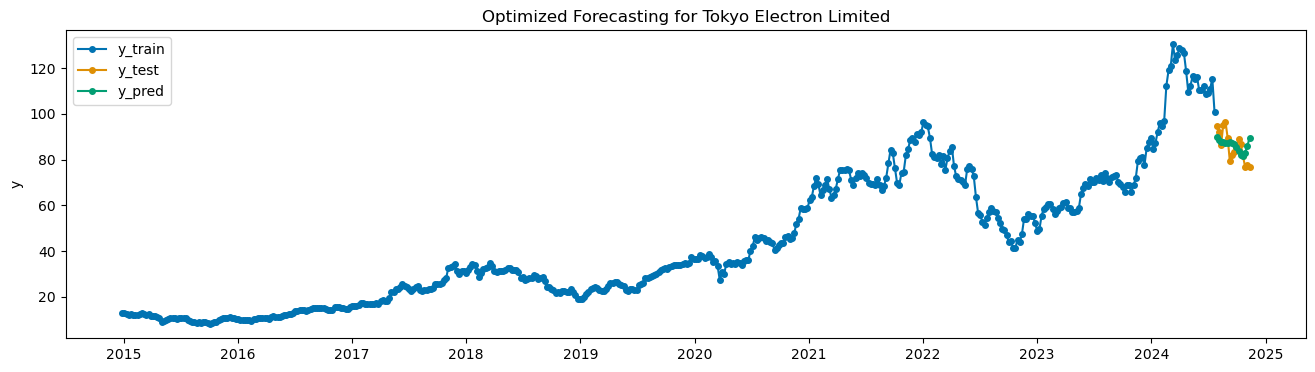

23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:07 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# Dictionary to store each optimized Prophet model by company
prophet_models = {}

# Hyperparameter grid for fine-tuning
param_grid = {
    'changepoint_prior_scale': [0.01, 0.02, 0.03, 0.07, 0.08, 0.09],
    'seasonality_prior_scale': [0.05, 0.06, 0.07, 0.08, 0.09],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False],
    'daily_seasonality': [True, False]
}

# Define the total number of parameter combinations
total_combinations = len(list(ParameterGrid(param_grid)))

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Prepare the training data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure DatetimeIndex
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    # Placeholder variables for tracking the best model
    best_mape = float('inf')
    best_params = None
    best_model = None

    # Perform grid search over the parameter grid
    for i, params in enumerate(ParameterGrid(param_grid), start=1):
        print(f"Processing combination {i} of {total_combinations} for {company}...")

        # Initialize and fit the Prophet model with the current set of parameters
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            seasonality_mode=params['seasonality_mode'],
            weekly_seasonality=params['weekly_seasonality'],
            yearly_seasonality=params['yearly_seasonality'],
            daily_seasonality=params['daily_seasonality']
        )
        
        # Fit the model
        model.fit(train_data_prophet)

        # Define the forecast horizon (e.g., test_weeks periods into the future)
        future = model.make_future_dataframe(periods=test_weeks, freq='W')
        forecast = model.predict(future)
        
        # Filter forecasted data
        forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]
        
        # Evaluate the model performance on test data
        actuals = test_dataframes[company]['Close']
        predictions = forecast_filtered['Close']

        # Align indices
        common_index = actuals.index.intersection(predictions.index)
        actuals = actuals.loc[common_index]
        predictions = predictions.loc[common_index]

        mape = mean_absolute_percentage_error(actuals, predictions) * 100
        rmse = root_mean_squared_error(actuals, predictions)
        
        # Check if current model is better
        if mape < best_mape:
            best_mape = mape
            best_params = params
            best_model = model

    # Print best parameters and MAPE for each company
    print(f'Best parameters for {company}: {best_params} with MAPE: {best_mape:.2f}')

    # Plot the best model's predictions
    future = best_model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = best_model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    plot_series(
        train_data_prophet.set_index('ds')[-500:],  # Only show the last 500 training points
        test_dataframes[company],                   # Test data
        forecast_filtered,                          # Forecasted data
        labels=["y_train", "y_test", "y_pred"]
    )
    
    plt.title(f'Optimized Forecasting for {company}')
    plt.show()

    # Refit the best model with all available data (train + test)
    # train_data_prophet = train_data_prophet.reset_index(names="ds")
    test_data = pd.DataFrame(actuals).rename(columns={'Close': 'y'}).reset_index(names="ds")
    all_data = pd.concat([train_data_prophet, test_data])

    # Re-initialize Prophet with the best parameters
    prophet_model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        weekly_seasonality=best_params['weekly_seasonality'],
        yearly_seasonality=best_params['yearly_seasonality'],
        daily_seasonality=best_params['daily_seasonality']
    )
    
    # Fit the model on all data
    prophet_model.fit(all_data)

    # Store the optimized model in the dictionary
    prophet_models[company] = prophet_model

#### 2.5.6.4 Save the best prophet models of ASML's suppliers

In [18]:
# Iterate over each company in prophet_models
for company in company_tickers.values():
    # Define the output path for the current company's model
    output_model_path = f'models/prophet_asml_supplier_{company.replace(" ", "_")}.pkl'

    # Save the current company's Prophet model
    joblib.dump(prophet_models[company], output_model_path)
    print(f'Prophet model for {company} saved at {output_model_path}')

Prophet model for Carl Zeiss Meditec saved at models/prophet_asml_supplier_Carl_Zeiss_Meditec.pkl
Prophet model for Lam Research Corporation saved at models/prophet_asml_supplier_Lam_Research_Corporation.pkl
Prophet model for Tokyo Electron Limited saved at models/prophet_asml_supplier_Tokyo_Electron_Limited.pkl


# 3. Export the data

In [19]:
# Export the weekly_data_suppliers to a CSV file
weekly_data_suppliers.to_csv(output_data, index=True, sep=';')